# Analysis of apriori rules tuples

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df_apriori_chi = pd.read_csv(
    r'./results_apriori/apriori_rules_with_rule_chi2.csv', 
    dtype={
        'division':str, 
        'year':int,
        'col_a_enc':str,
        'orig_col_a':str,
        'col_b_enc':str,
        'orig_col_b':str,
        'n_rows':int,
        'chi2':float,
        'p_value':float,
        'expected_min':float,
        'antecedent':str,
        'consequent':str,
        'support':float,
        'confidence':float,
        'lift':float,
        'conviction':float
        }
    )
df_apriori = pd.read_csv(
    r'./results_apriori/apriori_filtered_rules_flat.csv', 
    dtype={
        'division':str, 
        'year':int,
        'col_a_enc':str,
        'orig_col_a':str,
        'col_b_enc':str,
        'orig_col_b':str,
        'n_rows':int,
        'chi2':float,
        'p_value':float,
        'expected_min':float,
        'antecedent':str,
        'consequent':str,
        'support':float,
        'confidence':float,
        'lift':float,
        'conviction':float
        }
    )
df_association = pd.read_csv(
    r'./results_apriori/association_rules.csv', 
    dtype={
        'DIVISION':str, 
        'YEAR':int, 
        'ANTECEDENTE': str, 
        'CONSECUENTE': str, 
        'SUPPORT': float, 
        'CONFIDENCE': float, 
        'LIFT': float, 
        'CONVICTION': float
    }
    )

## VARIABLES COMPARABLES

In [3]:
mask = (df_apriori['P_VALUE']<=0.05) & (df_apriori['EXPECTED_MIN']>=5) 
df_valid_comparations = df_apriori[mask][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE']].drop_duplicates()

In [4]:
VARIABLES = ['AGR_ALFAB_ENC', 'AGR_ESCOLARIDAD_ENC', 'AGR_EST_CIV_ENC',
       'AGR_GRUPET_ENC', 'AGR_NACIONAL_ENC', 'AGR_SEXO_ENC', 'AGR_TRABAJA_ENC',
       'VIC_ALFAB_ENC', 'VIC_DISC_ENC',
       'VIC_ESCOLARIDAD_ENC', 'VIC_EST_CIV_ENC', 'VIC_GRUPET_ENC',
       'VIC_NACIONAL_ENC', 'VIC_REL_AGR_ENC', 'VIC_SEXO_ENC',
       'VIC_TRABAJA_ENC', 'VIC_OFICIO_ENC', 'AGR_OFICIO_ENC',
       'CANTIDAD_HIJOS_ENC', 'VIC_RANGO_EDAD_ENC', 'AGR_RANGO_EDAD_ENC', 'VIC_NIV_ESCOLARIDAD_ENC',
       'AGR_NIV_ESCOLARIDAD_ENC', 'OTROS_AGRESORES_ENC',
       'VIC_OTRAS_VICTIMAS_ENC', 'VIOLENCIA_FISICA_ENC',
       'VIOLENCIA_PSICOLOGICA_ENC', 'VIOLENCIA_SEXUAL_ENC',
       'VIOLENCIA_PATRIMONIAL_ENC', 'QUIEN_ES_MAYOR_ENC', 'DIF_ALFAB_ENC',
       'VIC_ES_INDIGENA_ENC', 'AGR_ES_INDIGENA_ENC',
       'GANA_MAS_LA_VICTIMA_ENC']

In [5]:
possible_comparations = len(VARIABLES)*(len(VARIABLES)-1)
print(f'Possible comparations: {possible_comparations}', f'Valid comparations: {len(df_valid_comparations)}', f'Percentage of valid comparations: {len(df_valid_comparations)/possible_comparations:.5f}', sep='\n')

Possible comparations: 1122
Valid comparations: 140
Percentage of valid comparations: 0.12478


In [6]:
df_valid_comparations = (
    df_apriori[mask]
    # 1) ordena por CHI_2 desc, P_VALUE asc, N_ROWS desc
    .sort_values(
        by=['CHI_2','P_VALUE','N_ROWS'],
        ascending=[False, True, False]
    )
    # 2) para cada par VARIABLE_ANTECEDENTE+VARIABLE_CONSECUENTE
    #    conserva solo la primera fila (la "mejor" según tu sort)
    .drop_duplicates(
        subset=['VARIABLE_ANTECEDENTE','VARIABLE_CONSECUENTE'],
        keep='first'
    )
    # 3) selecciona sólo las columnas que te importan
    [['VARIABLE_ANTECEDENTE','VARIABLE_CONSECUENTE','CHI_2','P_VALUE','N_ROWS']]
)


In [7]:
df_valid_comparations.head(15)

VARIABLE_ANTECEDENTE VARIABLE_CONSECUENTE         CHI_2  P_VALUE  N_ROWS
1217          AGR_EST_CIV          VIC_EST_CIV  28129.458888      0.0   15882
229           VIC_TRABAJA           VIC_OFICIO  24917.000000      0.0   24917
1221          AGR_EST_CIV          VIC_REL_AGR  24291.158572      0.0   16208
1253          VIC_EST_CIV          VIC_REL_AGR  23894.157727      0.0   16298
216            VIC_GRUPET      VIC_ES_INDIGENA  23137.000000      0.0   23137
185            AGR_GRUPET      AGR_ES_INDIGENA  22975.000000      0.0   22975
205             VIC_ALFAB  VIC_NIV_ESCOLARIDAD  22161.409839      0.0   25211
177             AGR_ALFAB  AGR_NIV_ESCOLARIDAD  19876.754607      0.0   24628
220            VIC_GRUPET      AGR_ES_INDIGENA  16103.494763      0.0   22657
253       VIC_ES_INDIGENA      AGR_ES_INDIGENA  16071.227020      0.0   22470
98             AGR_GRUPET      VIC_ES_INDIGENA  16001.765861      0.0   22233
152   VIC_NIV_ESCOLARIDAD  AGR_NIV_ESCOLARIDAD  15563.992698      0.0   23812
206             VIC_ALFAB            DIF_ALFAB  12676.987710      0.0   25078
242   VIC_NIV_ESCOLARIDAD            DIF_ALFAB  11433.110304      0.0   24832
1372            AGR_ALFAB            DIF_ALFAB   8790.180561      0.0   19269

In [8]:
df_apriori_chi.head()

division  year orig_col_a   orig_col_b      col_a_enc        col_b_enc  \
0  mujeres  2008  AGR_ALFAB     AGR_SEXO  AGR_ALFAB_ENC     AGR_SEXO_ENC   
1  mujeres  2008  AGR_ALFAB    VIC_ALFAB  AGR_ALFAB_ENC    VIC_ALFAB_ENC   
2  mujeres  2008  AGR_ALFAB    VIC_ALFAB  AGR_ALFAB_ENC    VIC_ALFAB_ENC   
3  mujeres  2008  AGR_ALFAB  VIC_REL_AGR  AGR_ALFAB_ENC  VIC_REL_AGR_ENC   
4  mujeres  2008  AGR_ALFAB  VIC_TRABAJA  AGR_ALFAB_ENC  VIC_TRABAJA_ENC   

   n_rows    pair_chi2  pair_p_value  pair_expected_min  ...   support  \
0   15325   104.925910  1.267891e-24          73.311582  ...  0.830734   
1   15292  2159.911026  0.000000e+00         511.759547  ...  0.714426   
2   15292  2159.911026  0.000000e+00         511.759547  ...  0.714426   
3   15325   235.890518  7.364608e-51         235.916672  ...  0.400326   
4   15268   188.077697  8.354860e-43         742.216400  ...  0.301218   

  confidence      lift  conviction  rule_n    rule_chi2  rule_p_value  \
0   0.973467  1.006299    1.229650   15325   104.925910  1.267891e-24   
1   0.925612  1.084716    1.971800   15292  2159.911026  0.000000e+00   
2   0.837229  1.084716    1.401714   15292  2159.911026  0.000000e+00   
3   0.879192  1.030250    1.213685   15325    68.233686  1.452235e-16   
4   0.909073  1.065377    1.613514   15268   188.077697  8.354860e-43   

   rule_dof  rule_expected_min                 rule_observed  
0         1          73.311582   [[153, 2094], [347, 12731]]  
1         1         511.759547  [[1365, 2124], [878, 10925]]  
2         1         511.759547  [[1365, 878], [2124, 10925]]  
3         1        1023.136444   [[1404, 6943], [843, 6135]]  
4         1         742.216400   [[1780, 8429], [460, 4599]]  

[5 rows x 22 columns]

In [9]:
df_association.head()

DIVISION  YEAR VARIABLE_ANTECEDENTE VARIABLE_CONSECUENTE  SUPPORT  \
0  mujeres  2008            AGR_ALFAB             AGR_SEXO   0.8307   
1  mujeres  2008            VIC_ALFAB            AGR_ALFAB   0.7144   
2  mujeres  2008            AGR_ALFAB            VIC_ALFAB   0.7144   
3  mujeres  2008          VIC_REL_AGR            AGR_ALFAB   0.4003   
4  mujeres  2008          VIC_TRABAJA            AGR_ALFAB   0.3012   

   CONFIDENCE    LIFT  CONVICTION ANTECEDENTE_VALOR CONSECUENTE_VALOR  
0      0.9735  1.0063      1.2296          alfabeta           hombres  
1      0.9256  1.0847      1.9718          alfabeta          alfabeta  
2      0.8372  1.0847      1.4017          alfabeta          alfabeta  
3      0.8792  1.0303      1.2137       esposos(as)          alfabeta  
4      0.9091  1.0654      1.6135                si          alfabeta

In [10]:
df_apriori.head()

DIVISION  YEAR VARIABLE_ANTECEDENTE_ENC VARIABLE_CONSECUENTE_ENC  \
0  mujeres  2008            AGR_ALFAB_ENC             AGR_SEXO_ENC   
1  mujeres  2008            AGR_ALFAB_ENC            VIC_ALFAB_ENC   
2  mujeres  2008            AGR_ALFAB_ENC            VIC_ALFAB_ENC   
3  mujeres  2008            AGR_ALFAB_ENC          VIC_REL_AGR_ENC   
4  mujeres  2008            AGR_ALFAB_ENC          VIC_TRABAJA_ENC   

  VARIABLE_ANTECEDENTE VARIABLE_CONSECUENTE         ANTECEDENT  \
0            AGR_ALFAB             AGR_SEXO    AGR_ALFAB_ENC=0   
1            AGR_ALFAB            VIC_ALFAB    VIC_ALFAB_ENC=0   
2            AGR_ALFAB            VIC_ALFAB    AGR_ALFAB_ENC=0   
3            AGR_ALFAB          VIC_REL_AGR  VIC_REL_AGR_ENC=1   
4            AGR_ALFAB          VIC_TRABAJA  VIC_TRABAJA_ENC=2   

        CONSECUENT VARIABLE_ANTECEDENTE_VALOR VARIABLE_CONSECUENTE_VALOR  \
0   AGR_SEXO_ENC=0                   alfabeta                    hombres   
1  AGR_ALFAB_ENC=0                   alfabeta                   alfabeta   
2  VIC_ALFAB_ENC=0                   alfabeta                   alfabeta   
3  AGR_ALFAB_ENC=0                esposos(as)                   alfabeta   
4  AGR_ALFAB_ENC=0                         si                   alfabeta   

   N_ROWS        CHI_2       P_VALUE  EXPECTED_MIN   SUPPORT  CONFIDENCE  \
0   15325   104.925910  1.267891e-24     73.311582  0.830734    0.973467   
1   15292  2159.911026  0.000000e+00    511.759547  0.714426    0.925612   
2   15292  2159.911026  0.000000e+00    511.759547  0.714426    0.837229   
3   15325   235.890518  7.364608e-51    235.916672  0.400326    0.879192   
4   15268   188.077697  8.354860e-43    742.216400  0.301218    0.909073   

       LIFT  CONVICTION  
0  1.006299    1.229650  
1  1.084716    1.971800  
2  1.084716    1.401714  
3  1.030250    1.213685  
4  1.065377    1.613514

In [11]:
mask = (df_apriori['DIVISION']=='mujeres') &(df_apriori['LIFT']>1.)&(df_apriori['CONFIDENCE']>0.6)&(df_apriori['P_VALUE']<=0.05) & (df_apriori['EXPECTED_MIN']>=5) & (((df_apriori['VARIABLE_ANTECEDENTE']!='VIC_ALFAB') & (df_apriori['VARIABLE_CONSECUENTE']!='VIC_NIV_ESCOLARIDAD')) | ((df_apriori['VARIABLE_ANTECEDENTE']!='AGR_ALFAB') & (df_apriori['VARIABLE_CONSECUENTE']!='AGR_NIV_ESCOLARIDAD')))
print(df_apriori[df_apriori['DIVISION']=='mujeres'].shape)
values_sorted = (
    df_apriori[mask]
    .groupby(
        ['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE',
         'VARIABLE_ANTECEDENTE_VALOR', 'VARIABLE_CONSECUENTE_VALOR']
    )
    .aggregate({
        'VARIABLE_CONSECUENTE': ['count'],
        'CHI_2': ['mean', 'median'],
        'SUPPORT': ['mean', 'median'],
        'LIFT': ['mean', 'median'],
        'CONVICTION': ['mean', 'median'],
    })
    .reset_index()
    .sort_values(
        by=[
            ('VARIABLE_CONSECUENTE', 'count'),
            ('CHI_2', 'mean'),
            ('SUPPORT', 'median'),
            ('LIFT', 'median'),
            ('CONVICTION', 'median'),     
        ],
        ascending=[
            False,  # VARIABLE CONSECUENTE desc (máxima cantidad de años esperados)
            False,  # SUPPORT desc (soporte medio)
            False,  # CHI_2 desc (más fuerte primero)
            False,  # LIFT desc (lift medio)
            False,  # CONVICTION desc (convicción media)
        ]
    )
)

values_sorted.head(8)
# values_sorted[(values_sorted['COUNT']>5) & (values_sorted['COUNT']<10)]

(1448, 18)


VARIABLE_ANTECEDENTE VARIABLE_CONSECUENTE VARIABLE_ANTECEDENTE_VALOR  \
                                                                           
120      VIC_ES_INDIGENA      AGR_ES_INDIGENA                         no   
157          VIC_TRABAJA  GANA_MAS_LA_VICTIMA                         no   
9              AGR_ALFAB            VIC_ALFAB                   alfabeta   
121      VIC_ES_INDIGENA      AGR_ES_INDIGENA                         si   
24           AGR_EST_CIV          VIC_EST_CIV                casados(as)   
118          VIC_EST_CIV          VIC_REL_AGR                esposos(as)   
117          VIC_EST_CIV          VIC_REL_AGR                casados(as)   
28           AGR_EST_CIV          VIC_REL_AGR                esposos(as)   

    VARIABLE_CONSECUENTE_VALOR VARIABLE_CONSECUENTE         CHI_2  \
                                              count          mean   
120                         no                   32  12807.184417   
157                         no                   32   3691.643098   
9                     alfabeta                   32   3231.837626   
121                         si                   28  12662.258686   
24                 casados(as)                   18  23804.774126   
118                casados(as)                   16  19209.003649   
117                esposos(as)                   16  19209.003649   
28                 casados(as)                   16  18810.208742   

                    SUPPORT                LIFT              CONVICTION  \
           median      mean    median      mean    median          mean   
120  13312.849488  0.612706  0.612739  1.478174  1.472681  7.480991e+00   
157   3526.898076  0.667646  0.666011  1.107656  1.110831  3.317715e+00   
9     3245.336869  0.764916  0.774556  1.074409  1.071652  1.743824e+00   
121  12406.541484  0.328834  0.323637  2.527727  2.545647  7.314987e+00   
24   23371.825757  0.467804  0.473102  1.767817  1.744296  5.379207e+00   
118  19269.329613  0.397545  0.388157  1.936528  1.950217  5.877109e+07   
117  19269.329613  0.397545  0.388157  1.936528  1.950217  2.881164e+00   
28   18775.577135  0.402078  0.398533  1.944078  1.951425  6.130270e+07   

                
        median  
120   7.504621  
157   2.408657  
9     1.691384  
121   7.444240  
24    5.339971  
118  55.200408  
117   2.668378  
28   66.770424

In [12]:
df_apriori.columns

Index(['DIVISION', 'YEAR', 'VARIABLE_ANTECEDENTE_ENC',
       'VARIABLE_CONSECUENTE_ENC', 'VARIABLE_ANTECEDENTE',
       'VARIABLE_CONSECUENTE', 'ANTECEDENT', 'CONSECUENT',
       'VARIABLE_ANTECEDENTE_VALOR', 'VARIABLE_CONSECUENTE_VALOR', 'N_ROWS',
       'CHI_2', 'P_VALUE', 'EXPECTED_MIN', 'SUPPORT', 'CONFIDENCE', 'LIFT',
       'CONVICTION'],
      dtype='object')

In [13]:
mask = (df_apriori['DIVISION']=='mujeres')&(df_apriori['VARIABLE_ANTECEDENTE'].isin(['AGR_GRUPET', 'AGR_ES_INDIGENA', 'VIC_ES_INDIGENA', 'VIC_GRUPET'])) & (df_apriori['VARIABLE_CONSECUENTE'].isin(['AGR_GRUPET', 'AGR_ES_INDIGENA', 'VIC_ES_INDIGENA', 'VIC_GRUPET']))&(df_apriori['CONVICTION']>=2)
df_apriori[mask][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE']].value_counts()

VARIABLE_ANTECEDENTE  VARIABLE_CONSECUENTE
AGR_GRUPET            AGR_ES_INDIGENA         60
VIC_ES_INDIGENA       AGR_ES_INDIGENA         60
VIC_GRUPET            VIC_ES_INDIGENA         56
AGR_GRUPET            VIC_ES_INDIGENA         50
VIC_GRUPET            AGR_ES_INDIGENA         48
Name: count, dtype: int64

In [14]:
df_apriori[df_apriori['CONVICTION']>=1.5]

DIVISION  YEAR VARIABLE_ANTECEDENTE_ENC VARIABLE_CONSECUENTE_ENC  \
1     mujeres  2008            AGR_ALFAB_ENC            VIC_ALFAB_ENC   
4     mujeres  2008            AGR_ALFAB_ENC          VIC_TRABAJA_ENC   
6     mujeres  2008            AGR_ALFAB_ENC  AGR_NIV_ESCOLARIDAD_ENC   
9     mujeres  2008            AGR_ALFAB_ENC      VIC_ES_INDIGENA_ENC   
10    mujeres  2008            AGR_ALFAB_ENC      AGR_ES_INDIGENA_ENC   
...       ...   ...                      ...                      ...   
1442  mujeres  2023      VIC_ES_INDIGENA_ENC      AGR_ES_INDIGENA_ENC   
1443  mujeres  2023      VIC_ES_INDIGENA_ENC      AGR_ES_INDIGENA_ENC   
1444  mujeres  2023      VIC_ES_INDIGENA_ENC      AGR_ES_INDIGENA_ENC   
1445  mujeres  2023      VIC_ES_INDIGENA_ENC      AGR_ES_INDIGENA_ENC   
1446  mujeres  2023      VIC_ES_INDIGENA_ENC  GANA_MAS_LA_VICTIMA_ENC   

     VARIABLE_ANTECEDENTE VARIABLE_CONSECUENTE                 ANTECEDENT  \
1               AGR_ALFAB            VIC_ALFAB            VIC_ALFAB_ENC=0   
4               AGR_ALFAB          VIC_TRABAJA          VIC_TRABAJA_ENC=2   
6               AGR_ALFAB  AGR_NIV_ESCOLARIDAD  AGR_NIV_ESCOLARIDAD_ENC=4   
9               AGR_ALFAB      VIC_ES_INDIGENA      VIC_ES_INDIGENA_ENC=1   
10              AGR_ALFAB      AGR_ES_INDIGENA      AGR_ES_INDIGENA_ENC=1   
...                   ...                  ...                        ...   
1442      VIC_ES_INDIGENA      AGR_ES_INDIGENA      VIC_ES_INDIGENA_ENC=1   
1443      VIC_ES_INDIGENA      AGR_ES_INDIGENA      AGR_ES_INDIGENA_ENC=1   
1444      VIC_ES_INDIGENA      AGR_ES_INDIGENA      VIC_ES_INDIGENA_ENC=2   
1445      VIC_ES_INDIGENA      AGR_ES_INDIGENA      AGR_ES_INDIGENA_ENC=2   
1446      VIC_ES_INDIGENA  GANA_MAS_LA_VICTIMA      VIC_ES_INDIGENA_ENC=2   

                     CONSECUENT VARIABLE_ANTECEDENTE_VALOR  \
1               AGR_ALFAB_ENC=0                   alfabeta   
4               AGR_ALFAB_ENC=0                         si   
6               AGR_ALFAB_ENC=0                   primaria   
9               AGR_ALFAB_ENC=0                         no   
10              AGR_ALFAB_ENC=0                         no   
...                         ...                        ...   
1442      AGR_ES_INDIGENA_ENC=1                         no   
1443      VIC_ES_INDIGENA_ENC=1                         no   
1444      AGR_ES_INDIGENA_ENC=2                         si   
1445      VIC_ES_INDIGENA_ENC=2                         si   
1446  GANA_MAS_LA_VICTIMA_ENC=0                         si   

     VARIABLE_CONSECUENTE_VALOR  N_ROWS         CHI_2        P_VALUE  \
1                      alfabeta   15292   2159.911026   0.000000e+00   
4                      alfabeta   15268    188.077697   8.354860e-43   
6                      alfabeta   15020  11752.765072   0.000000e+00   
9                      alfabeta   13739    511.509541  2.977026e-113   
10                     alfabeta   13801    485.916896  1.102190e-107   
...                         ...     ...           ...            ...   
1442                         no   16978  13439.898931   0.000000e+00   
1443                         no   16978  13439.898931   0.000000e+00   
1444                         si   16978  13439.898931   0.000000e+00   
1445                         si   16978  13439.898931   0.000000e+00   
1446                         no   17571    177.342551   1.843625e-40   

      EXPECTED_MIN   SUPPORT  CONFIDENCE      LIFT    CONVICTION  
1       511.759547  0.714426    0.925612  1.084716  1.971800e+00  
4       742.216400  0.301218    0.909073  1.065377  1.613514e+00  
6        57.895406  0.497736    1.000000  1.175918  1.496005e+08  
9       674.786083  0.596113    0.904772  1.056940  1.511849e+00  
10      714.139990  0.581625    0.904145  1.057556  1.513349e+00  
...            ...       ...         ...       ...           ...  
1442   1921.020144  0.639003    0.961109  1.450979  8.681047e+00  
1443   1921.020144  0.639003    0.964699  1.450979  9.493

In [15]:
mask = (df_apriori['N_ROWS']>=15000)&(df_apriori['LIFT']>1.1)&(df_apriori['CONFIDENCE']>0.6)&(df_apriori['P_VALUE']<=0.05) & (df_apriori['EXPECTED_MIN']>=5) & (df_apriori['CONVICTION']>=1.5)
df_apriori[mask].groupby(by=['YEAR', 'DIVISION'])[['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE']].count()
# [].value_counts()

VARIABLE_ANTECEDENTE  VARIABLE_CONSECUENTE
YEAR DIVISION                                            
2008 mujeres                      9                     9
2009 mujeres                     36                    36
2010 mujeres                     33                    33
2011 mujeres                     27                    27
2012 mujeres                     33                    33
2013 mujeres                     33                    33
2014 mujeres                     34                    34
2015 mujeres                     30                    30
2016 mujeres                     26                    26
2017 mujeres                     22                    22
2018 mujeres                      4                     4
2019 mujeres                     24                    24
2020 mujeres                      4                     4
2021 mujeres                     28                    28
2022 mujeres                     19                    19
2023 mujeres                     24                    24

In [16]:
MIN_AMOUNT_REPETITIONS = math.floor((2023-2008)*0.7)

In [17]:
df_apriori['DIVISION'].unique()

array(['mujeres'], dtype=object)

In [18]:
df_apriori.columns

Index(['DIVISION', 'YEAR', 'VARIABLE_ANTECEDENTE_ENC',
       'VARIABLE_CONSECUENTE_ENC', 'VARIABLE_ANTECEDENTE',
       'VARIABLE_CONSECUENTE', 'ANTECEDENT', 'CONSECUENT',
       'VARIABLE_ANTECEDENTE_VALOR', 'VARIABLE_CONSECUENTE_VALOR', 'N_ROWS',
       'CHI_2', 'P_VALUE', 'EXPECTED_MIN', 'SUPPORT', 'CONFIDENCE', 'LIFT',
       'CONVICTION'],
      dtype='object')

In [19]:
df_apriori[['VARIABLE_ANTECEDENTE', 'ANTECEDENTE_VALOR']] = df_apriori['ANTECEDENT'].str.split('=', n=1, expand=True)
df_apriori[['VARIABLE_CONSECUENTE', 'CONSECUENTE_VALOR']] = df_apriori['CONSECUENT'].str.split('=', n=1, expand=True)

In [20]:
df_mujer = df_apriori.copy()
df_mujer = df_mujer[df_mujer['DIVISION']=='mujeres']

df_menor = df_apriori.copy()
df_menor = df_menor[df_menor['DIVISION']=='menores']

df_ancianos = df_apriori.copy()
df_ancianos = df_ancianos[df_ancianos['DIVISION']=='ancianos']

df_hombres = df_apriori.copy()
df_hombres = df_hombres[df_hombres['DIVISION']=='hombres']

In [21]:
df_apriori[(df_apriori['VARIABLE_ANTECEDENTE'] == 'GANA_MAS_LA_VICTIMA')
           |
           df_apriori['VARIABLE_CONSECUENTE'] == 'GANA_MAS_LA_VICTIMA']

Empty DataFrame
Columns: [DIVISION, YEAR, VARIABLE_ANTECEDENTE_ENC, VARIABLE_CONSECUENTE_ENC, VARIABLE_ANTECEDENTE, VARIABLE_CONSECUENTE, ANTECEDENT, CONSECUENT, VARIABLE_ANTECEDENTE_VALOR, VARIABLE_CONSECUENTE_VALOR, N_ROWS, CHI_2, P_VALUE, EXPECTED_MIN, SUPPORT, CONFIDENCE, LIFT, CONVICTION, ANTECEDENTE_VALOR, CONSECUENTE_VALOR]
Index: []

In [22]:
def analysis_graphs(df:pd.DataFrame, x='VARIABLE_CONSECUENTE', y='VARIABLE_ANTECEDENTE'):
    for var in df[x].unique():    
        # Filter rows for current 'VARIABLE_CONSECUENTE'
        subset = df[df[x] == var]

        # Count occurrences of each 'VARIABLE_ANTECEDENTE'
        temp = subset[y].value_counts().reset_index()
        temp.columns = [y, 'count']

        # Filter by minimum count threshold
        filtered_temp = temp[temp['count'] >= MIN_AMOUNT_REPETITIONS]

        if not filtered_temp.empty:
            plt.figure(figsize=(30, 6))
            plt.title(f'Variable Consecuente: {var} vs Variable Antecedente')
            sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')
            plt.xlabel('Variable Antecedente')
            plt.ylabel('Conteo')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y')
            plt.tight_layout()
            plt.show()
        else:
            print(f"No results for {var} with count >= {MIN_AMOUNT_REPETITIONS}")


C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


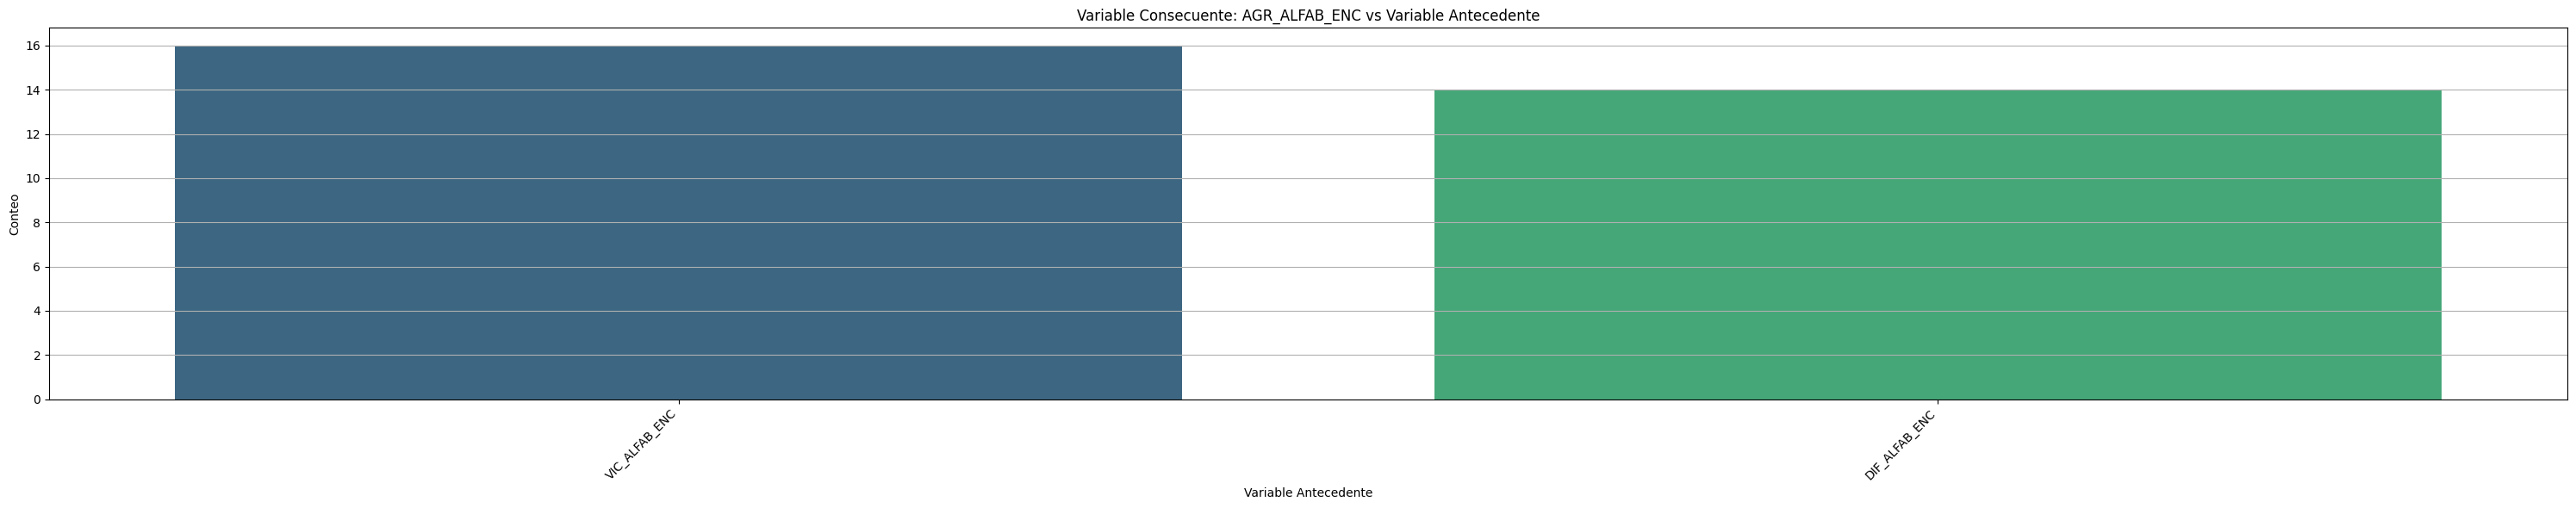

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


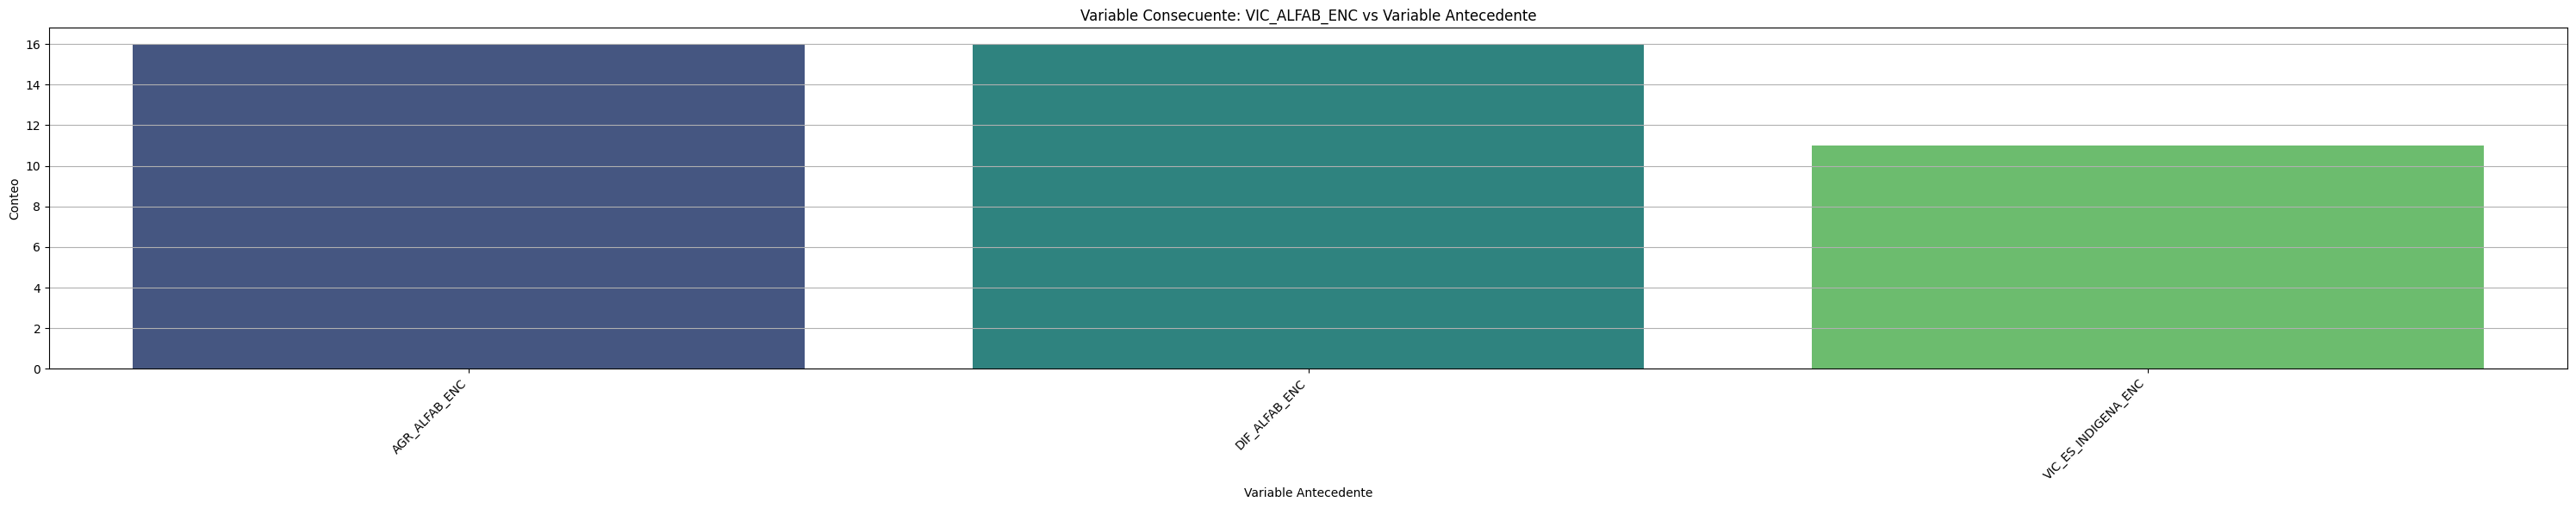

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


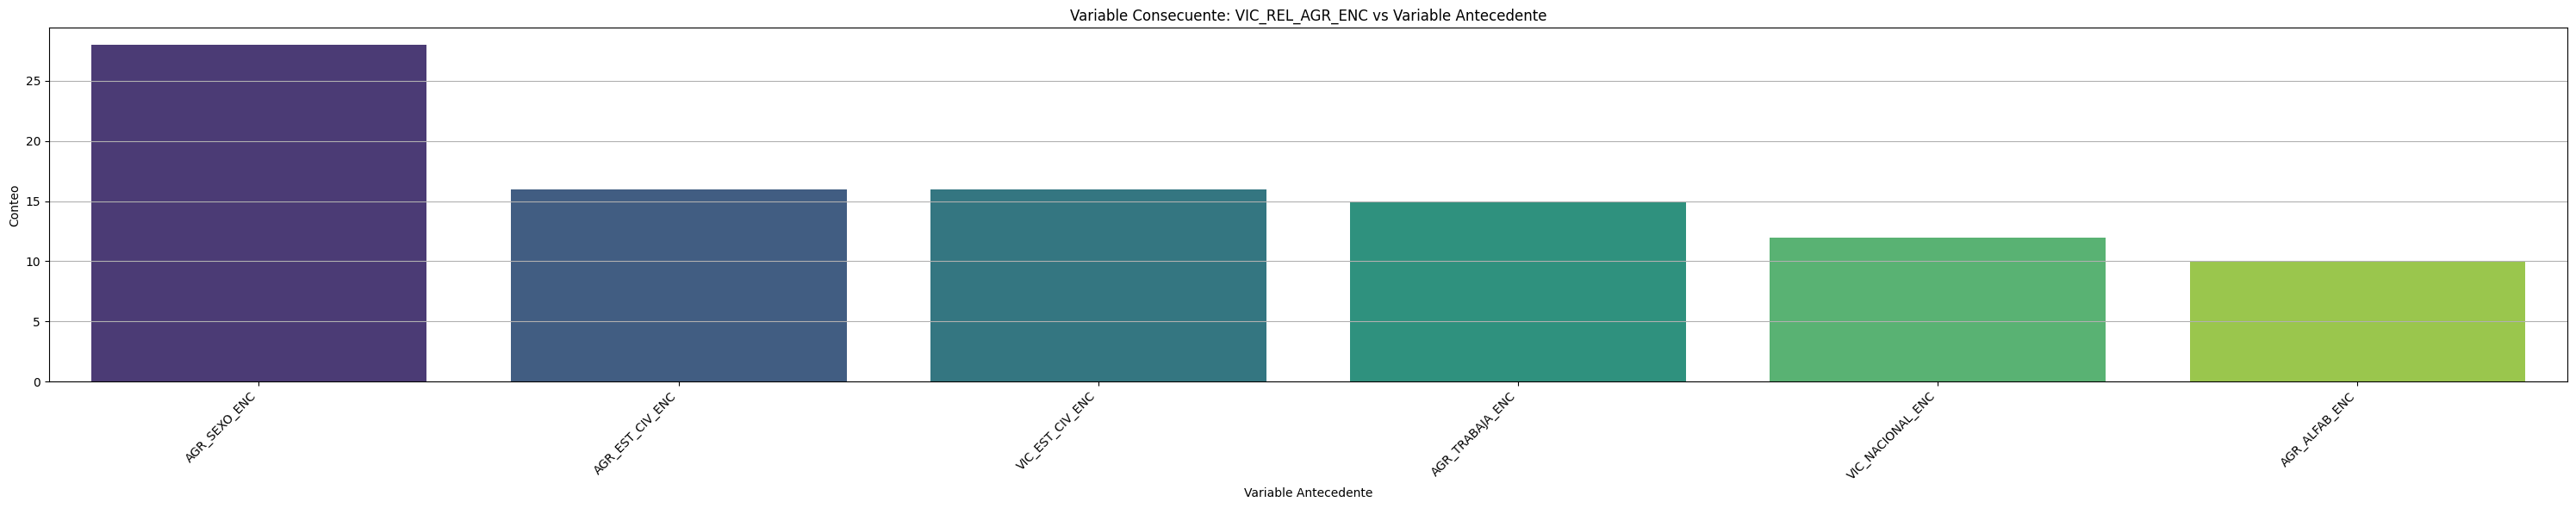

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


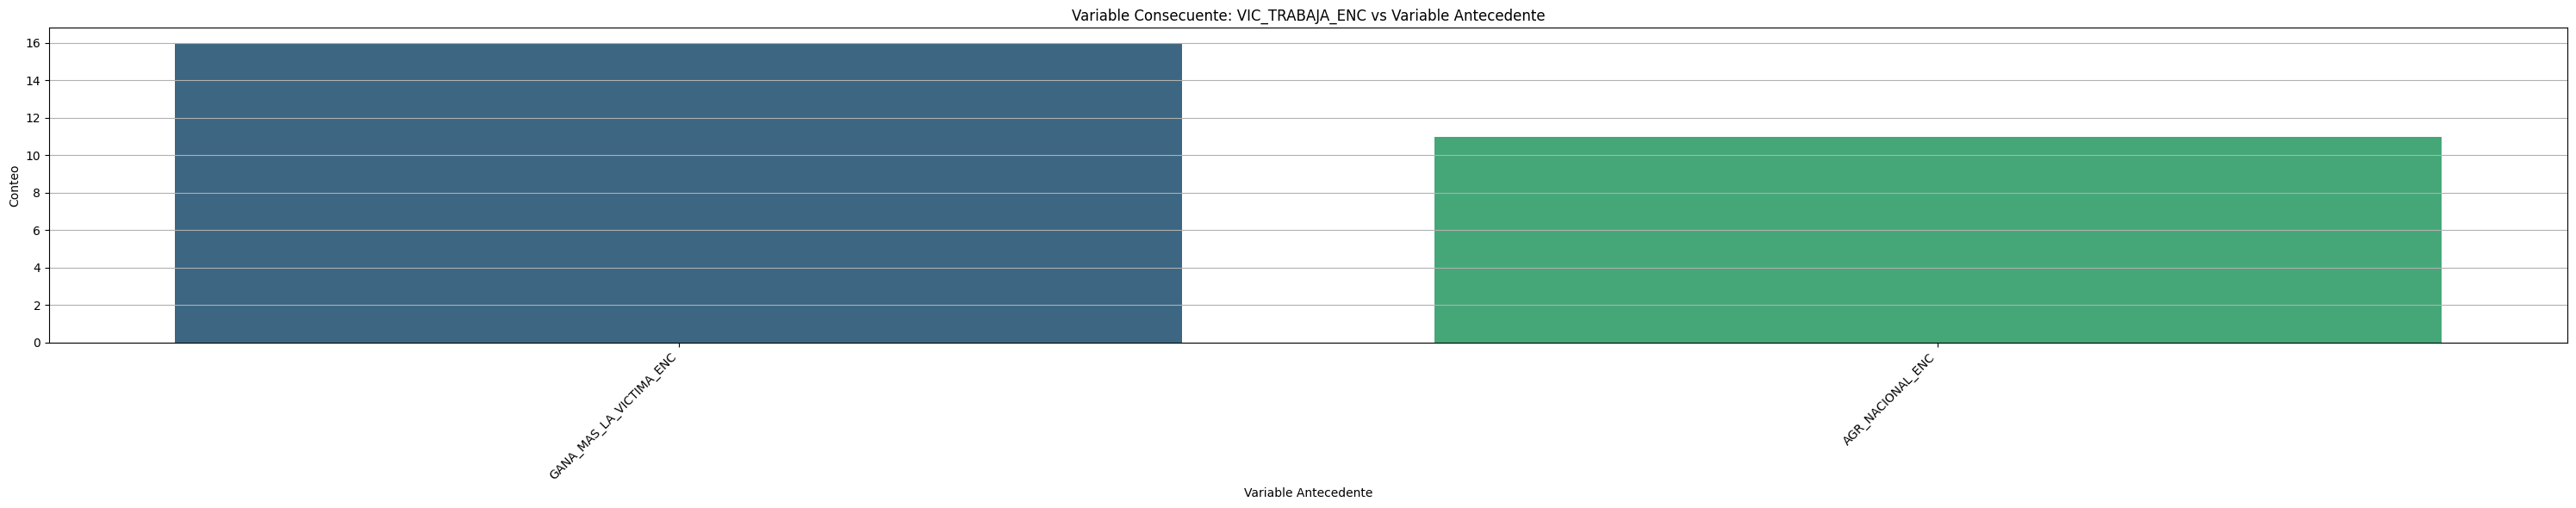

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


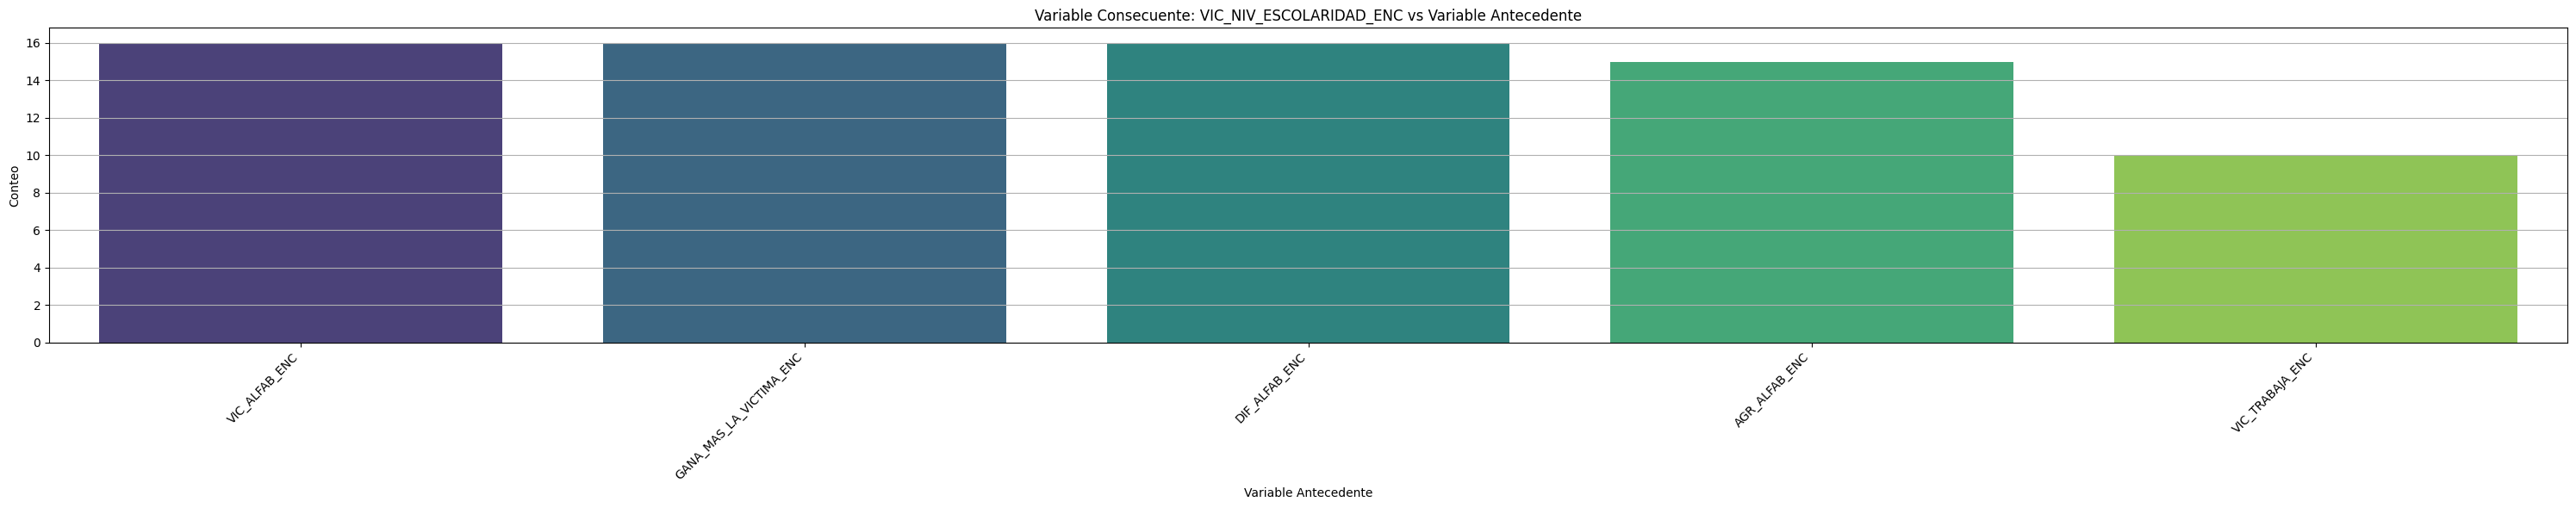

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


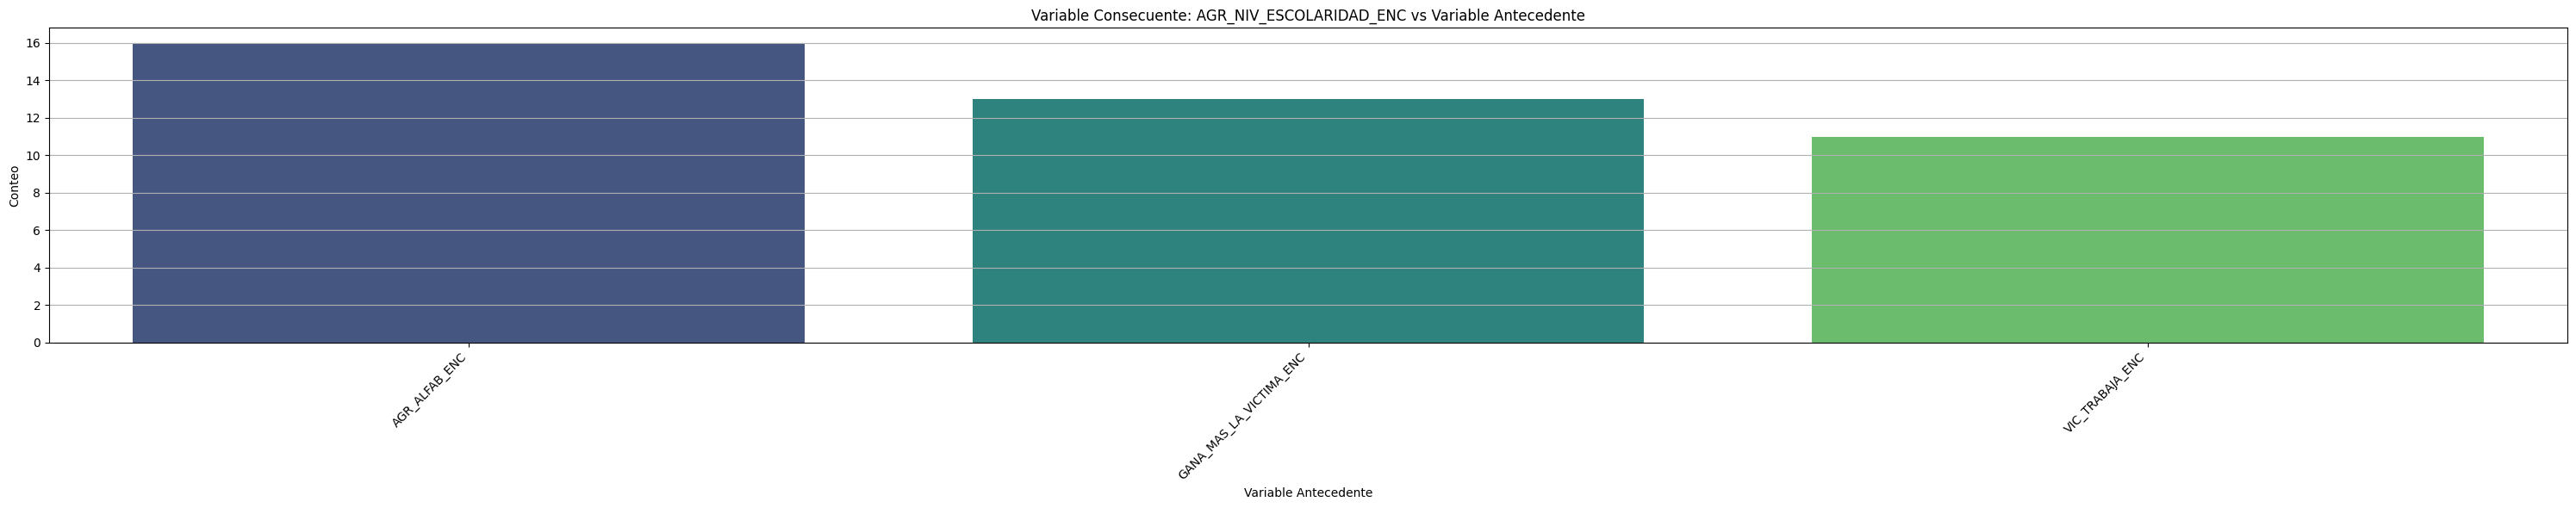

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


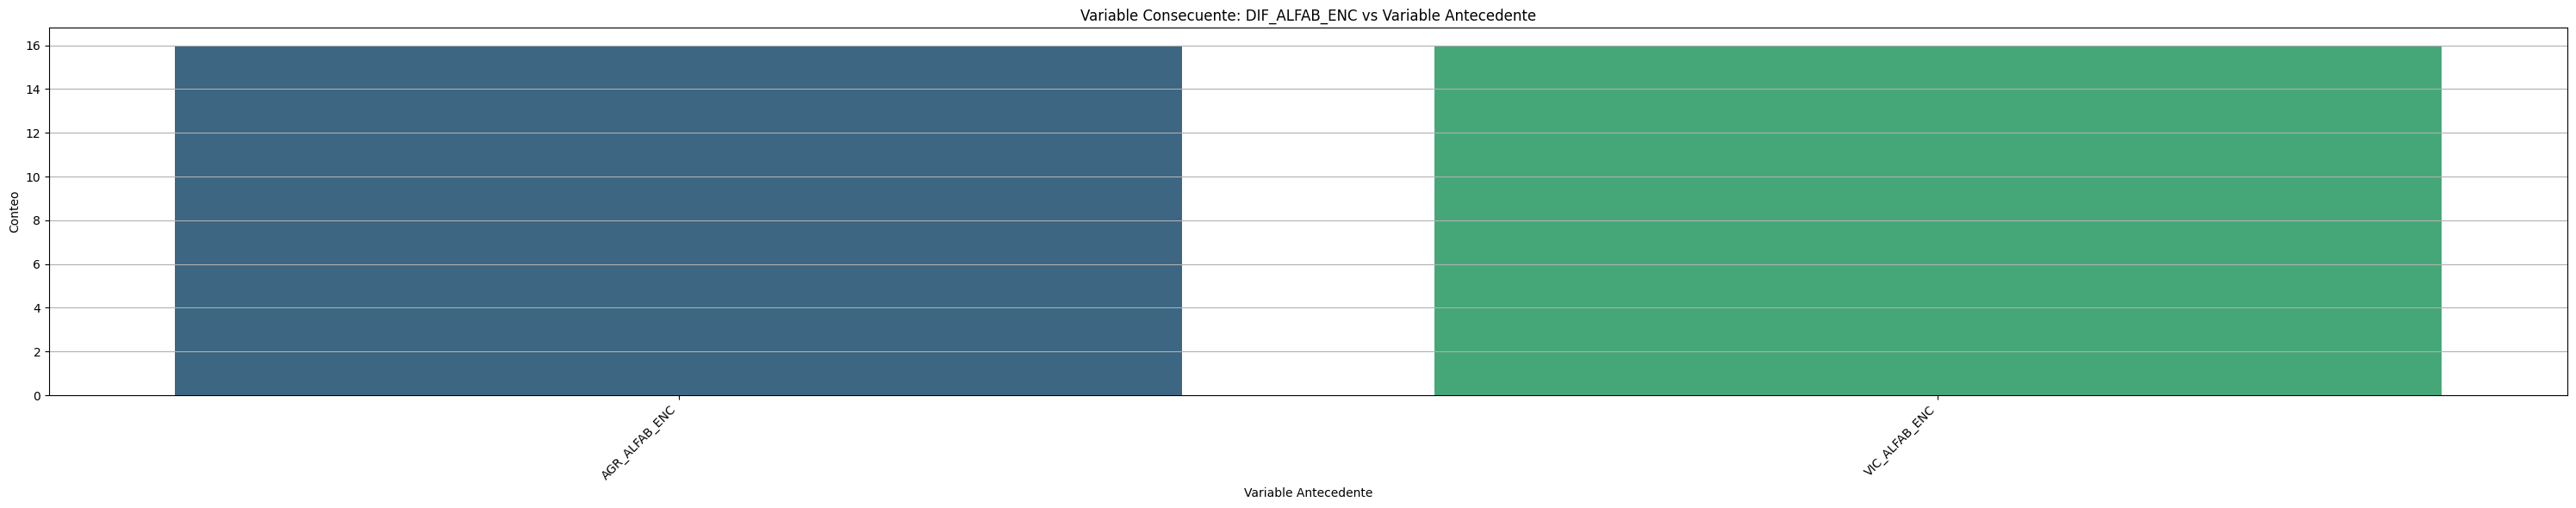

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


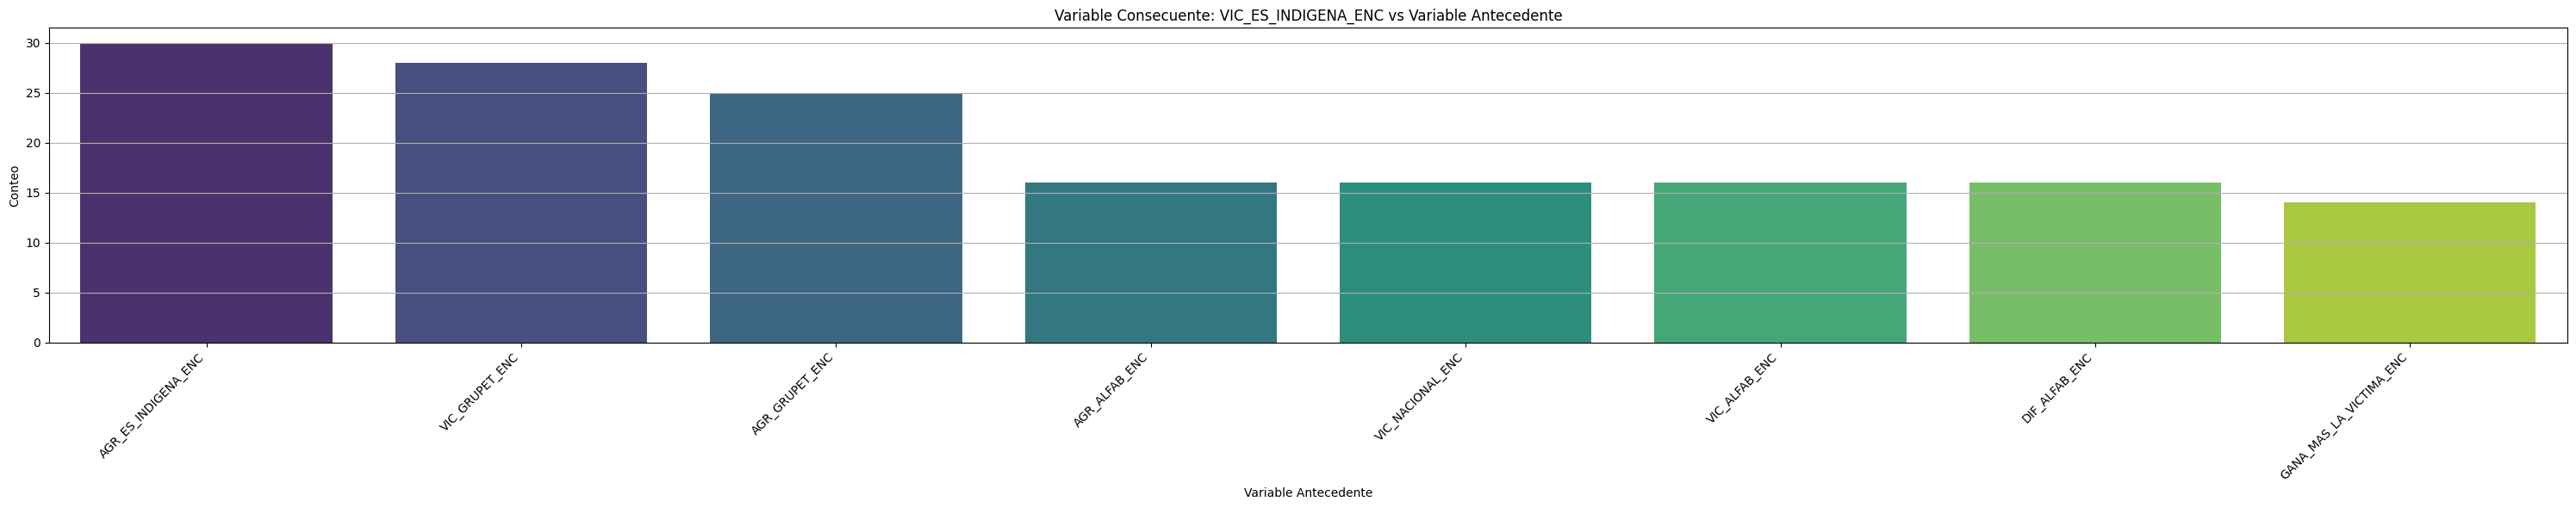

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


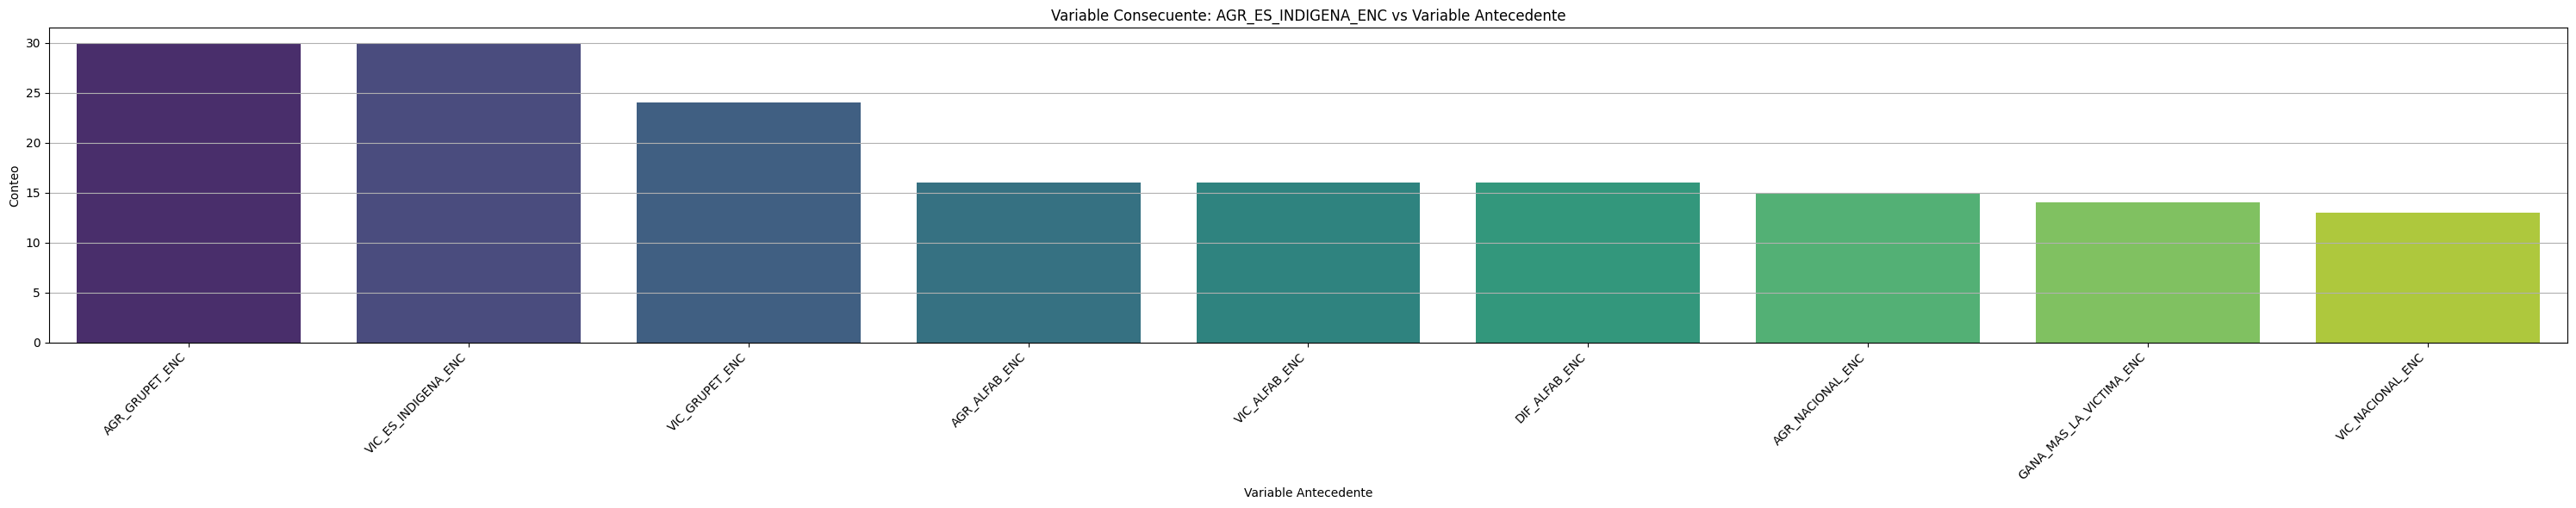

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


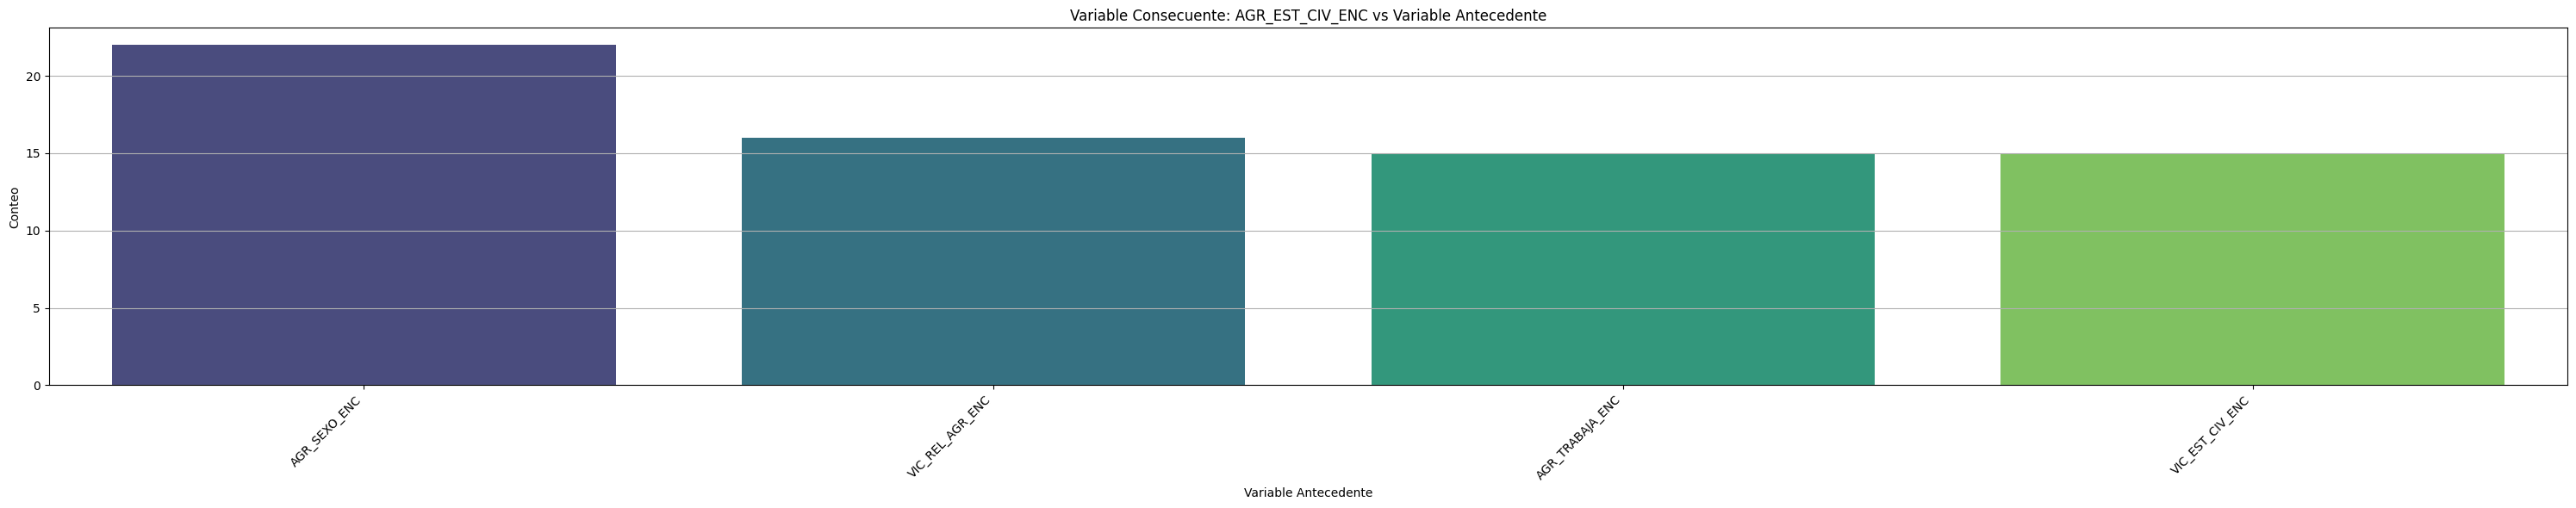

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


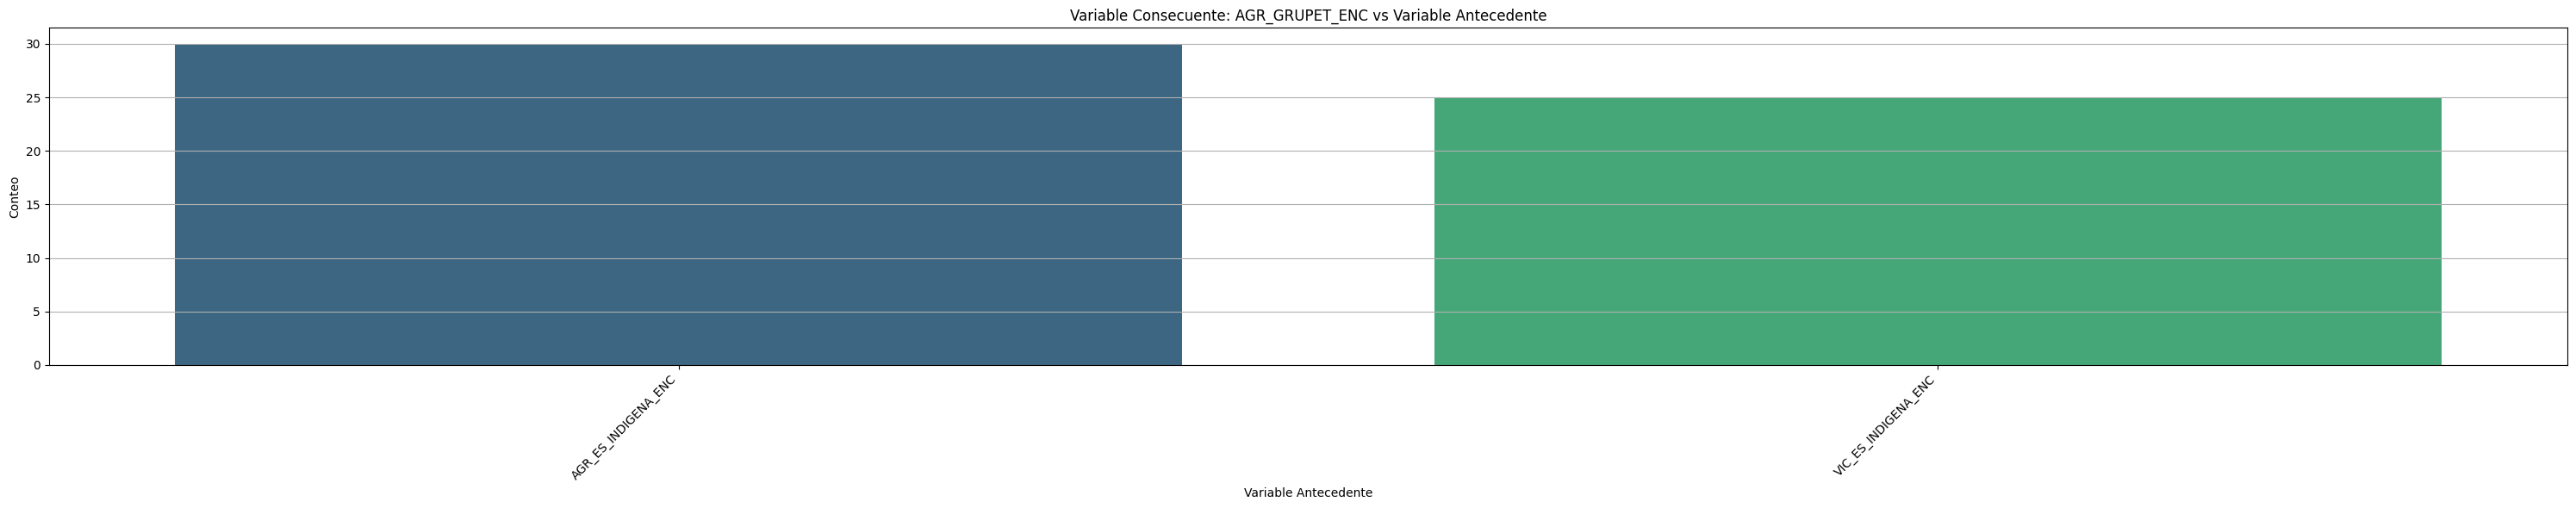

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


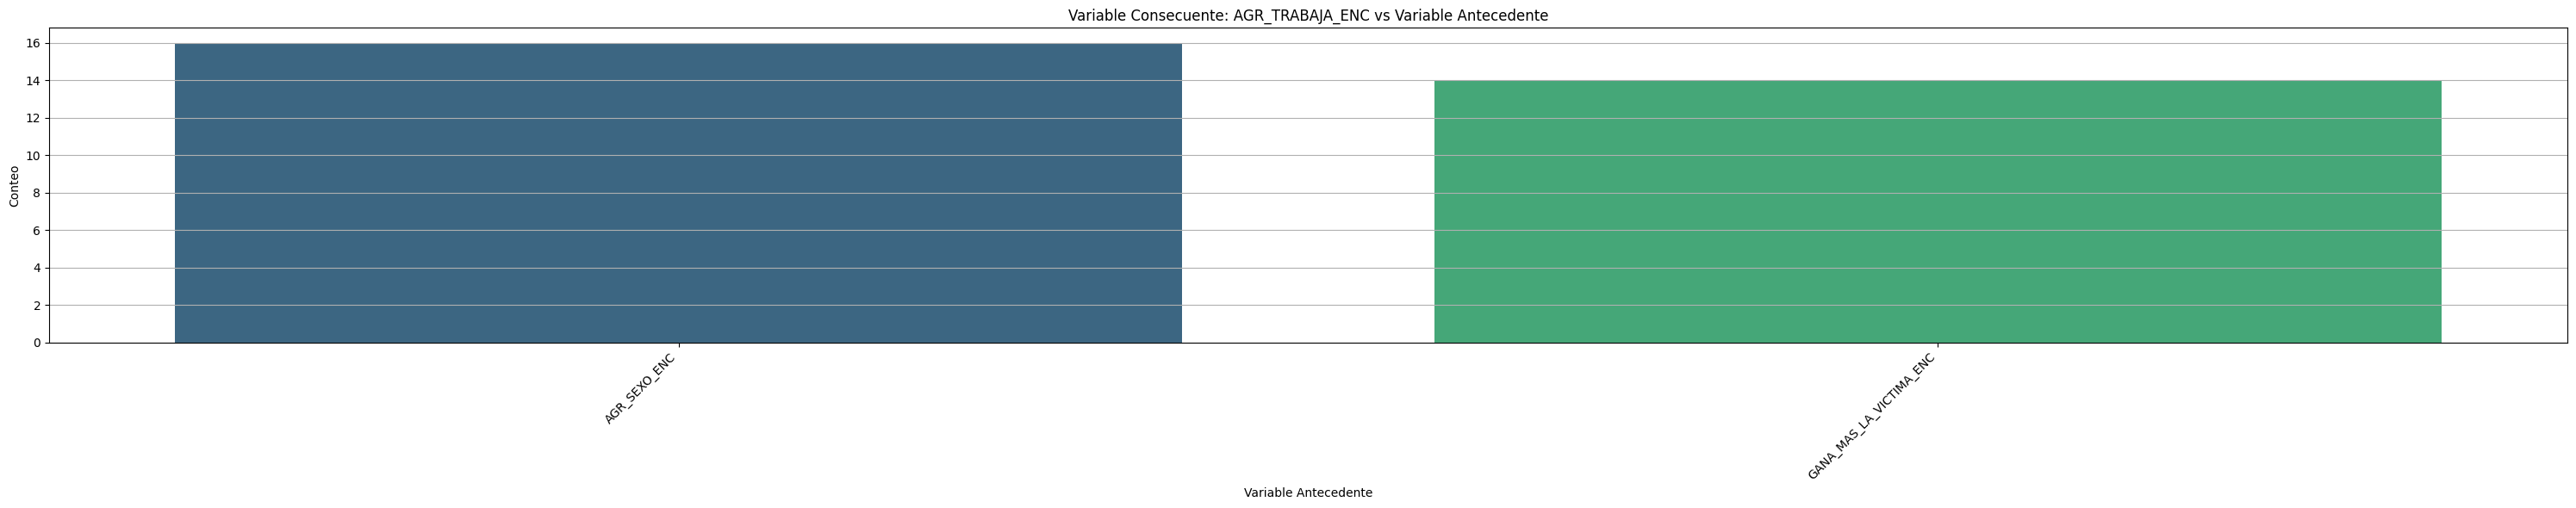

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


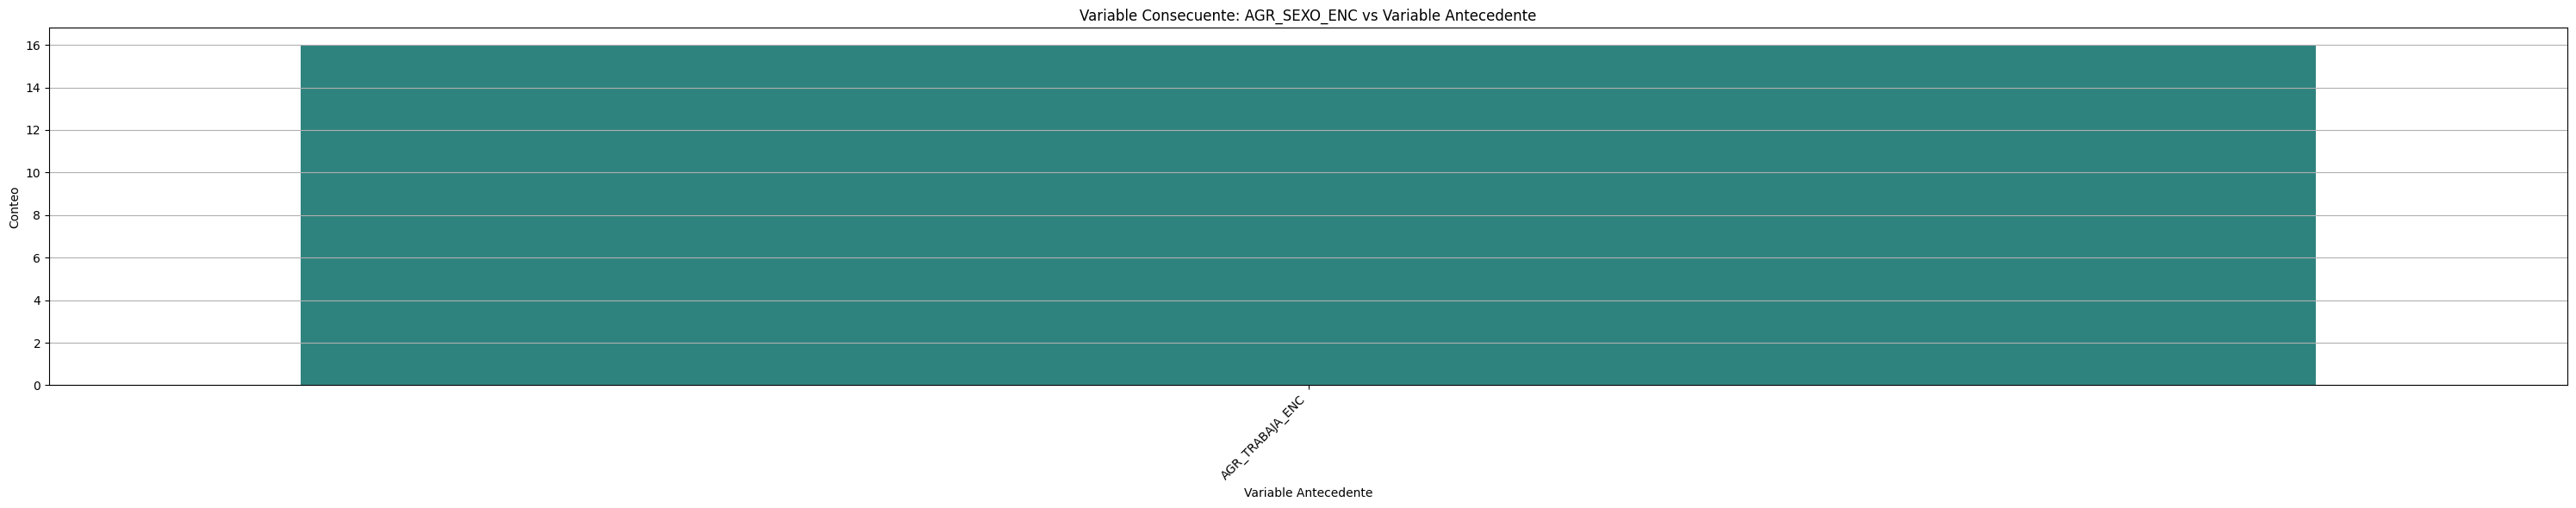

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


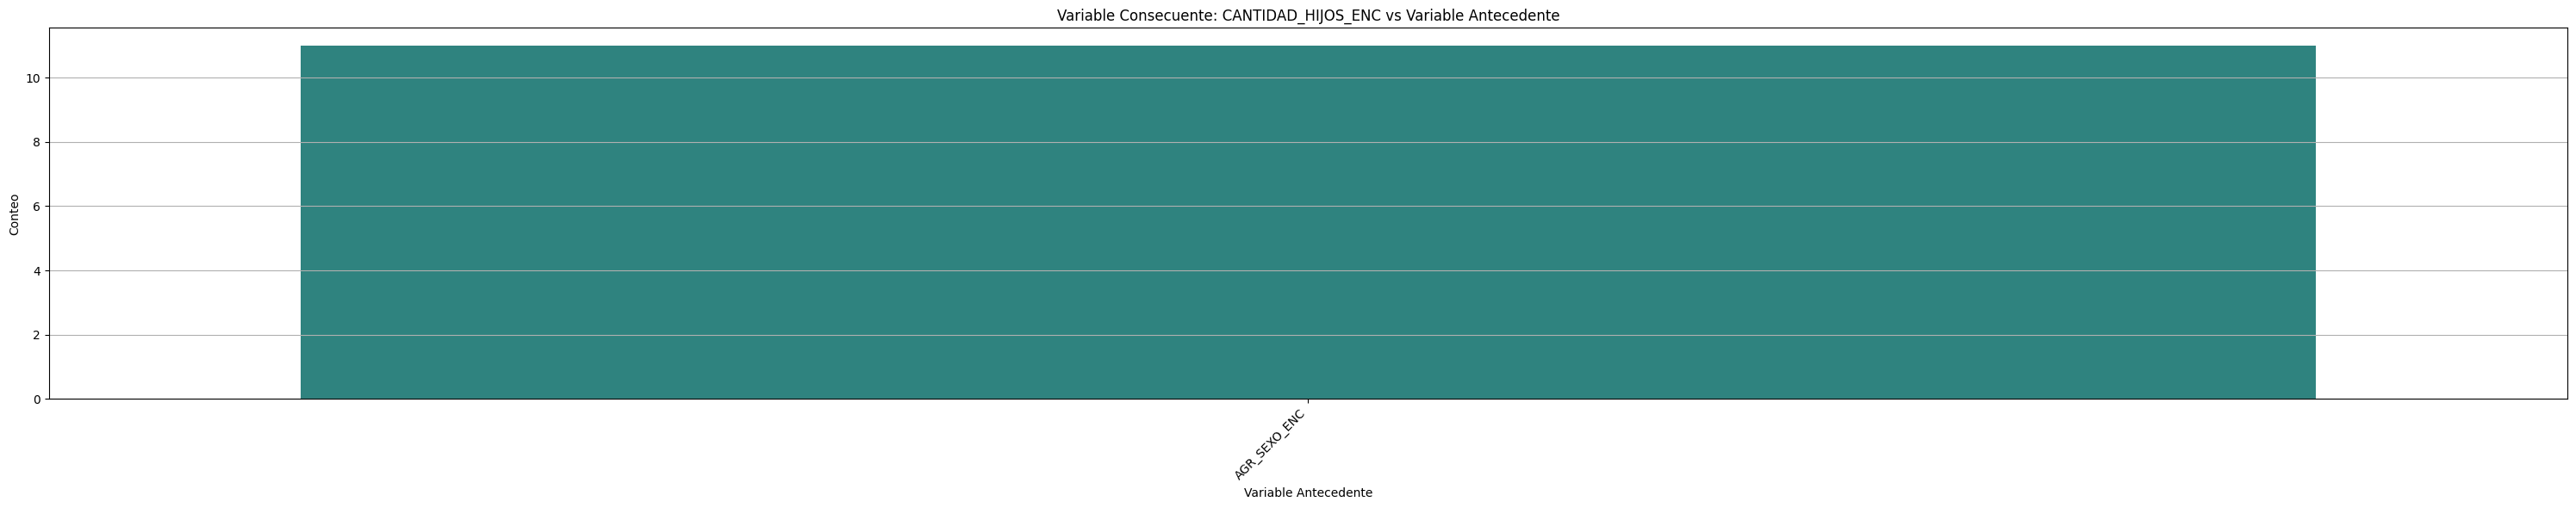

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


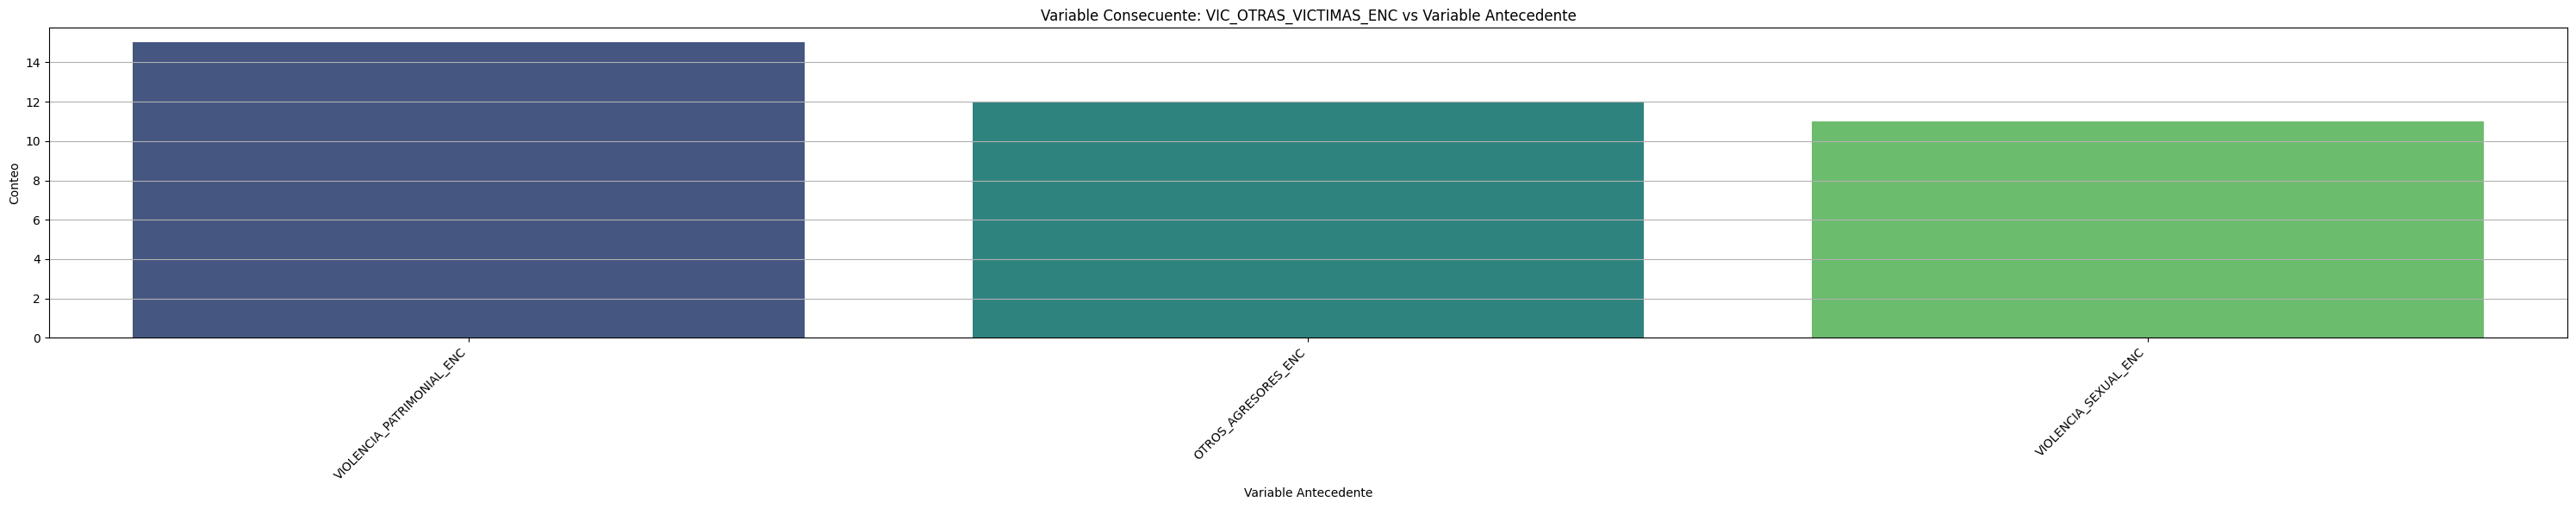

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


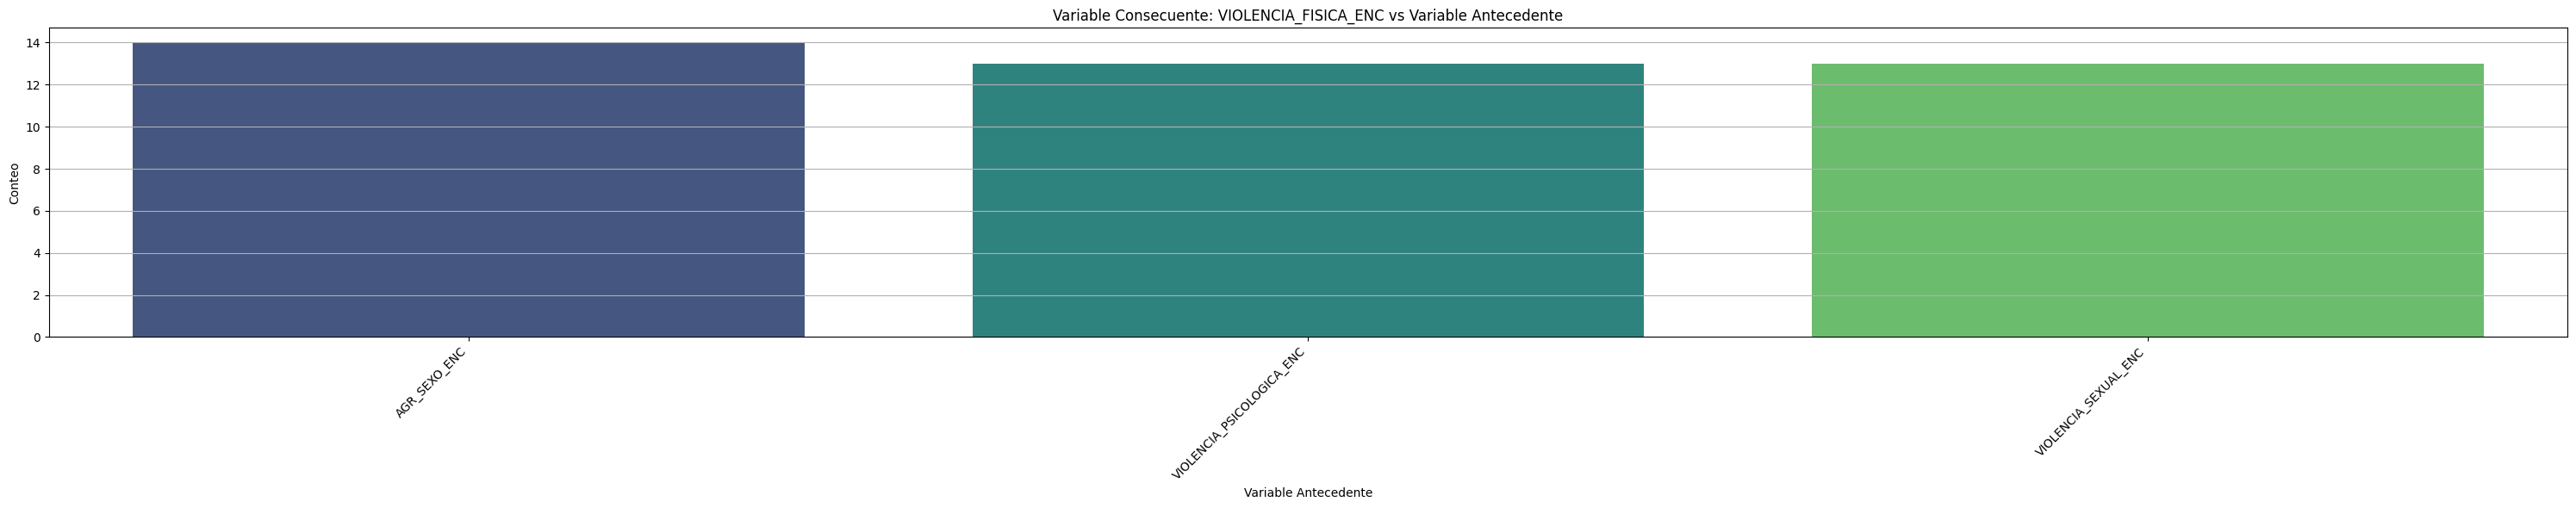

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


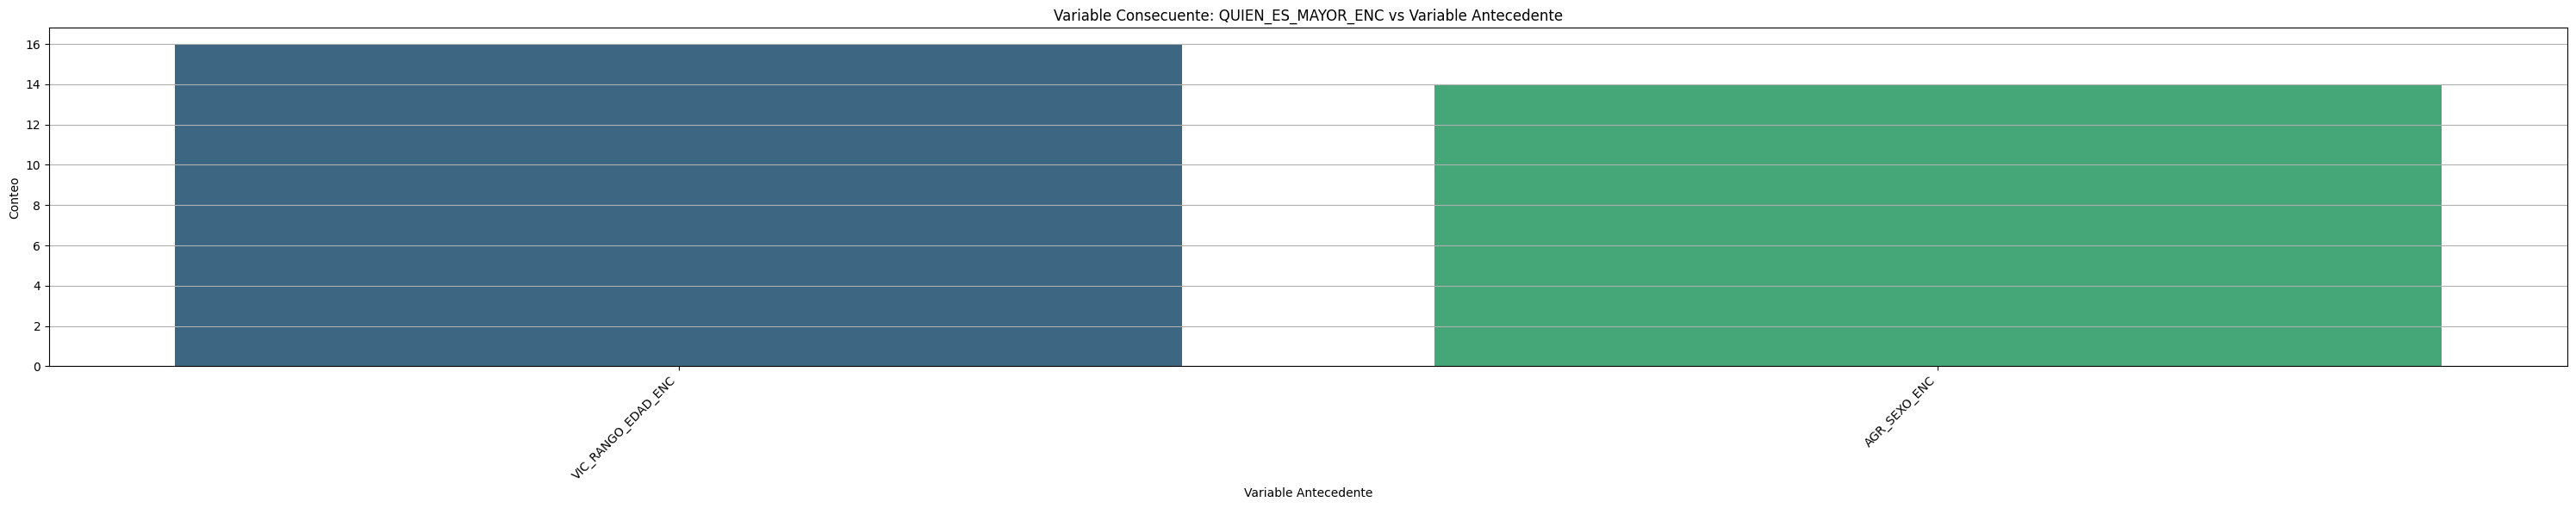

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


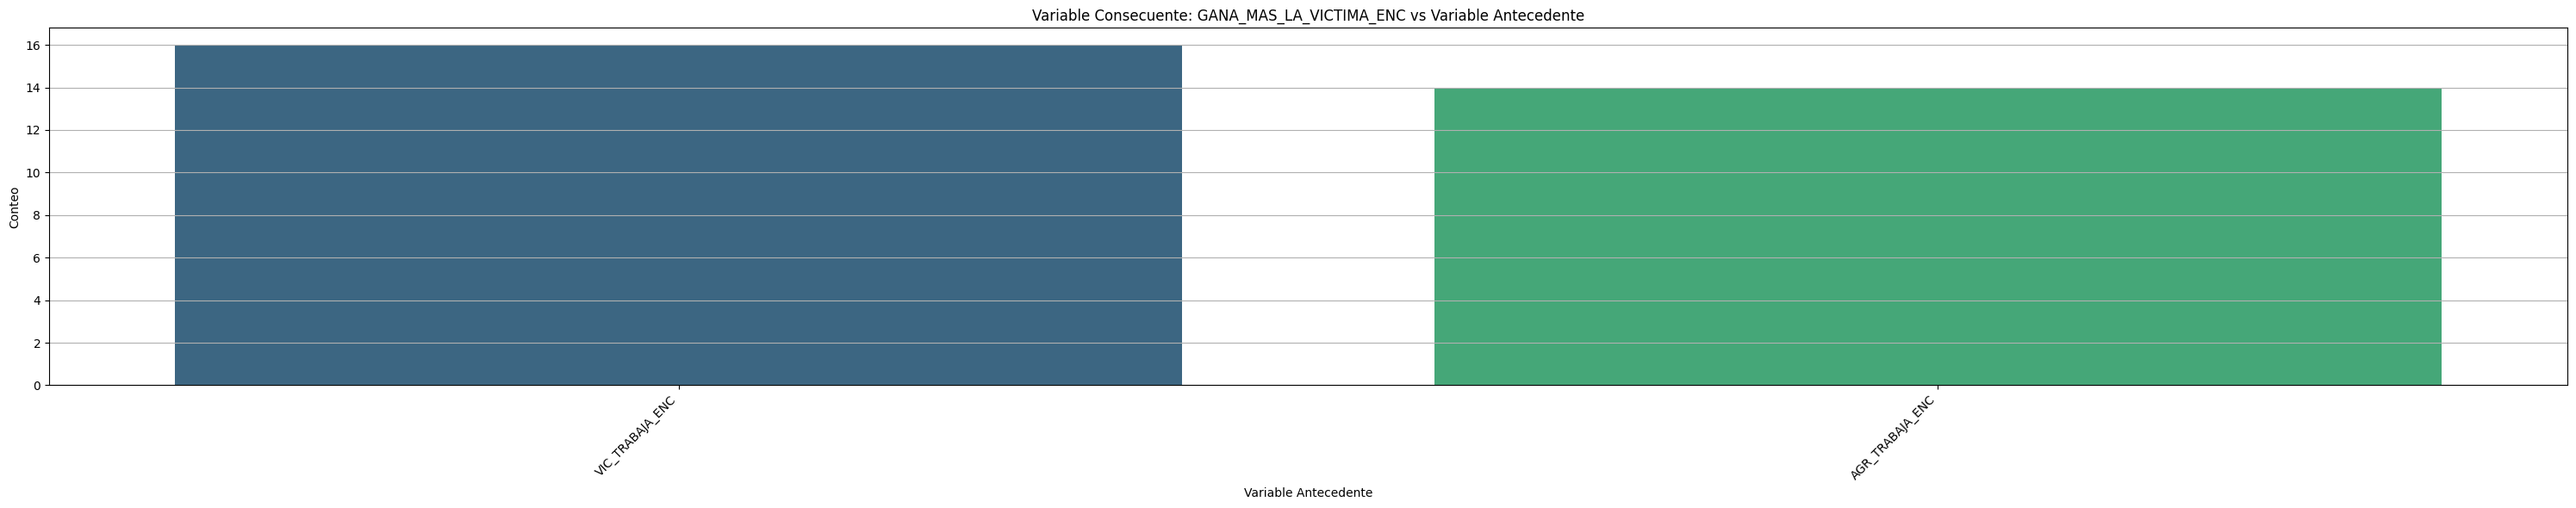

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


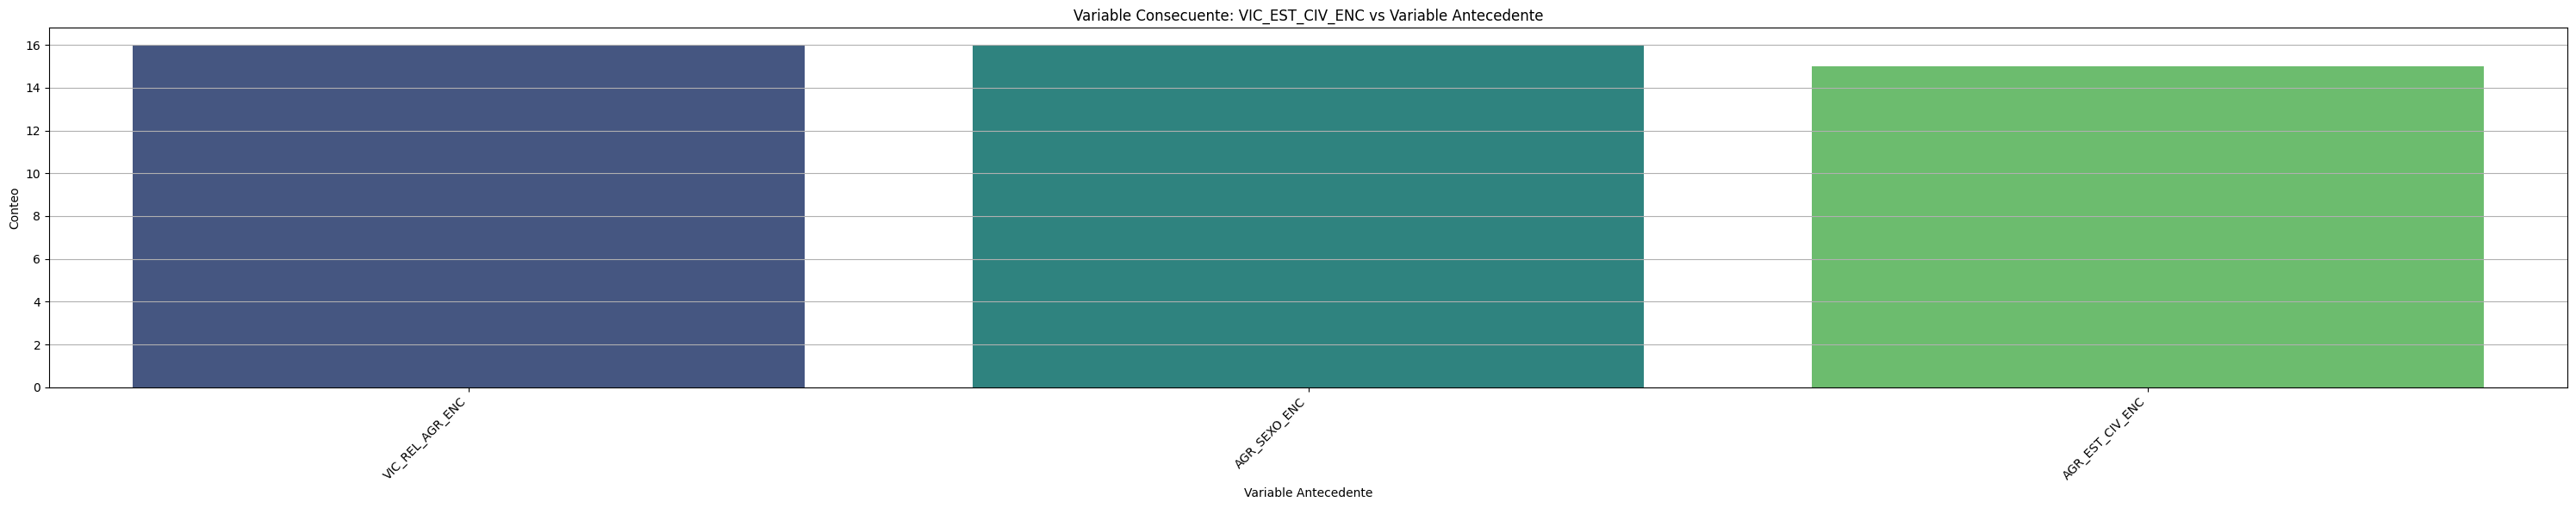

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


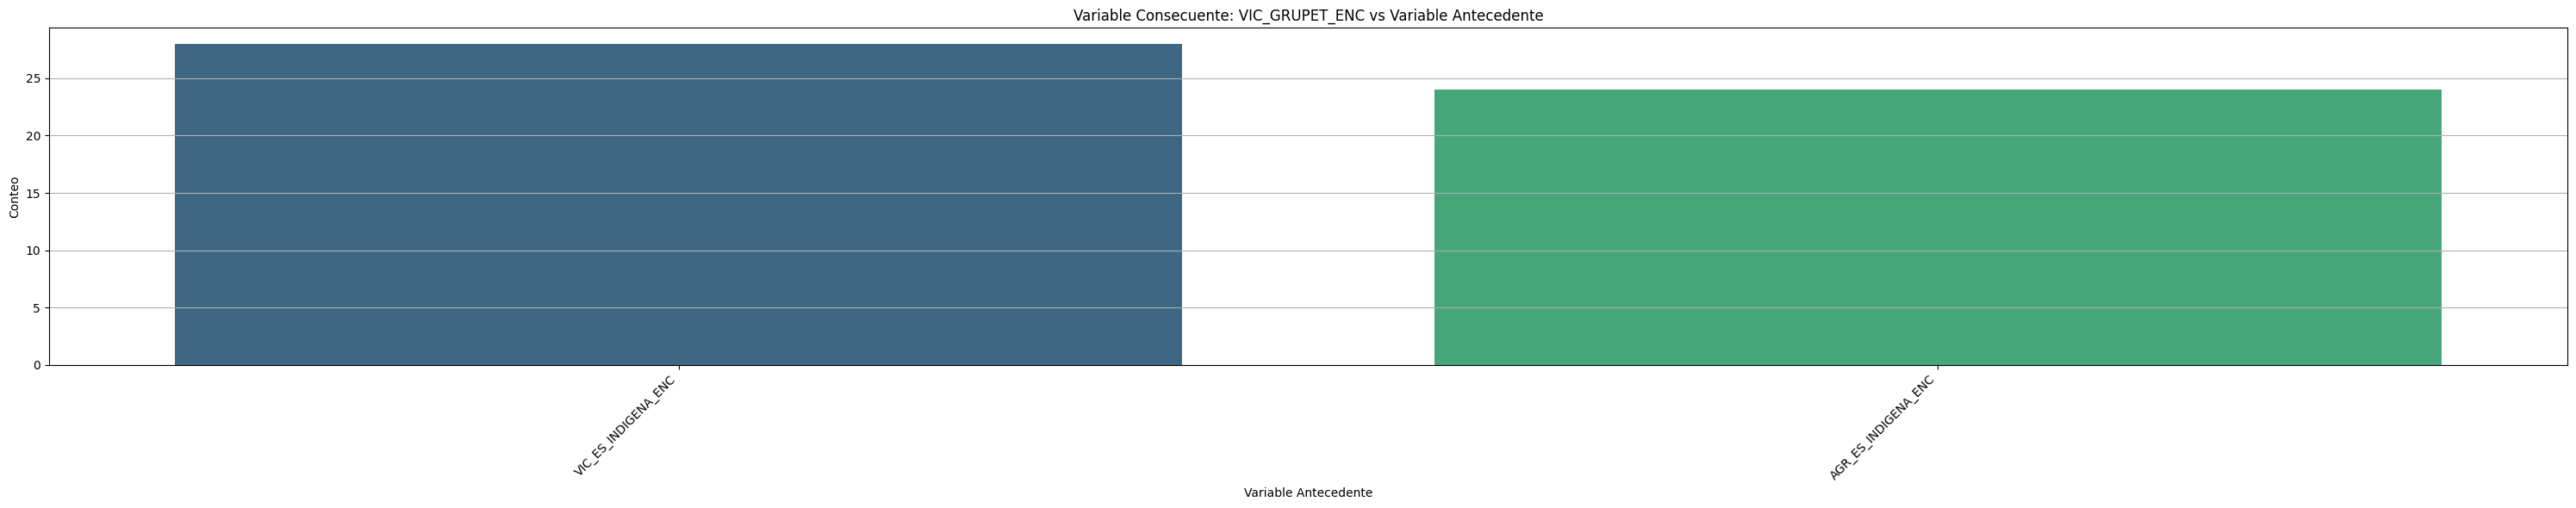

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


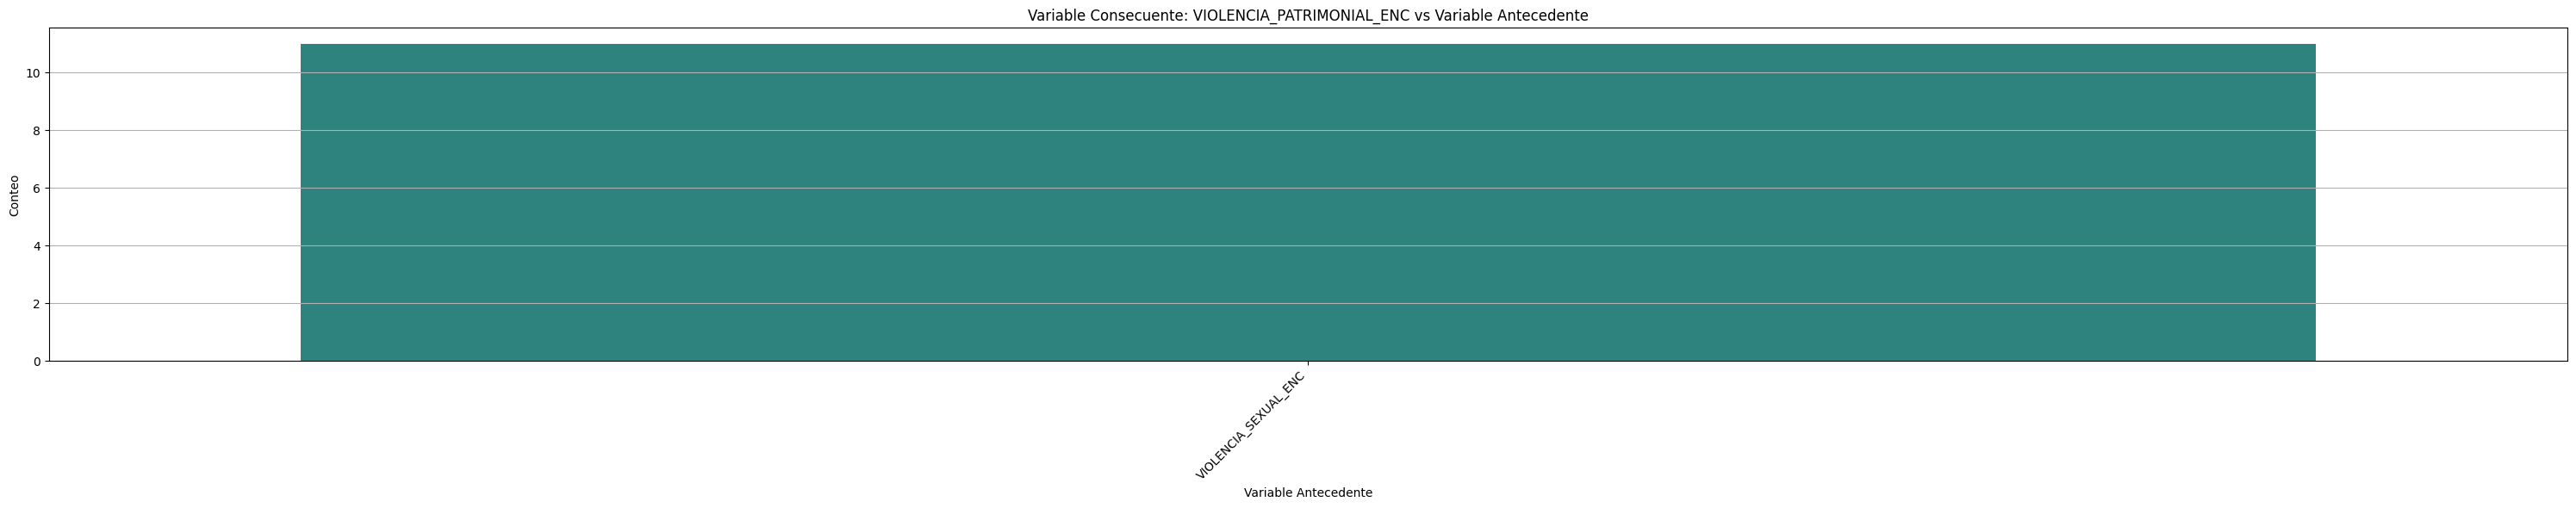

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


No results for AGR_OFICIO_ENC with count >= 10
No results for VIC_OFICIO_ENC with count >= 10


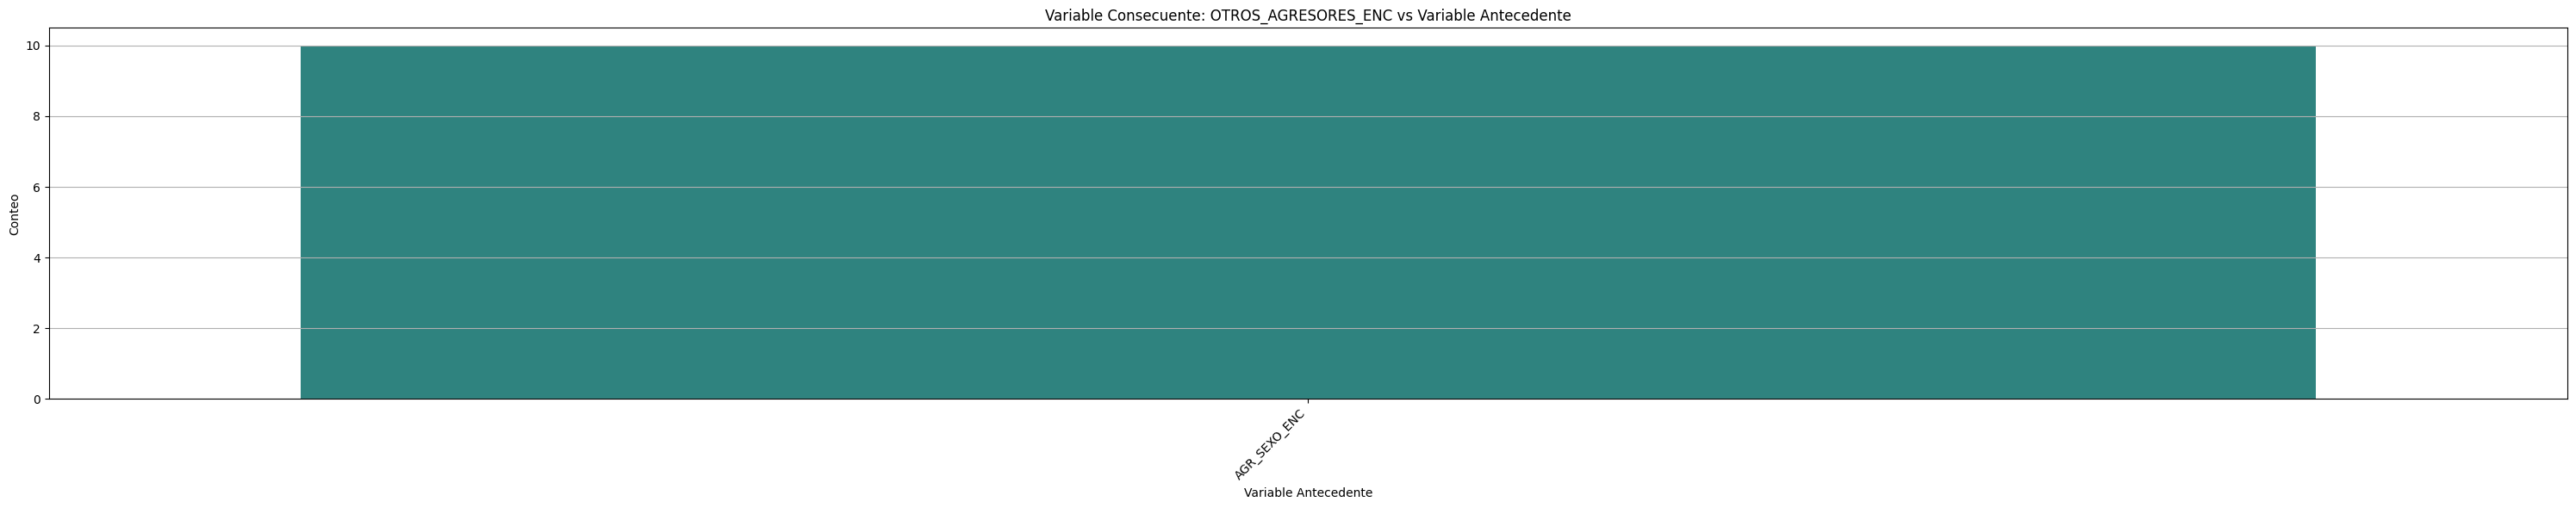

No results for VIC_RANGO_EDAD_ENC with count >= 10
No results for VIOLENCIA_PSICOLOGICA_ENC with count >= 10


In [23]:
analysis_graphs(df_apriori, y='VARIABLE_CONSECUENTE', x='VARIABLE_ANTECEDENTE')

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


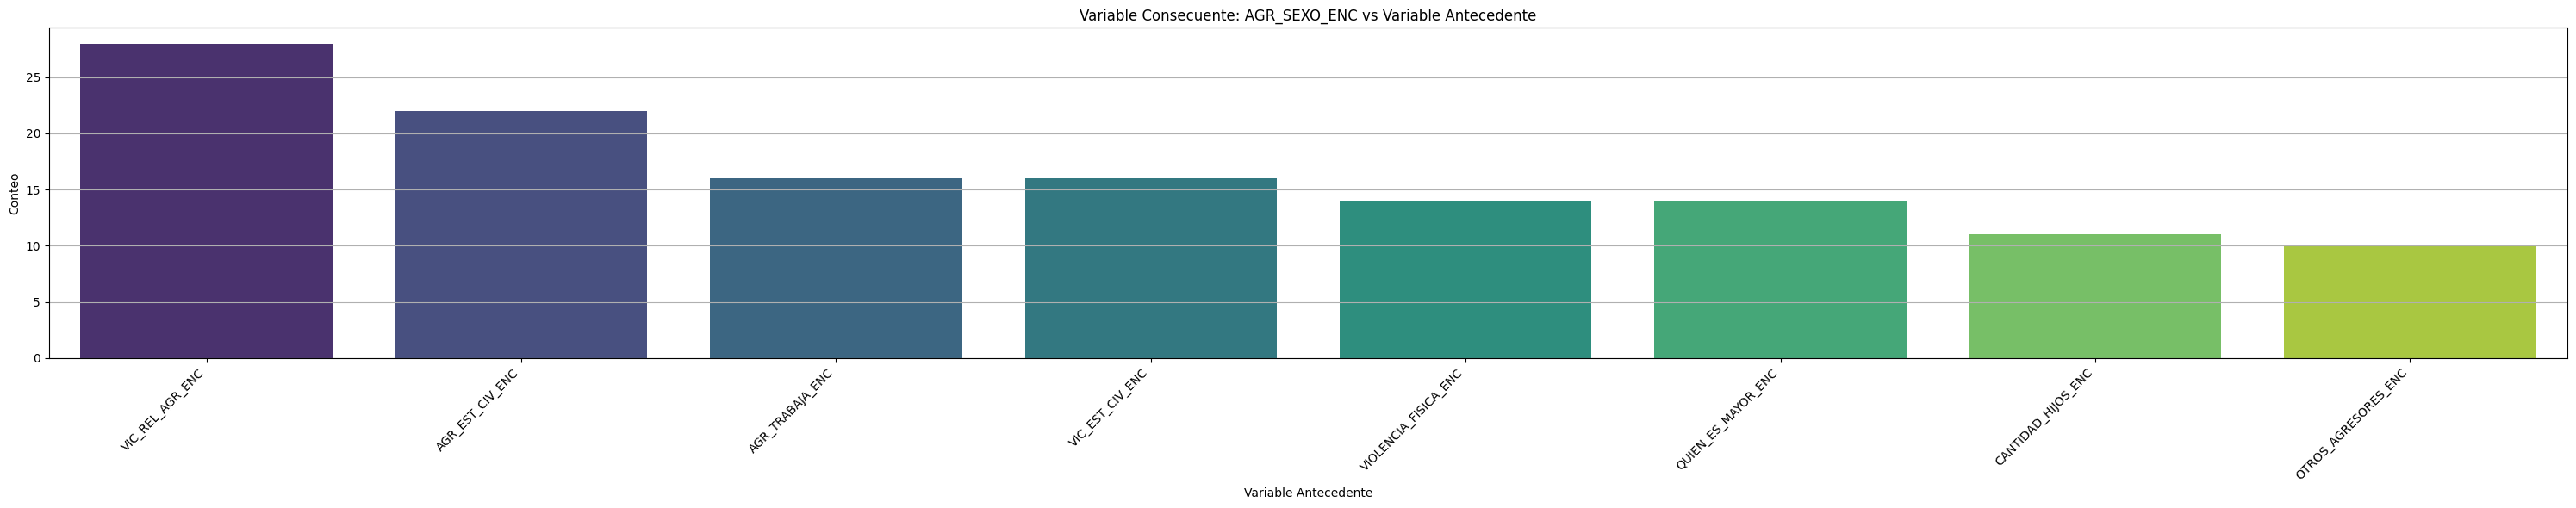

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


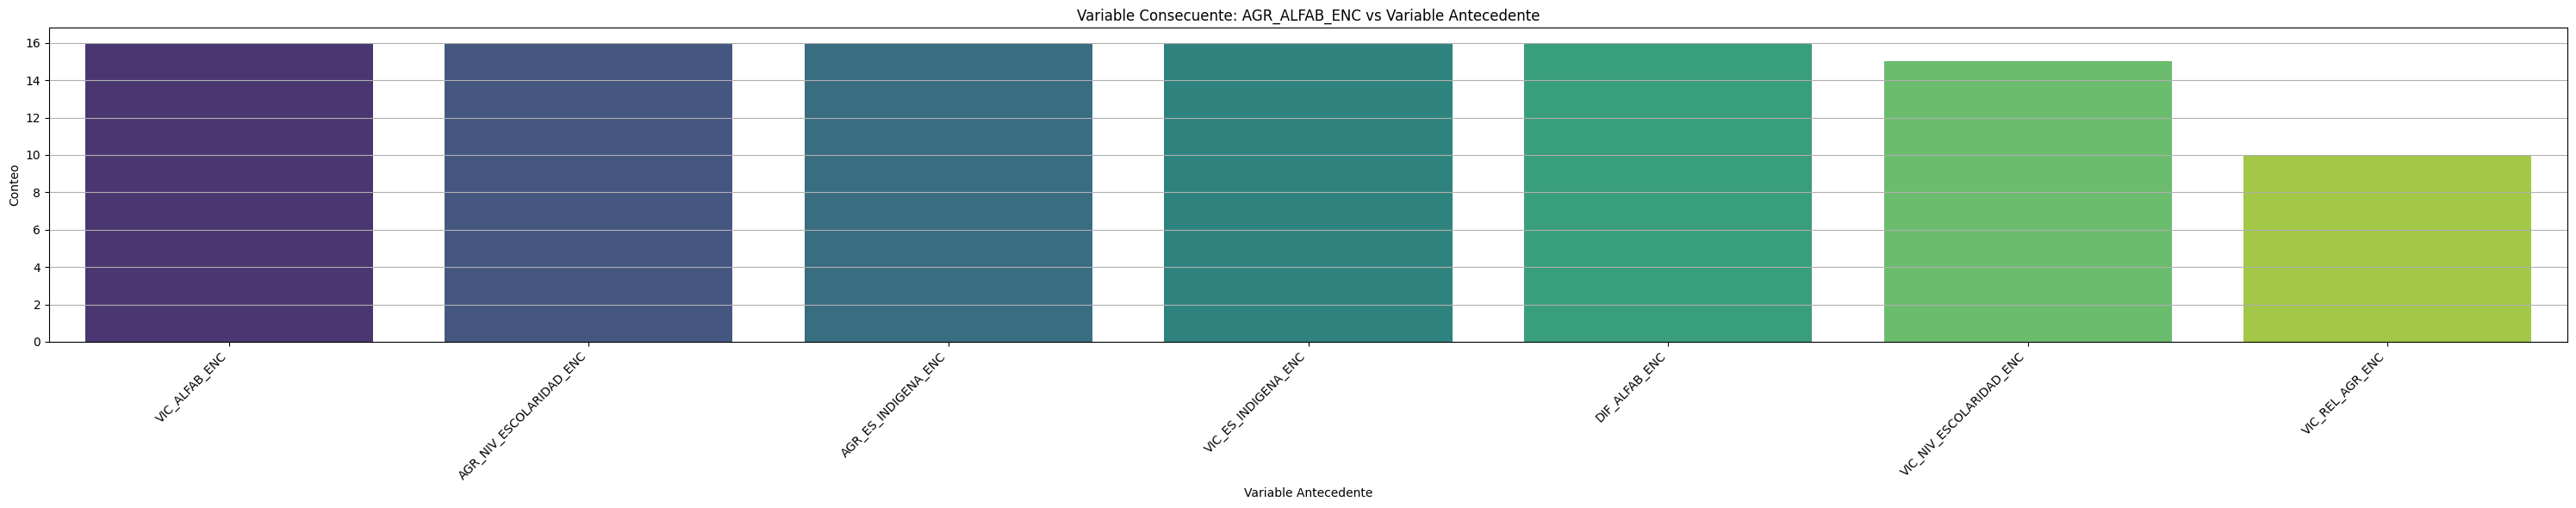

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


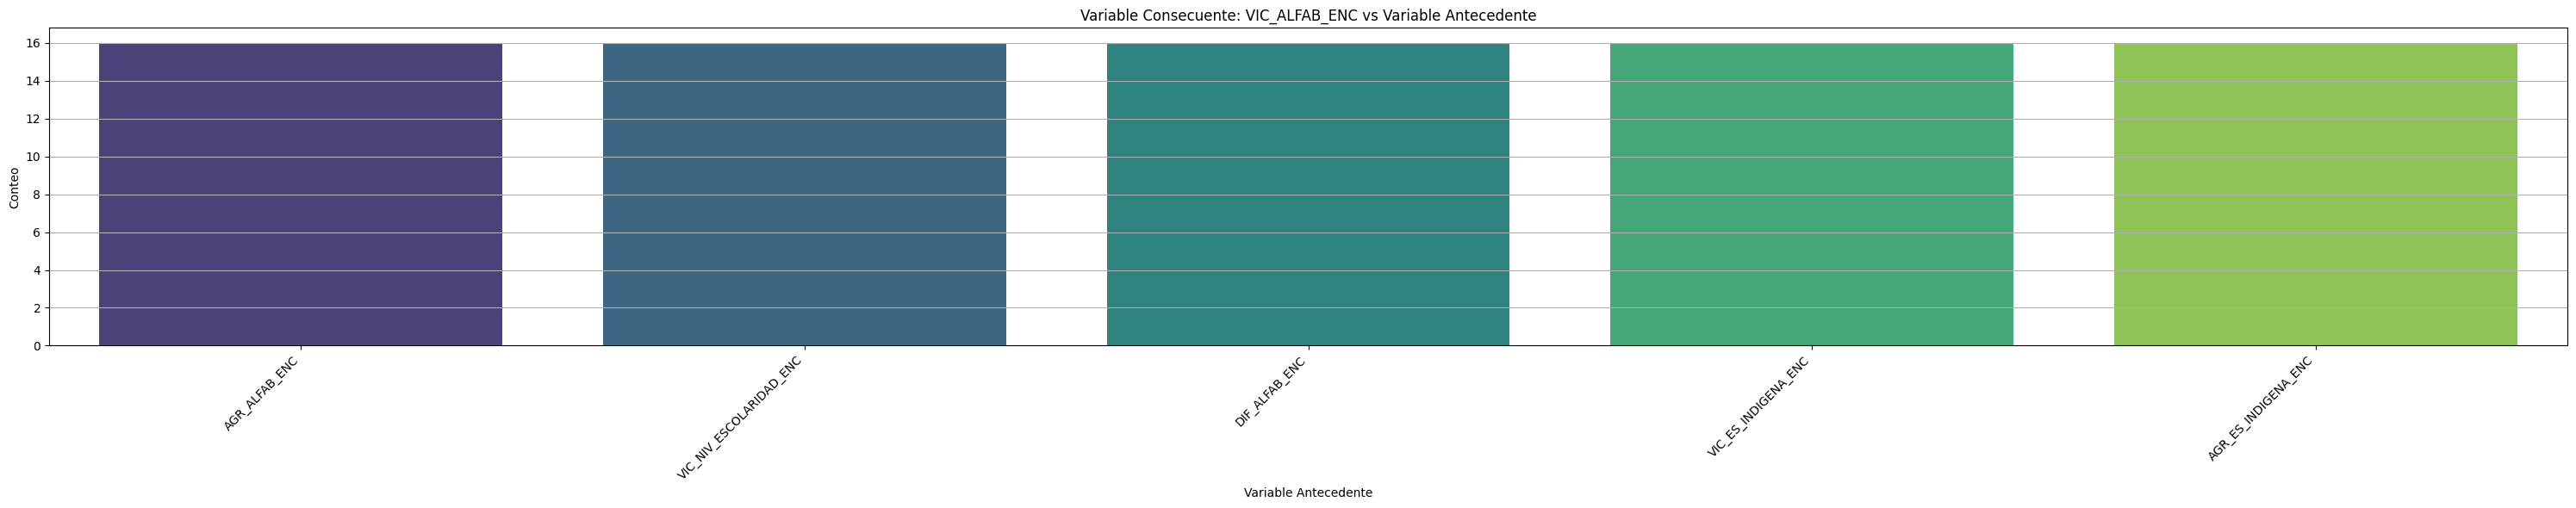

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


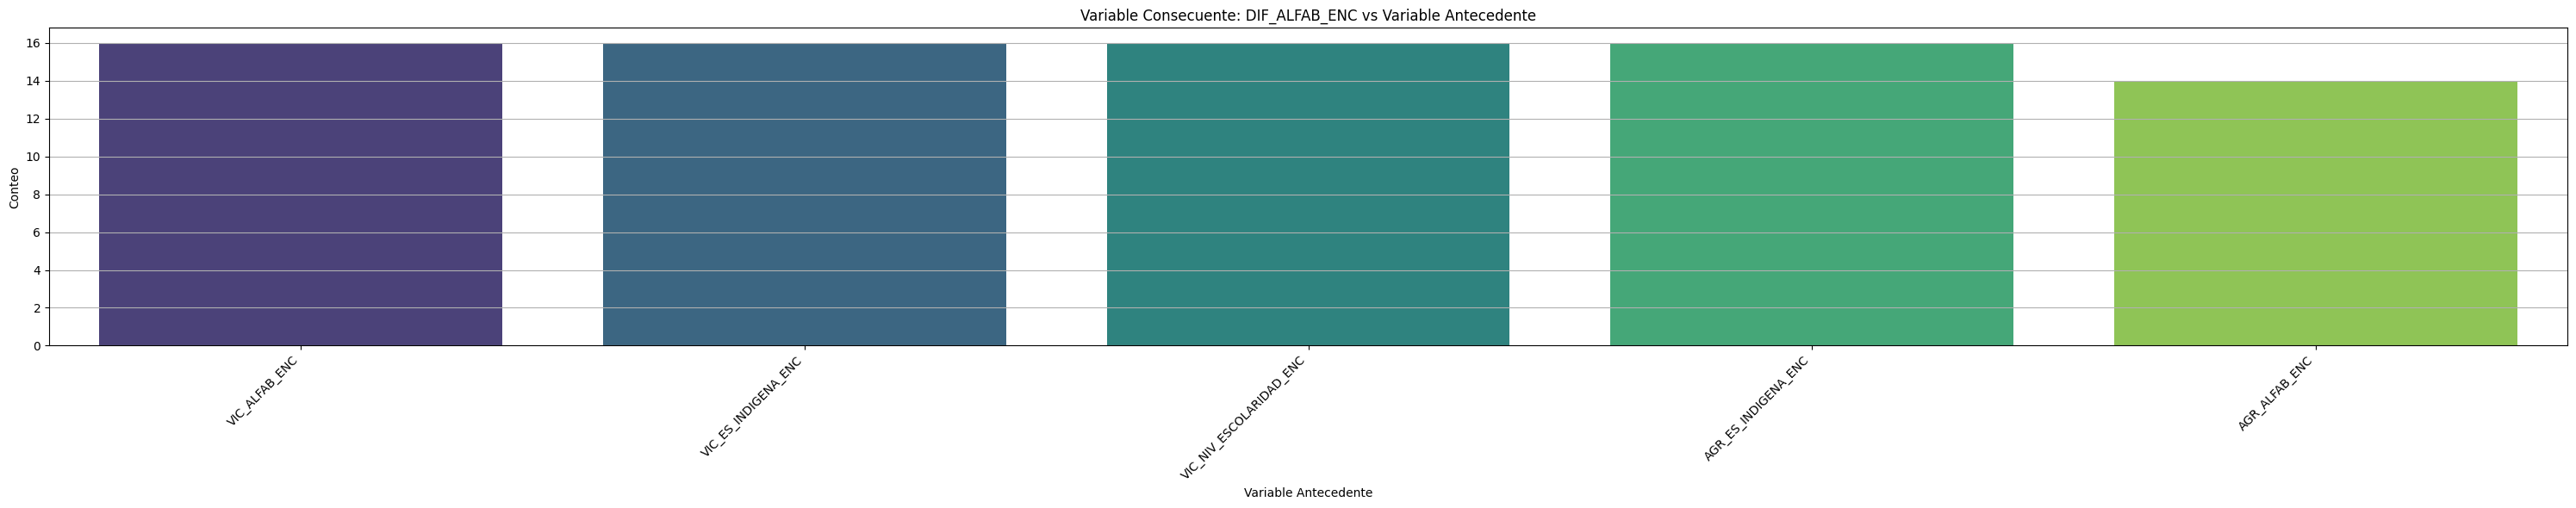

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


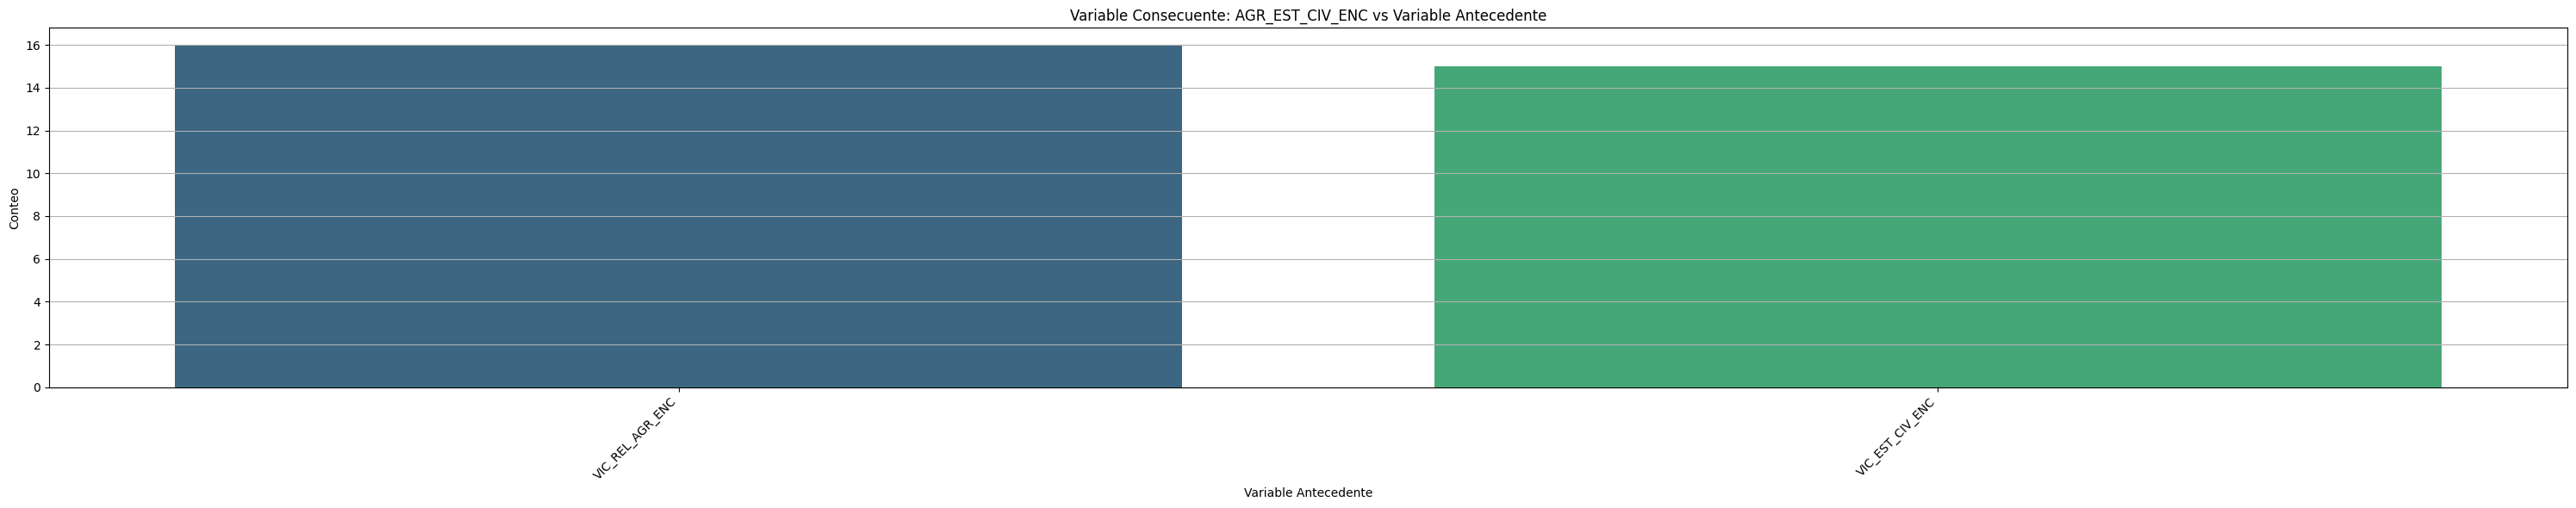

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


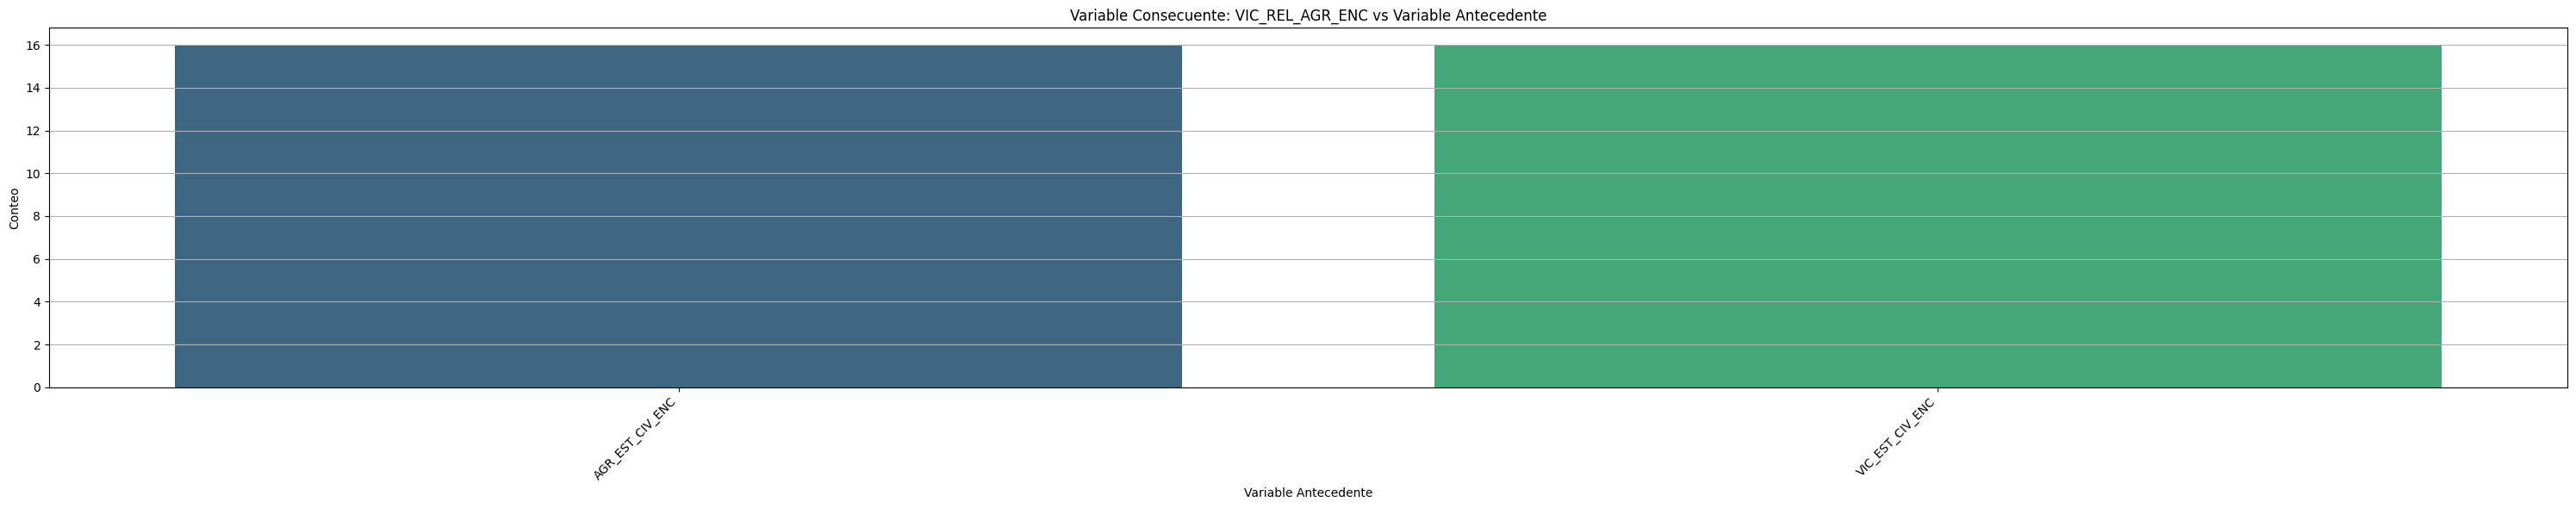

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


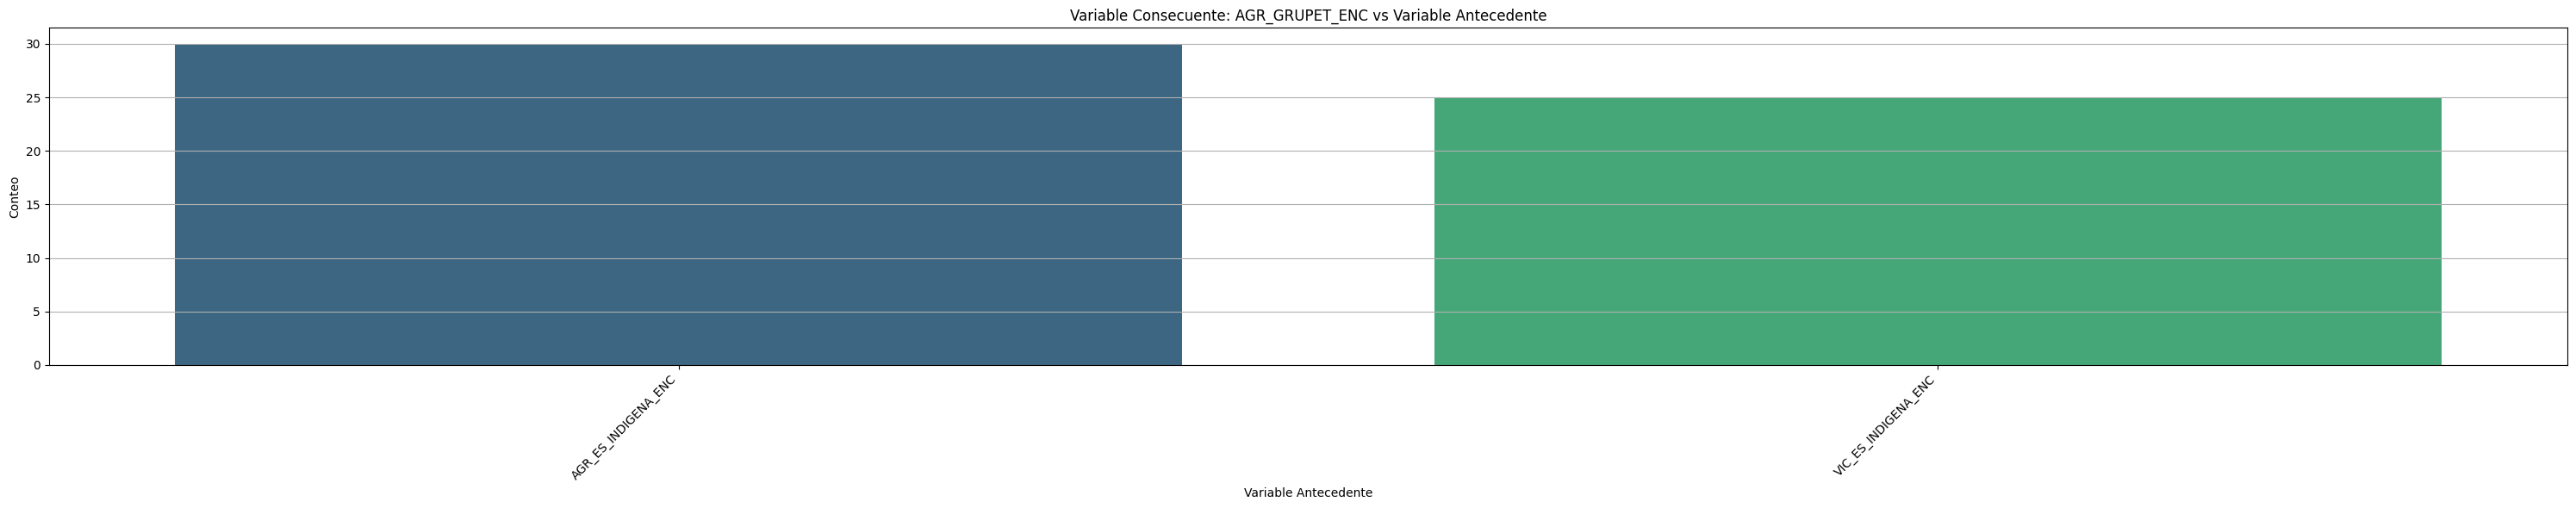

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


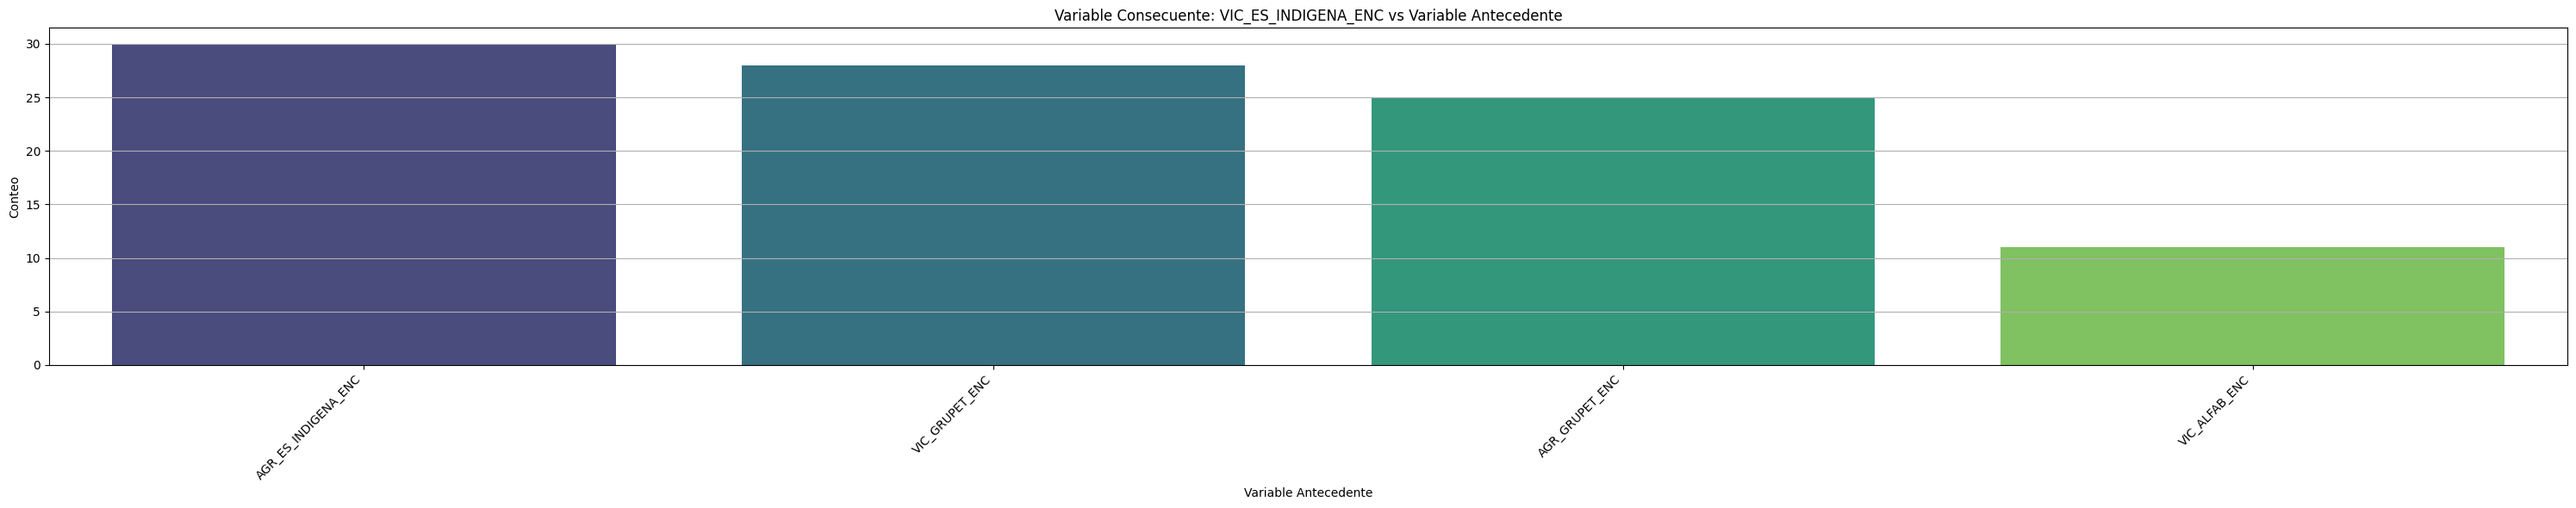

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


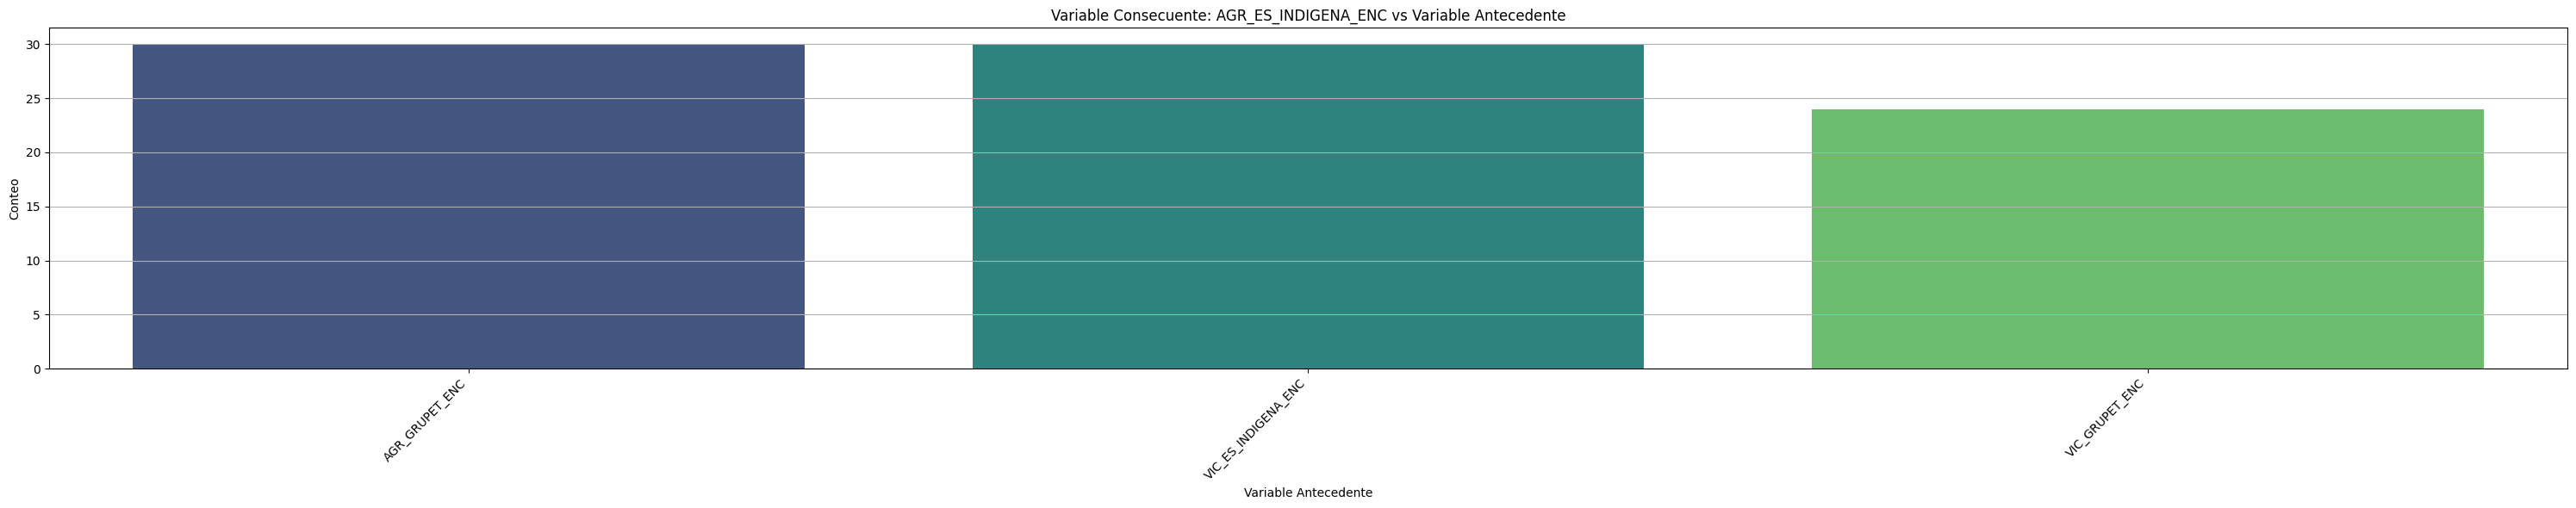

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


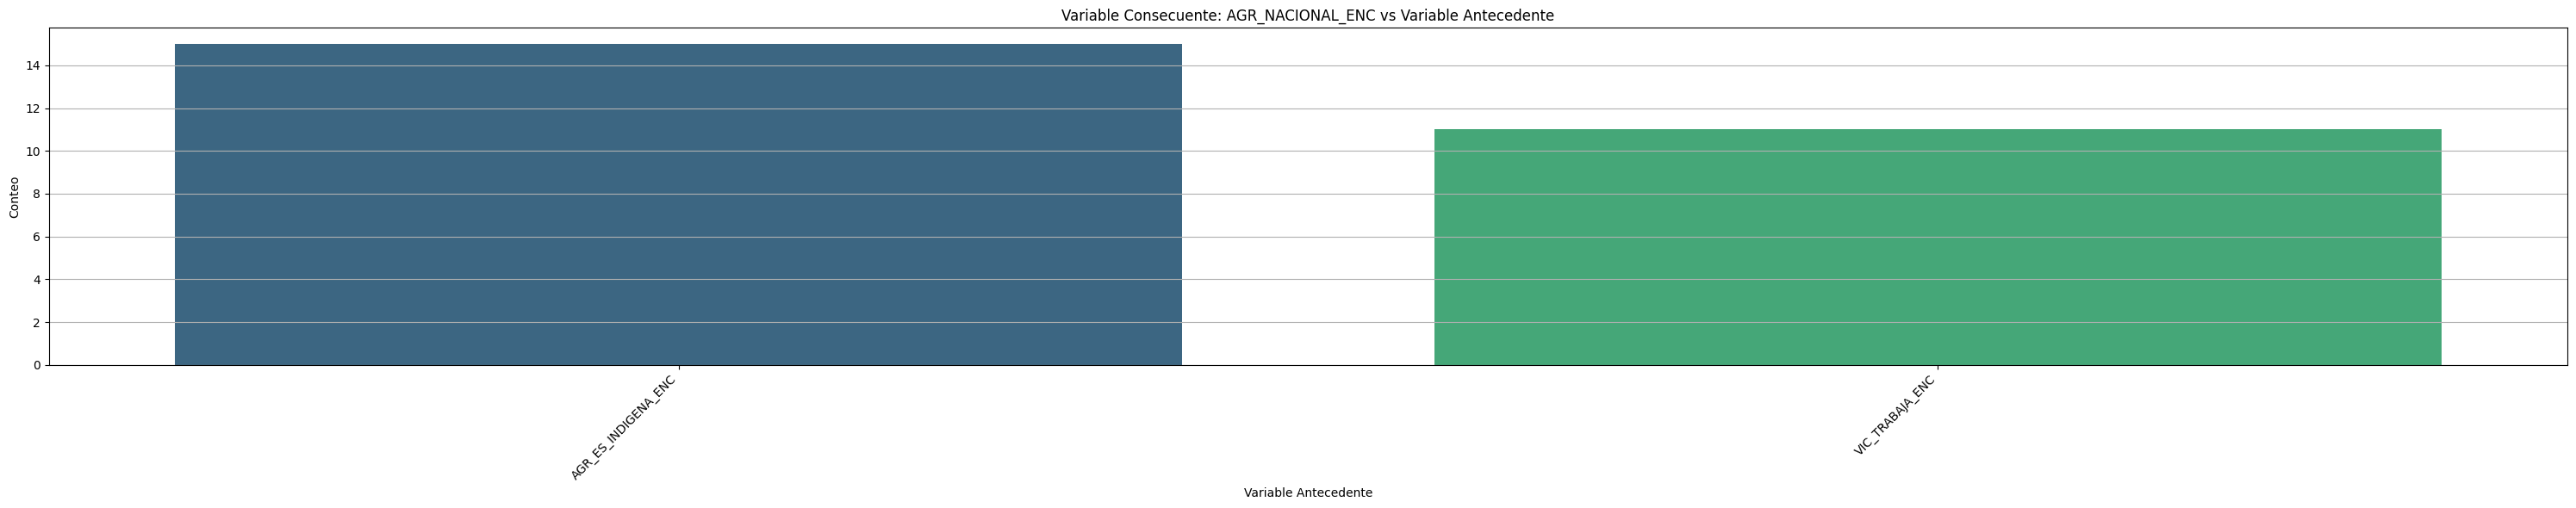

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


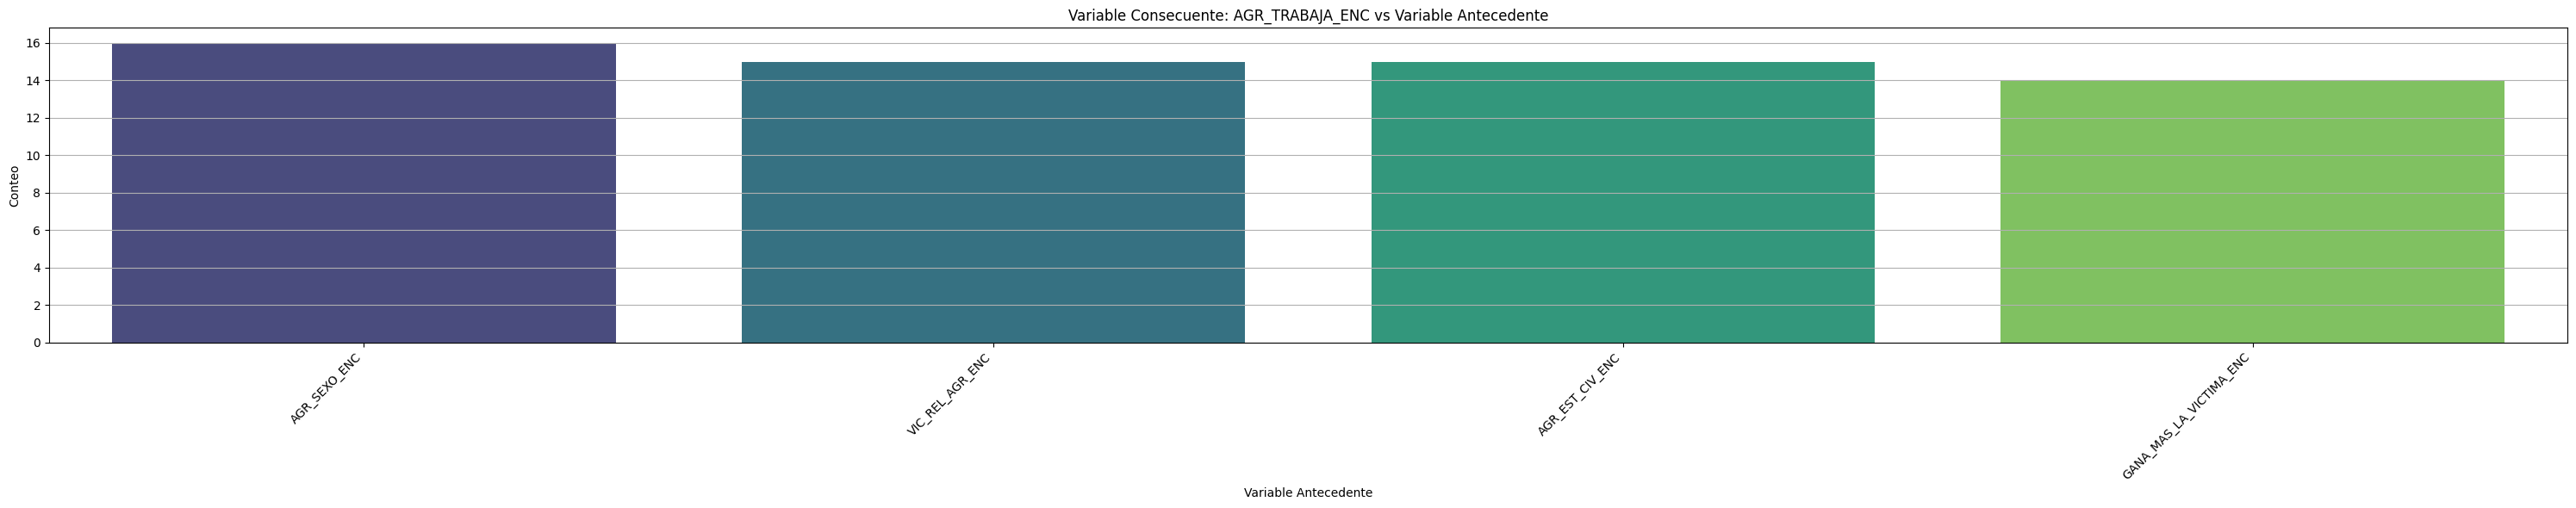

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


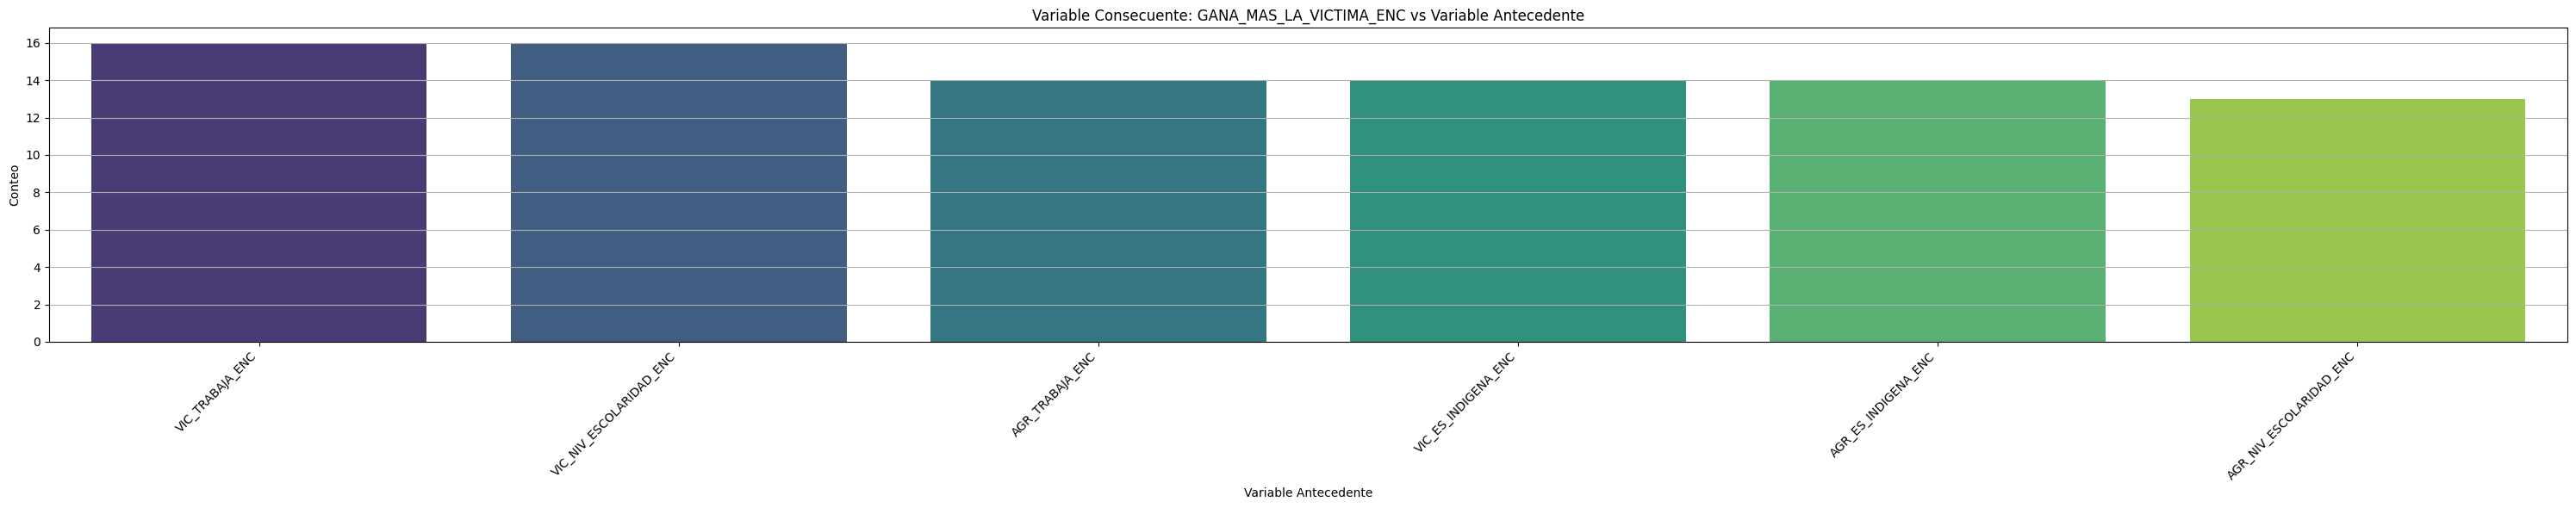

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


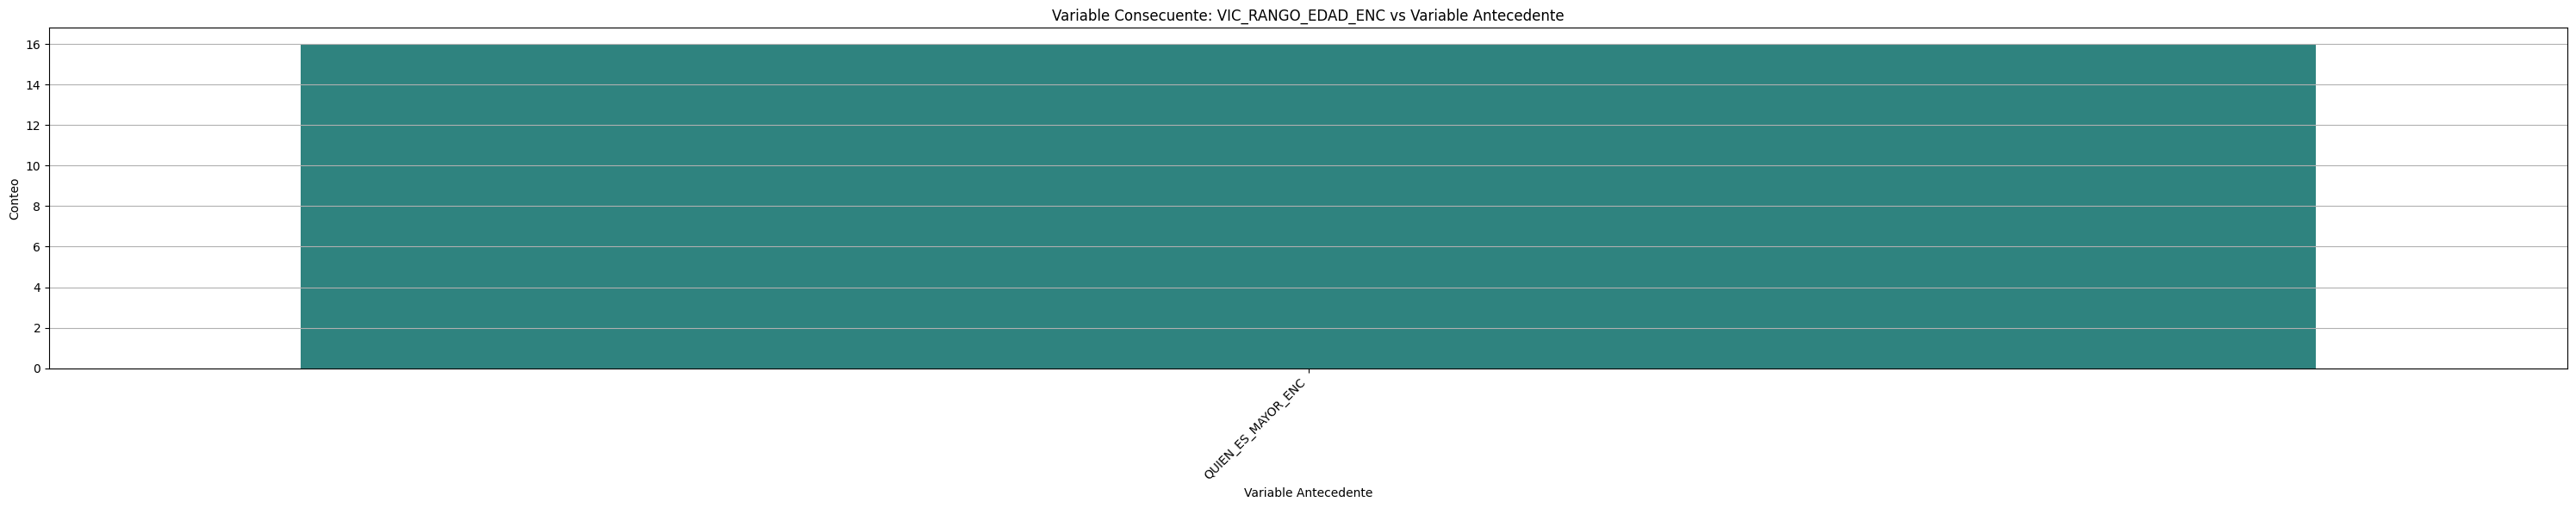

No results for VIC_DISC_ENC with count >= 10


C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


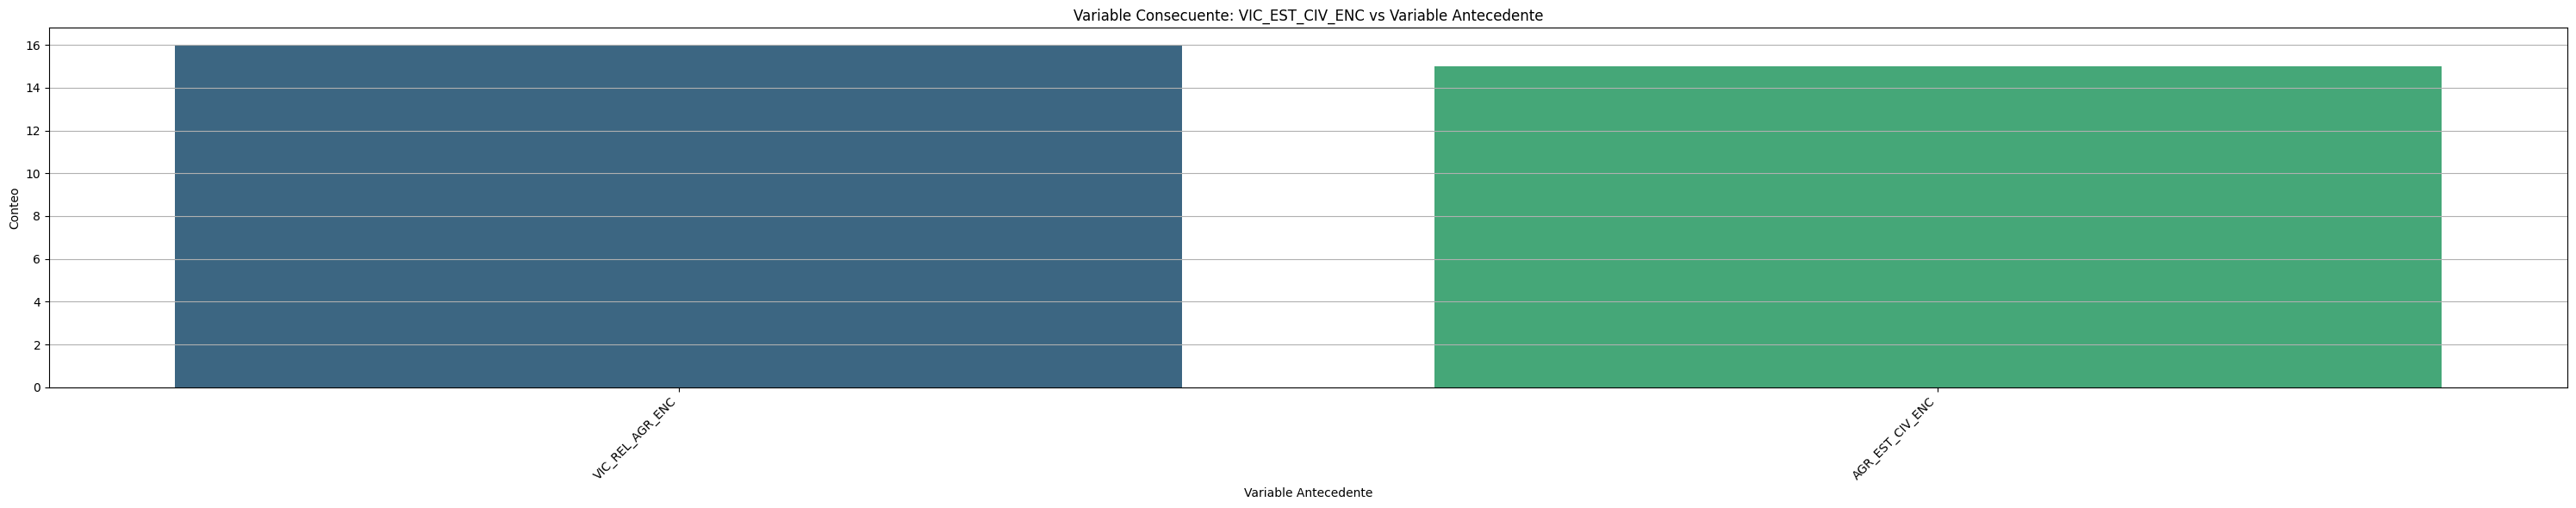

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


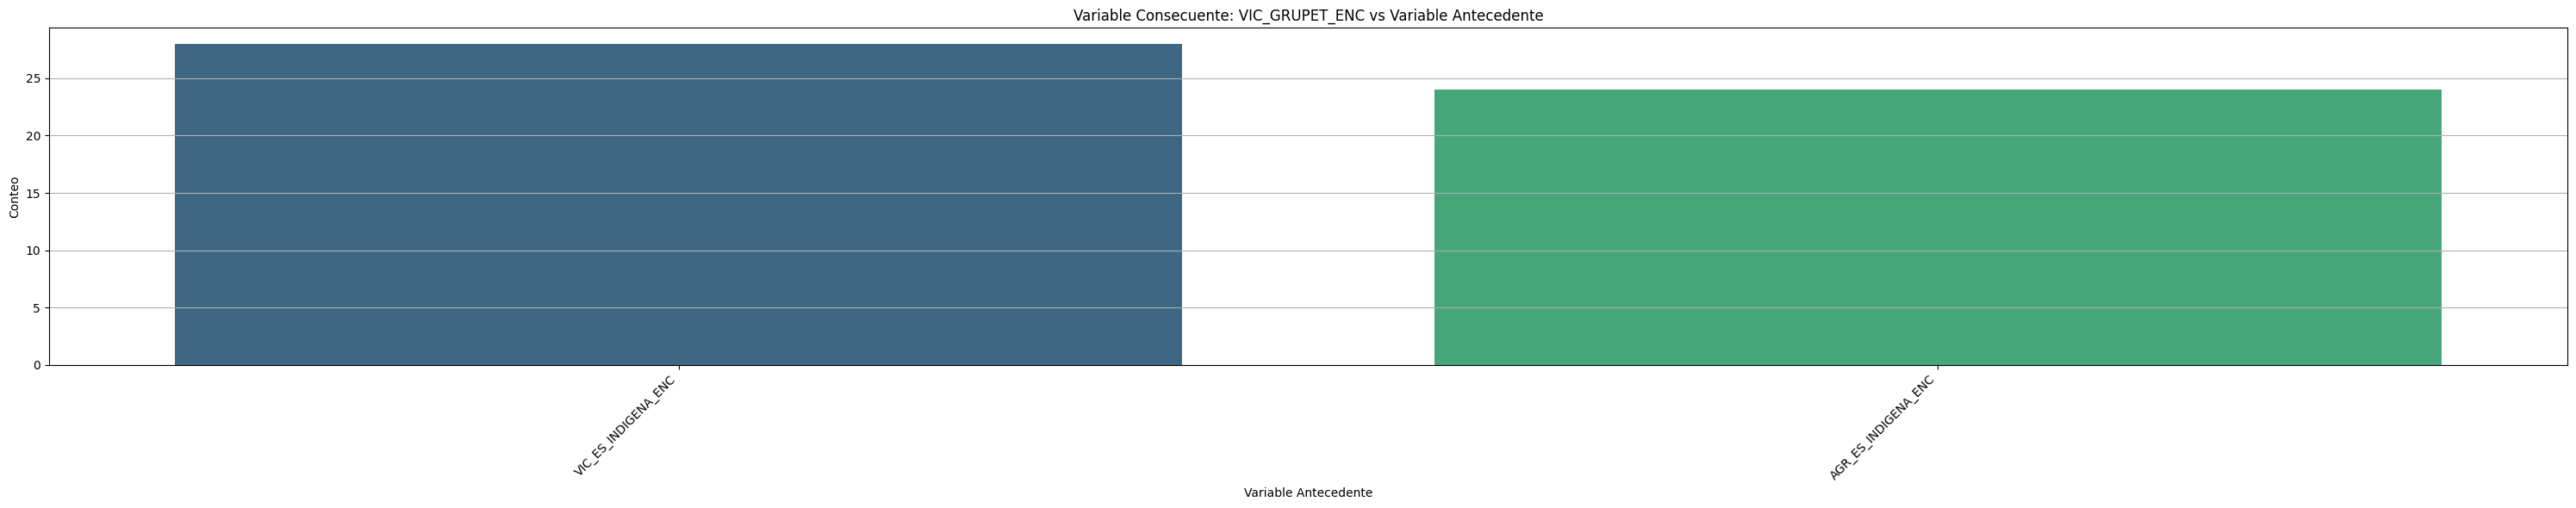

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


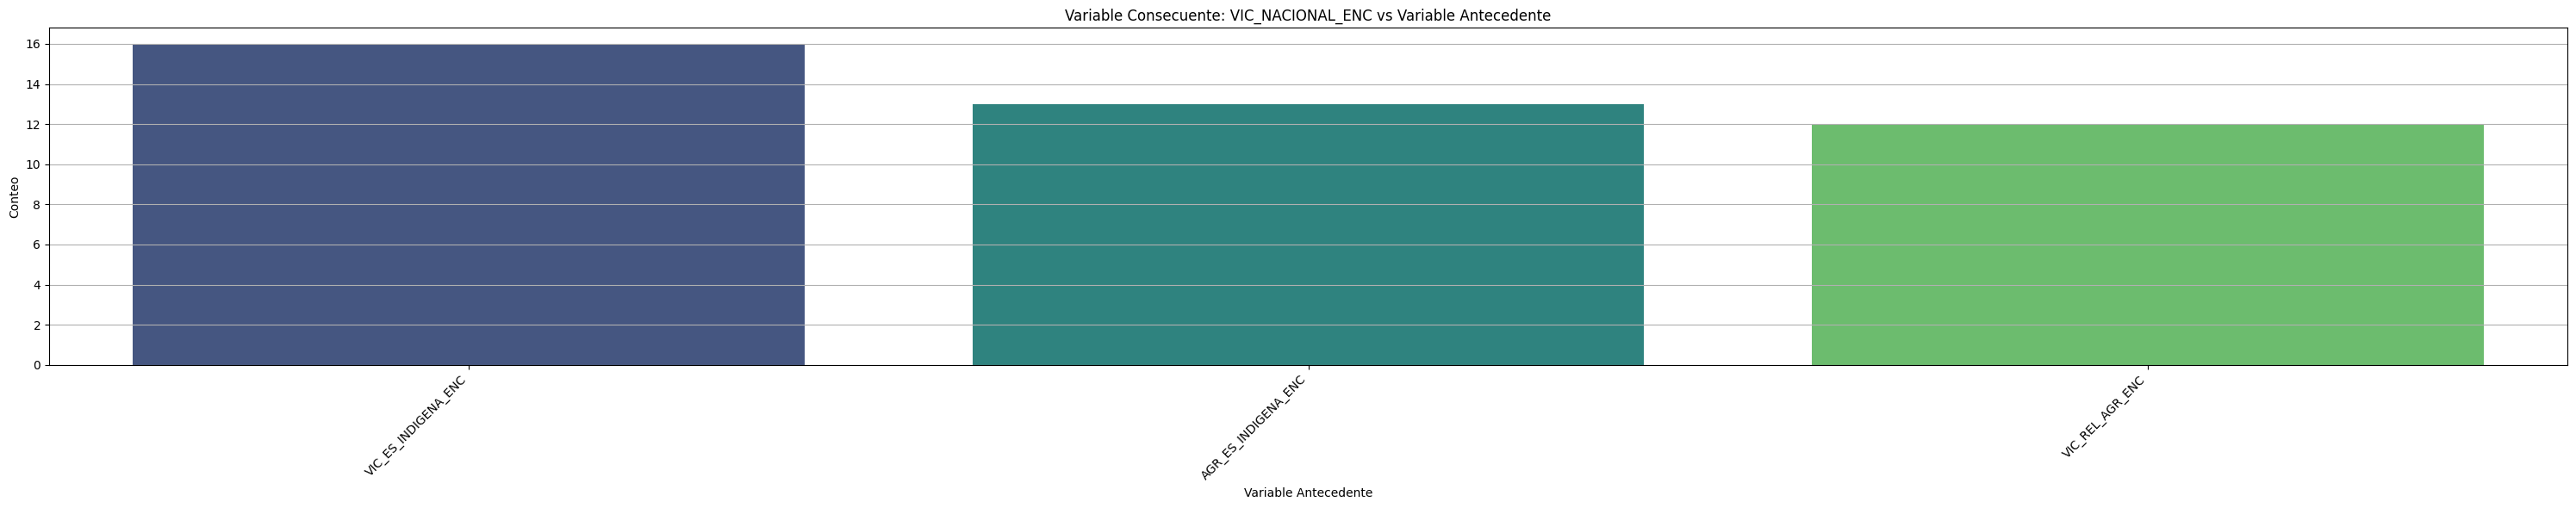

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


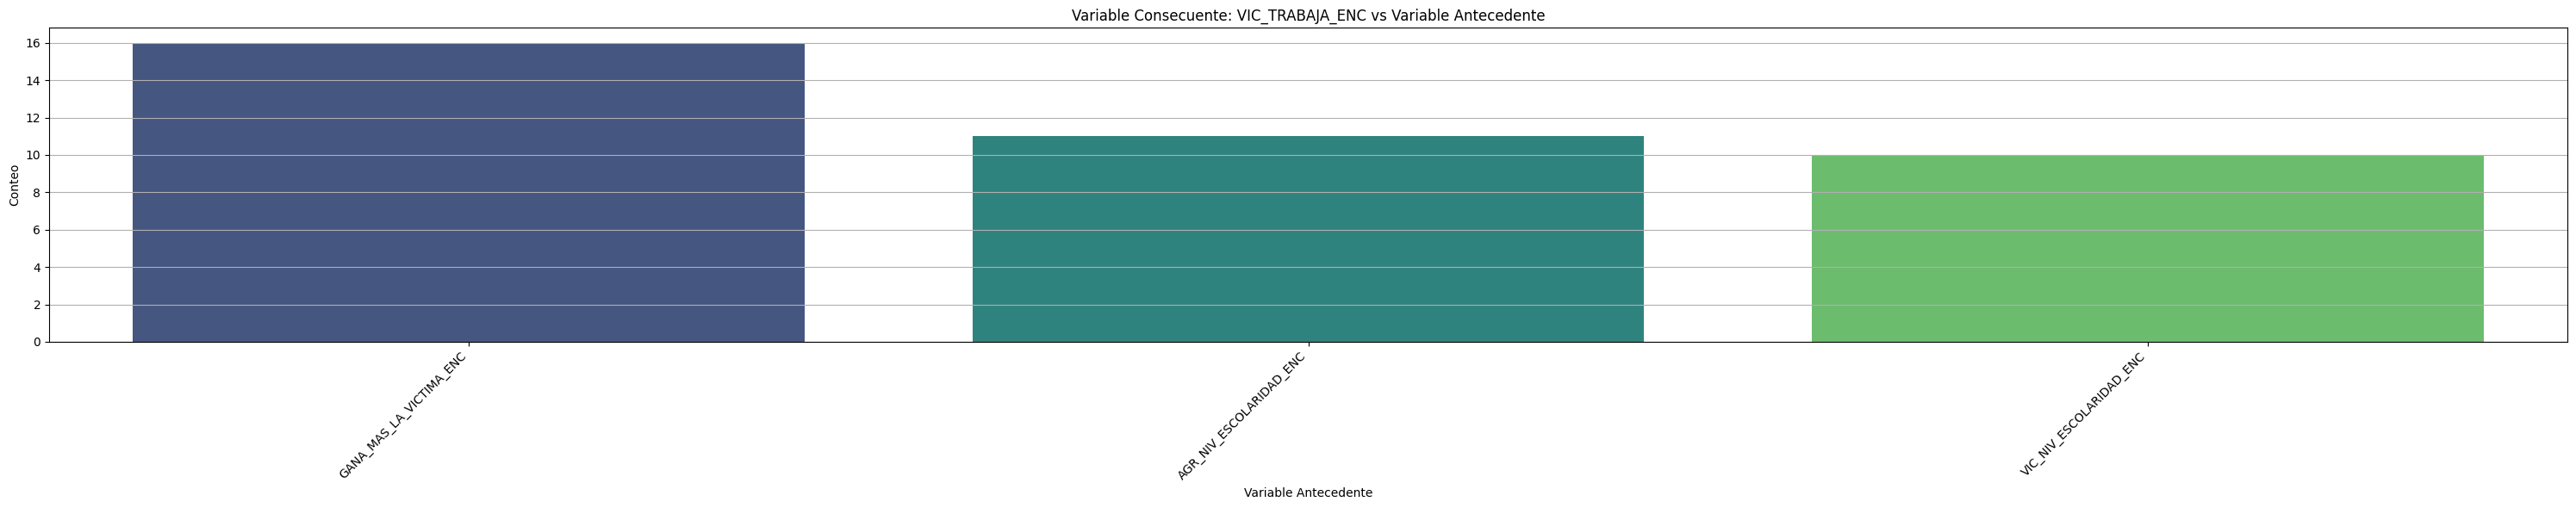

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


No results for AGR_NIV_ESCOLARIDAD_ENC with count >= 10
No results for VIC_NIV_ESCOLARIDAD_ENC with count >= 10


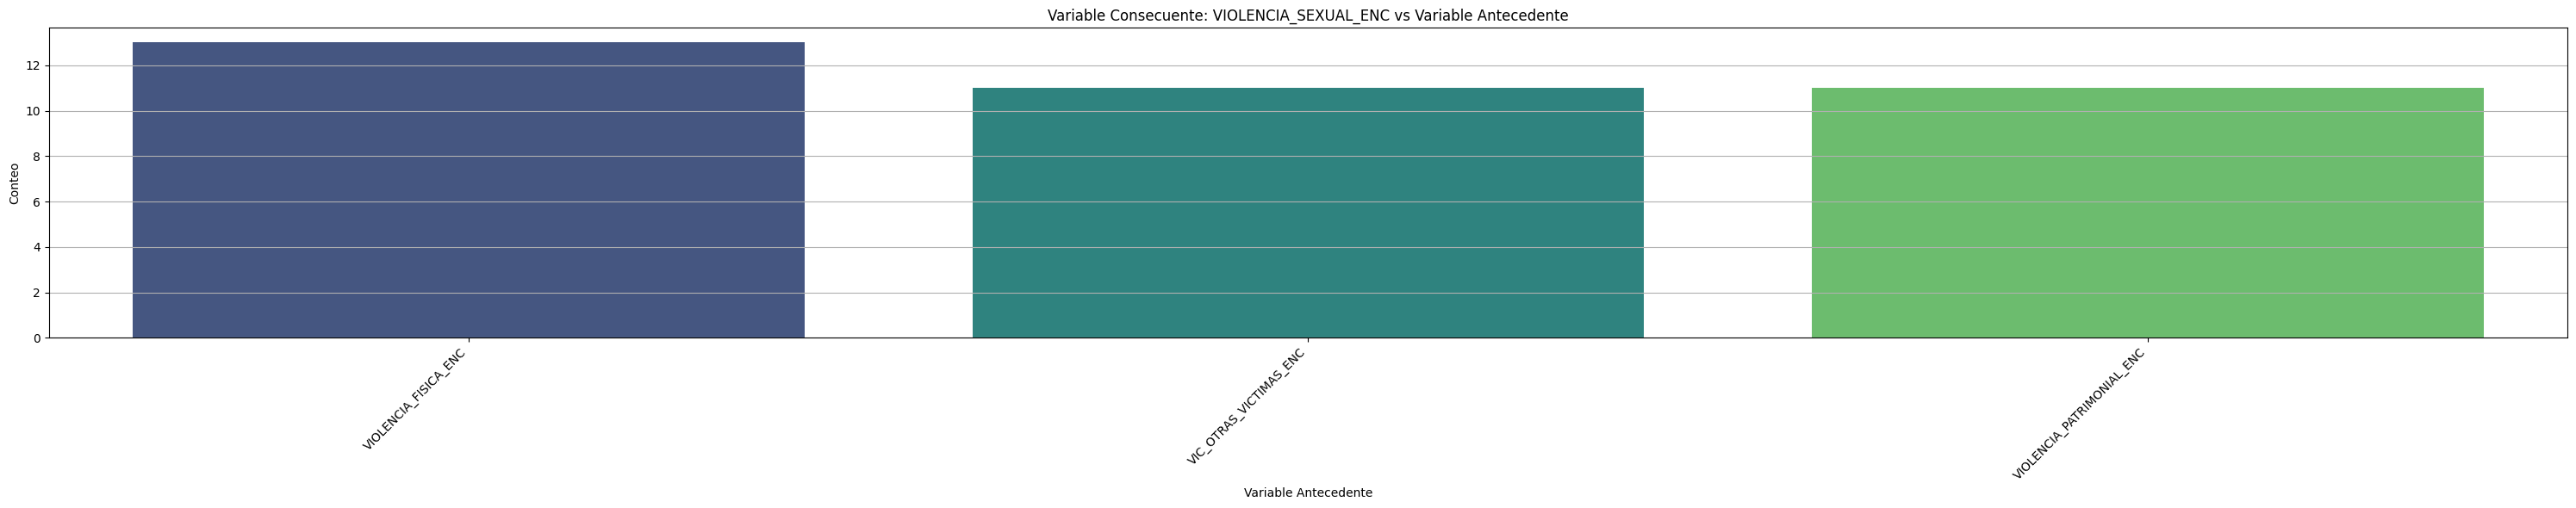

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


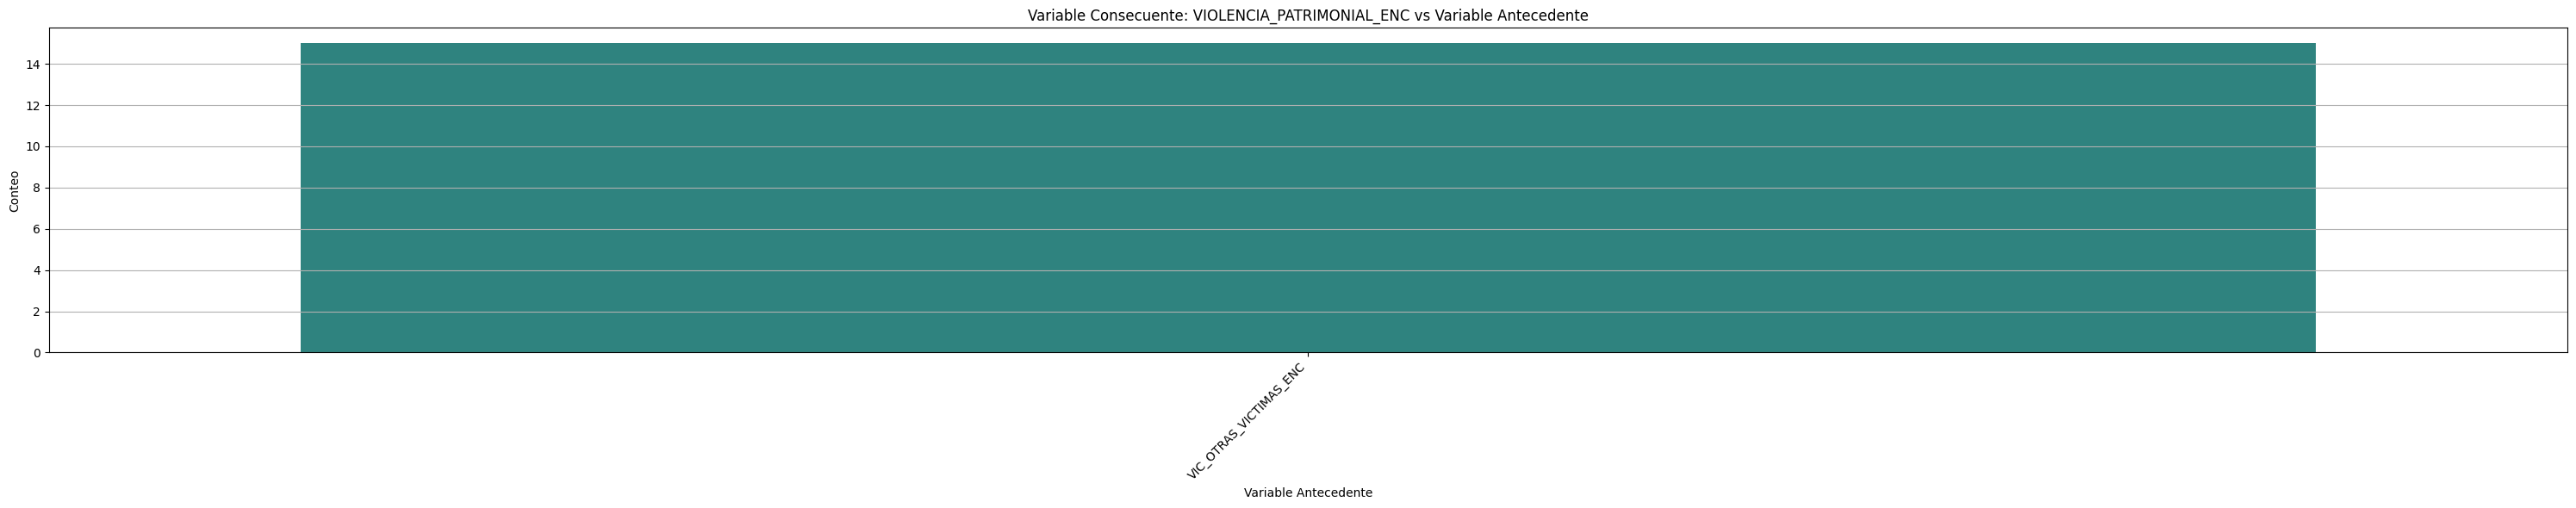

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


No results for VIC_OFICIO_ENC with count >= 10


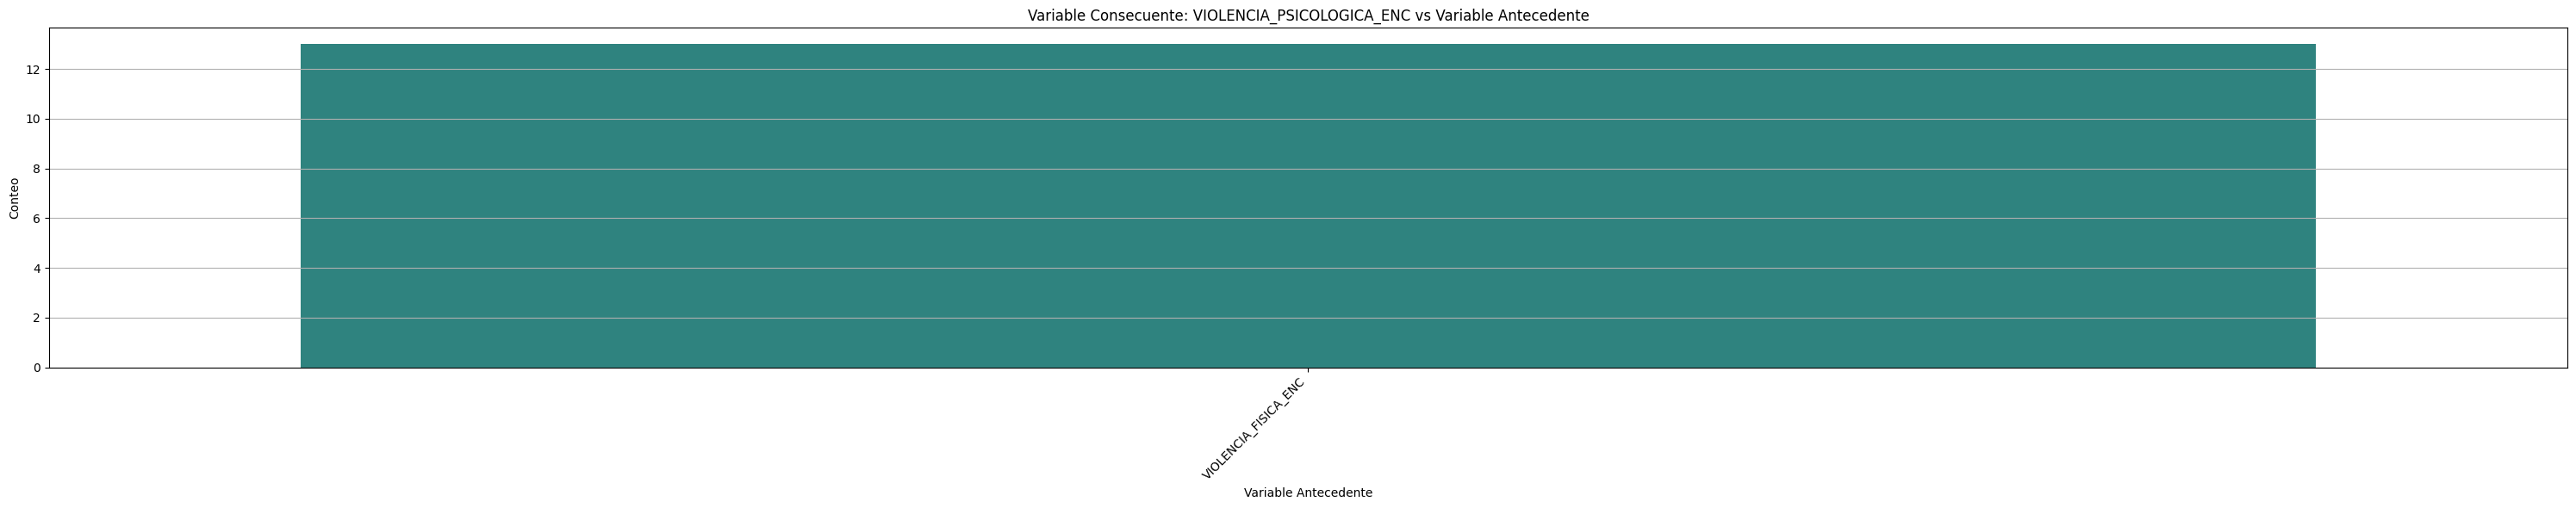

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


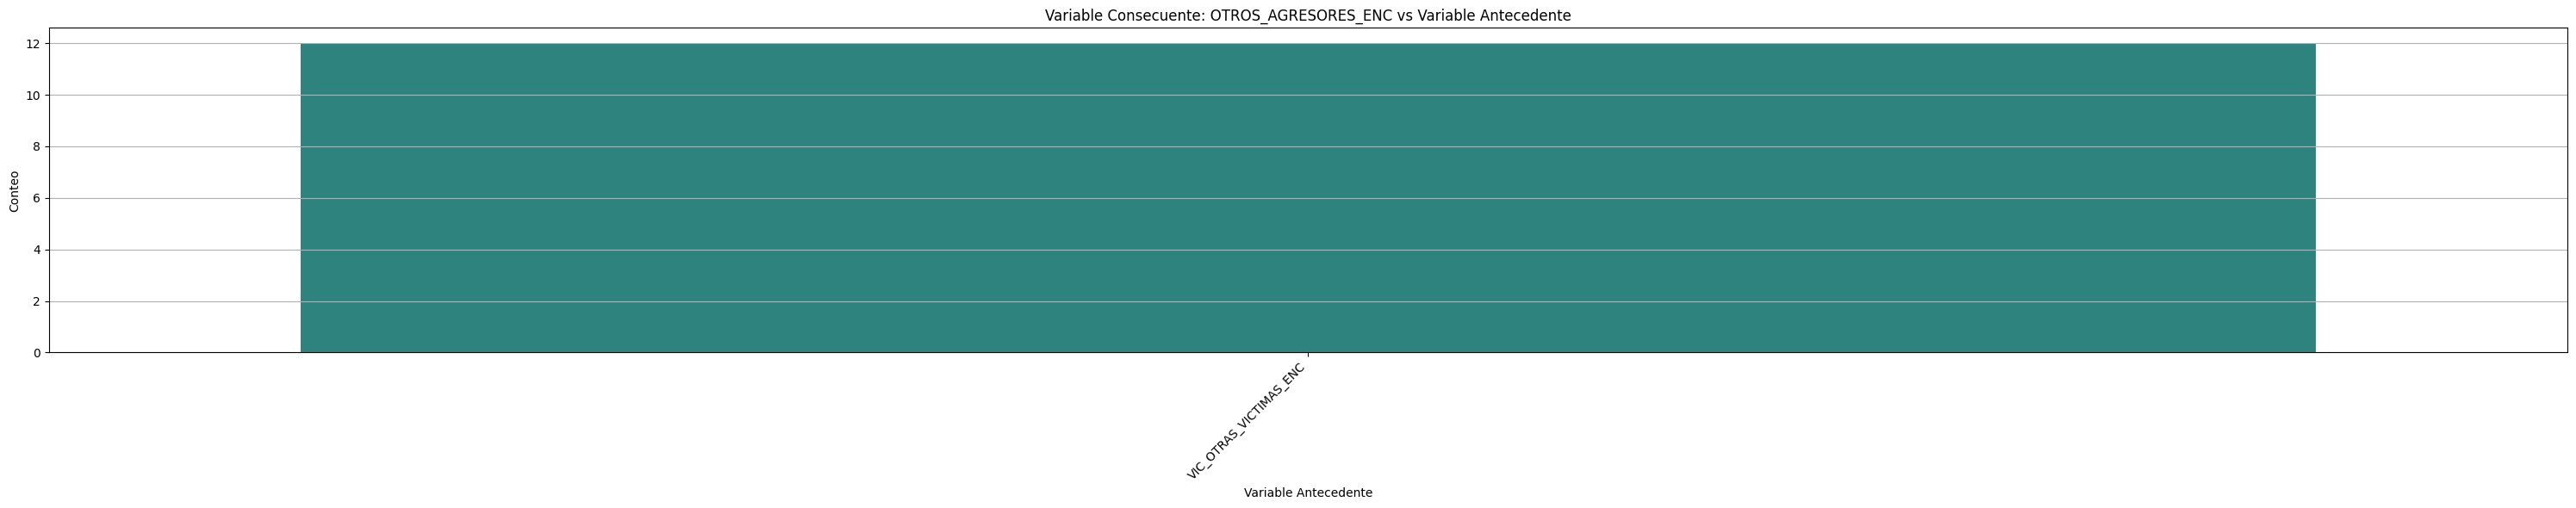

No results for VIC_OTRAS_VICTIMAS_ENC with count >= 10
No results for QUIEN_ES_MAYOR_ENC with count >= 10


In [24]:
analysis_graphs(df_apriori)

## Analysis for women data

### Show which relationships are strong bonded

In [25]:
df_mujer[['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE']].value_counts()

VARIABLE_ANTECEDENTE       VARIABLE_CONSECUENTE     
AGR_ES_INDIGENA_ENC        AGR_GRUPET_ENC               30
                           VIC_ES_INDIGENA_ENC          30
AGR_GRUPET_ENC             AGR_ES_INDIGENA_ENC          30
VIC_ES_INDIGENA_ENC        AGR_ES_INDIGENA_ENC          30
                           VIC_GRUPET_ENC               28
                                                        ..
VIC_TRABAJA_ENC            VIC_OFICIO_ENC                1
VIOLENCIA_FISICA_ENC       AGR_ALFAB_ENC                 1
VIC_TRABAJA_ENC            VIOLENCIA_PSICOLOGICA_ENC     1
VIOLENCIA_FISICA_ENC       VIC_NACIONAL_ENC              1
VIOLENCIA_PSICOLOGICA_ENC  VIOLENCIA_SEXUAL_ENC          1
Name: count, Length: 169, dtype: int64

In [26]:
counts = df_mujer[['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE']].value_counts().reset_index()
valid_counts = counts[counts['count']>=MIN_AMOUNT_REPETITIONS]

In [27]:
variables_validas_threshold = pd.concat([
    valid_counts['VARIABLE_ANTECEDENTE'],
    valid_counts['VARIABLE_CONSECUENTE']
]).unique()

In [28]:
df_apriori_chi.columns

Index(['division', 'year', 'orig_col_a', 'orig_col_b', 'col_a_enc',
       'col_b_enc', 'n_rows', 'pair_chi2', 'pair_p_value', 'pair_expected_min',
       'antecedent_enc', 'consequent_enc', 'support', 'confidence', 'lift',
       'conviction', 'rule_n', 'rule_chi2', 'rule_p_value', 'rule_dof',
       'rule_expected_min', 'rule_observed'],
      dtype='object')

In [29]:
df_apriori_chi[['VARIABLE_ANTECEDENTE', 'antecedent_value_enc']] = df_apriori_chi['antecedent_enc'].str.split('=', n=1, expand=True)
df_apriori_chi[['VARIABLE_CONSECUENTE', 'consecuent_value_enc']] = df_apriori_chi['consequent_enc'].str.split('=', n=1, expand=True)

In [30]:
def decode_item(item, label_encoders):
    """Decode one item like 'VIC_OCUP_ENC=12' -> 'VIC_OCUP=maestro' """
    col, val = item.split("=")
    val = int(val)
    orig_col = col.replace("_ENC", "")
    if orig_col in label_encoders:
        decoded_val = label_encoders[orig_col].inverse_transform([val])[0]
        return f"{orig_col}={decoded_val}"
    else:
        return item  # fallback

In [31]:
import joblib
with open("./dataset/label_encoders.pkl", "rb") as f:
    label_encoders = joblib.load(f)

In [32]:
df_apriori_chi.columns

Index(['division', 'year', 'orig_col_a', 'orig_col_b', 'col_a_enc',
       'col_b_enc', 'n_rows', 'pair_chi2', 'pair_p_value', 'pair_expected_min',
       'antecedent_enc', 'consequent_enc', 'support', 'confidence', 'lift',
       'conviction', 'rule_n', 'rule_chi2', 'rule_p_value', 'rule_dof',
       'rule_expected_min', 'rule_observed', 'VARIABLE_ANTECEDENTE',
       'antecedent_value_enc', 'VARIABLE_CONSECUENTE', 'consecuent_value_enc'],
      dtype='object')

In [33]:
df_apriori_chi['VALOR_CONSECUENTE'] = df_apriori_chi['consequent_enc'].apply(lambda value:decode_item(value, label_encoders).split("=")[1])
df_apriori_chi['VALOR_ANTECEDENTE'] = df_apriori_chi['antecedent_enc'].apply(lambda value:decode_item(value, label_encoders).split("=")[1])

In [34]:
df_apriori_chi[(df_apriori_chi['lift']>1.0) & (df_apriori_chi['conviction']>1.2) & (df_apriori_chi['support']>0.3)] 

division  year       orig_col_a           orig_col_b  \
0     mujeres  2008        AGR_ALFAB             AGR_SEXO   
1     mujeres  2008        AGR_ALFAB            VIC_ALFAB   
2     mujeres  2008        AGR_ALFAB            VIC_ALFAB   
3     mujeres  2008        AGR_ALFAB          VIC_REL_AGR   
4     mujeres  2008        AGR_ALFAB          VIC_TRABAJA   
...       ...   ...              ...                  ...   
1443  mujeres  2023  VIC_ES_INDIGENA      AGR_ES_INDIGENA   
1444  mujeres  2023  VIC_ES_INDIGENA      AGR_ES_INDIGENA   
1445  mujeres  2023  VIC_ES_INDIGENA      AGR_ES_INDIGENA   
1446  mujeres  2023  VIC_ES_INDIGENA  GANA_MAS_LA_VICTIMA   
1447  mujeres  2023  AGR_ES_INDIGENA  GANA_MAS_LA_VICTIMA   

                col_a_enc                col_b_enc  n_rows     pair_chi2  \
0           AGR_ALFAB_ENC             AGR_SEXO_ENC   15325    104.925910   
1           AGR_ALFAB_ENC            VIC_ALFAB_ENC   15292   2159.911026   
2           AGR_ALFAB_ENC            VIC_ALFAB_ENC   15292   2159.911026   
3           AGR_ALFAB_ENC          VIC_REL_AGR_ENC   15325    235.890518   
4           AGR_ALFAB_ENC          VIC_TRABAJA_ENC   15268    188.077697   
...                   ...                      ...     ...           ...   
1443  VIC_ES_INDIGENA_ENC      AGR_ES_INDIGENA_ENC   16978  13439.898931   
1444  VIC_ES_INDIGENA_ENC      AGR_ES_INDIGENA_ENC   16978  13439.898931   
1445  VIC_ES_INDIGENA_ENC      AGR_ES_INDIGENA_ENC   16978  13439.898931   
1446  VIC_ES_INDIGENA_ENC  GANA_MAS_LA_VICTIMA_ENC   17571    177.342551   
1447  AGR_ES_INDIGENA_ENC  GANA_MAS_LA_VICTIMA_ENC   17295    172.025761   

      pair_p_value  pair_expected_min  ...  rule_p_value rule_dof  \
0     1.267891e-24          73.311582  ...  1.267891e-24        1   
1     0.000000e+00         511.759547  ...  0.000000e+00        1   
2     0.000000e+00         511.759547  ...  0.000000e+00        1   
3     7.364608e-51         235.916672  ...  1.452235e-16        1   
4     8.354860e-43         742.216400  ...  8.354860e-43        1   
...            ...                ...  ...           ...      ...   
1443  0.000000e+00        1921.020144  ...  0.000000e+00        1   
1444  0.000000e+00        1921.020144  ...  0.000000e+00        1   
1445  0.000000e+00        1921.020144  ...  0.000000e+00        1   
1446  1.843625e-40         887.136759  ...  1.843625e-40        1   
1447  2.671376e-39         885.861232  ...  2.671376e-39        1   

      rule_expected_min                 rule_observed  VARIABLE_ANTECEDENTE  \
0             73.311582   [[153, 2094], [347, 12731]]         AGR_ALFAB_ENC   
1            511.759547  [[1365, 2124], [878, 10925]]         VIC_ALFAB_ENC   
2            511.759547  [[1365, 878], [2124, 10925]]         AGR_ALFAB_ENC   
3           1023.136444   [[1404, 6943], [843, 6135]]       VIC_REL_AGR_ENC   
4            742.216400   [[1780, 8429], [460, 4599]]       VIC_TRABAJA_ENC   
...                 ...                           ...                   ...   
1443        1921.020144   [[5293, 439], [397, 10849]]   AGR_ES_INDIGENA_ENC   
1444        1921.020144   [[10849, 439], [397, 5293]]   VIC_ES_INDIGENA_ENC   
1445        1921.020144   [[10849, 397], [439, 5293]]   AGR_ES_INDIGENA_ENC   
1446         887.136759   [[2062, 9629], [589, 5291]]   VIC_ES_INDIGENA_ENC   
1447         885.861232   [[2044, 9441], [593, 5217]]   AGR_ES_INDIGENA_ENC   

      antecedent_value_enc     VARIABLE_CONSECUENTE  consecuent_value_enc  \
0                        0             AGR_SEXO_ENC                     0   
1                        0            AGR_ALFAB_ENC                     0   
2                        0            VIC_ALFAB_ENC                     0   
3                        1            AGR_ALFAB_ENC                     0   
4                        2            AGR_ALFAB_ENC                     0   
...                    ...                      ...                   ...   
1443                     1      VIC_ES_IND

In [35]:
valid_rules = df_apriori_chi[df_apriori_chi['rule_p_value']<0.05]

In [36]:
pd.concat(
    [valid_rules['orig_col_a'],
    valid_rules['orig_col_b']]
).unique()

array(['AGR_ALFAB', 'AGR_EST_CIV', 'AGR_GRUPET', 'AGR_NACIONAL',
       'AGR_SEXO', 'AGR_TRABAJA', 'VIC_ALFAB', 'VIC_DISC', 'VIC_EST_CIV',
       'VIC_GRUPET', 'VIC_NACIONAL', 'VIC_TRABAJA', 'CANTIDAD_HIJOS',
       'VIC_RANGO_EDAD', 'VIC_NIV_ESCOLARIDAD', 'AGR_NIV_ESCOLARIDAD',
       'VIOLENCIA_SEXUAL', 'VIOLENCIA_PATRIMONIAL', 'DIF_ALFAB',
       'VIC_ES_INDIGENA', 'AGR_ES_INDIGENA', 'VIC_REL_AGR',
       'VIC_OTRAS_VICTIMAS', 'VIC_OFICIO', 'VIOLENCIA_FISICA',
       'OTROS_AGRESORES', 'VIOLENCIA_PSICOLOGICA', 'QUIEN_ES_MAYOR',
       'GANA_MAS_LA_VICTIMA', 'AGR_OFICIO'], dtype=object)

In [37]:
valid_rules[['orig_col_a','orig_col_b']].value_counts().reset_index()

orig_col_a             orig_col_b  count
0          VIC_ES_INDIGENA        AGR_ES_INDIGENA     60
1               AGR_GRUPET        AGR_ES_INDIGENA     60
2               VIC_GRUPET        VIC_ES_INDIGENA     56
3               AGR_GRUPET        VIC_ES_INDIGENA     50
4               VIC_GRUPET        AGR_ES_INDIGENA     48
..                     ...                    ...    ...
133             VIC_OFICIO        VIC_ES_INDIGENA      1
134             VIC_OFICIO        AGR_ES_INDIGENA      1
135            VIC_TRABAJA  VIOLENCIA_PSICOLOGICA      1
136            VIC_TRABAJA  VIOLENCIA_PATRIMONIAL      1
137  VIOLENCIA_PSICOLOGICA       VIOLENCIA_SEXUAL      1

[138 rows x 3 columns]

In [38]:
counts = valid_rules[['orig_col_a','orig_col_b','VALOR_ANTECEDENTE', 'VALOR_CONSECUENTE']].value_counts().reset_index()
counts[counts['count']>=MIN_AMOUNT_REPETITIONS]

orig_col_a           orig_col_b VALOR_ANTECEDENTE VALOR_CONSECUENTE  \
0         AGR_ALFAB            VIC_ALFAB          alfabeta          alfabeta   
1   VIC_ES_INDIGENA      AGR_ES_INDIGENA                no                no   
2       VIC_TRABAJA  GANA_MAS_LA_VICTIMA                no                no   
3   VIC_ES_INDIGENA      AGR_ES_INDIGENA                si                si   
4       AGR_EST_CIV          VIC_EST_CIV       casados(as)       casados(as)   
..              ...                  ...               ...               ...   
66         AGR_SEXO      OTROS_AGRESORES                no           hombres   
67      AGR_EST_CIV          AGR_TRABAJA       casados(as)                si   
68        AGR_ALFAB          VIC_REL_AGR       esposos(as)          alfabeta   
69      VIC_TRABAJA  VIC_NIV_ESCOLARIDAD          primaria                no   
70      AGR_TRABAJA          VIC_REL_AGR       esposos(as)                si   

    count  
0      32  
1      32  
2      32  
3      28  
4      18  
..    ...  
66     10  
67     10  
68     10  
69     10  
70     10  

[71 rows x 5 columns]

In [39]:
variables_validas_threshold = pd.concat(
    [
        counts['orig_col_a'],
        counts['orig_col_b'],
    ]
).unique()
len(variables_validas_threshold)

30

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


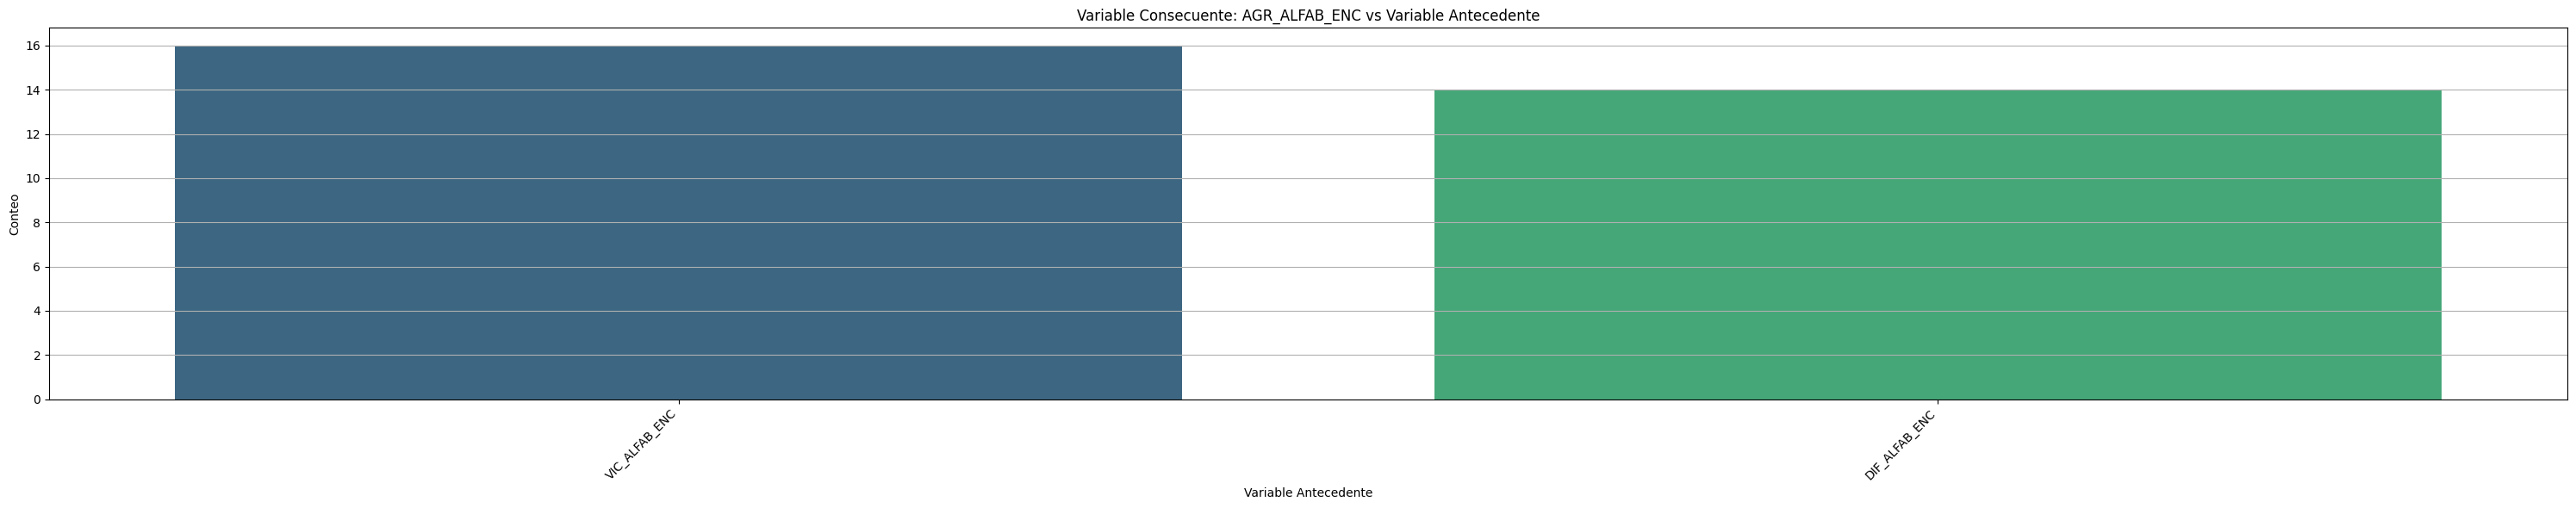

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


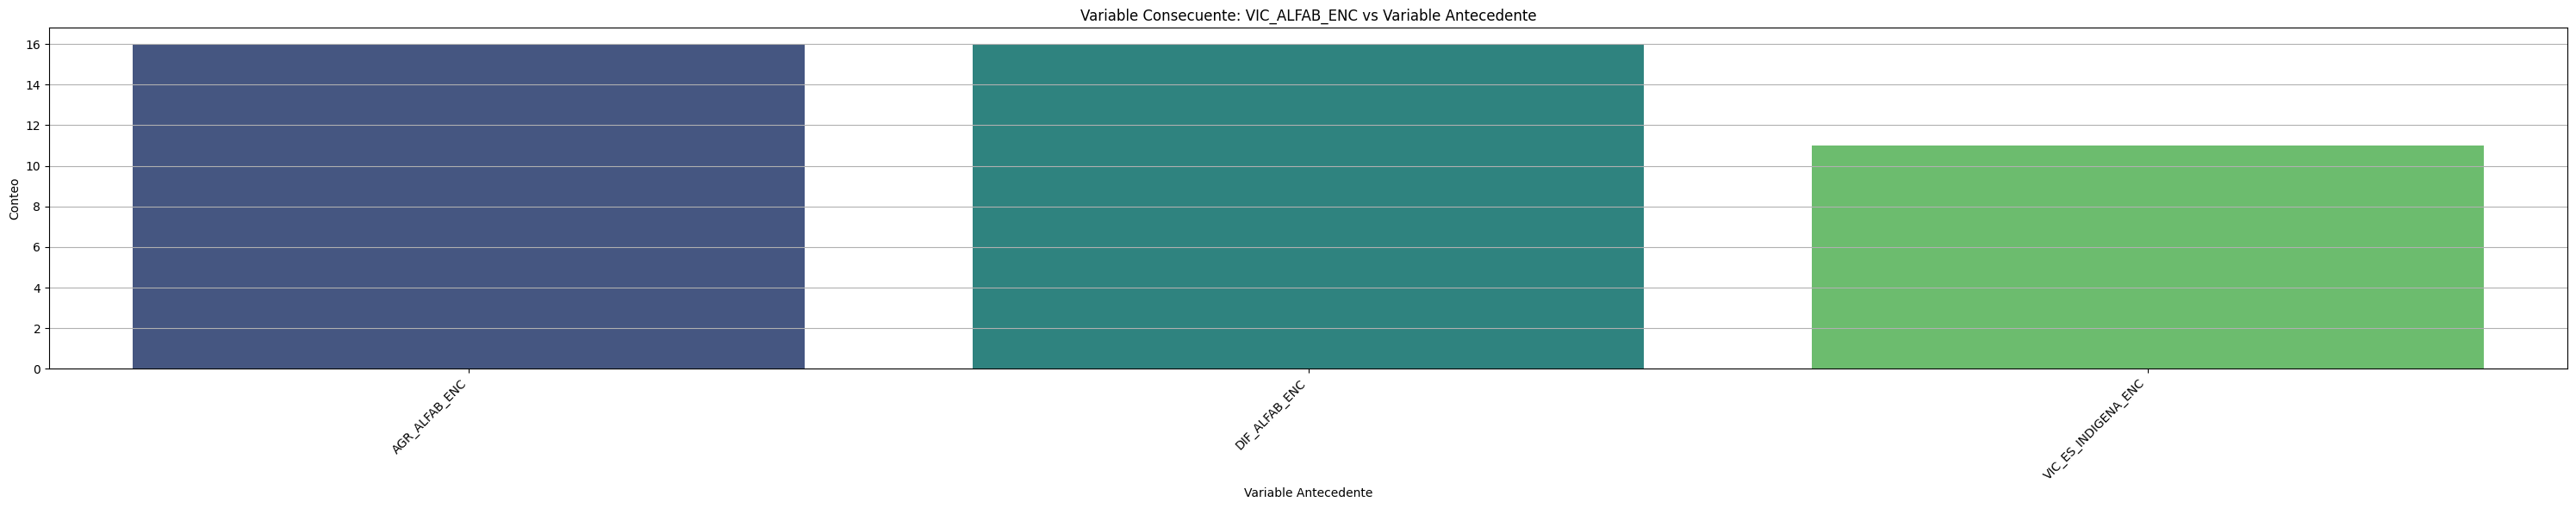

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


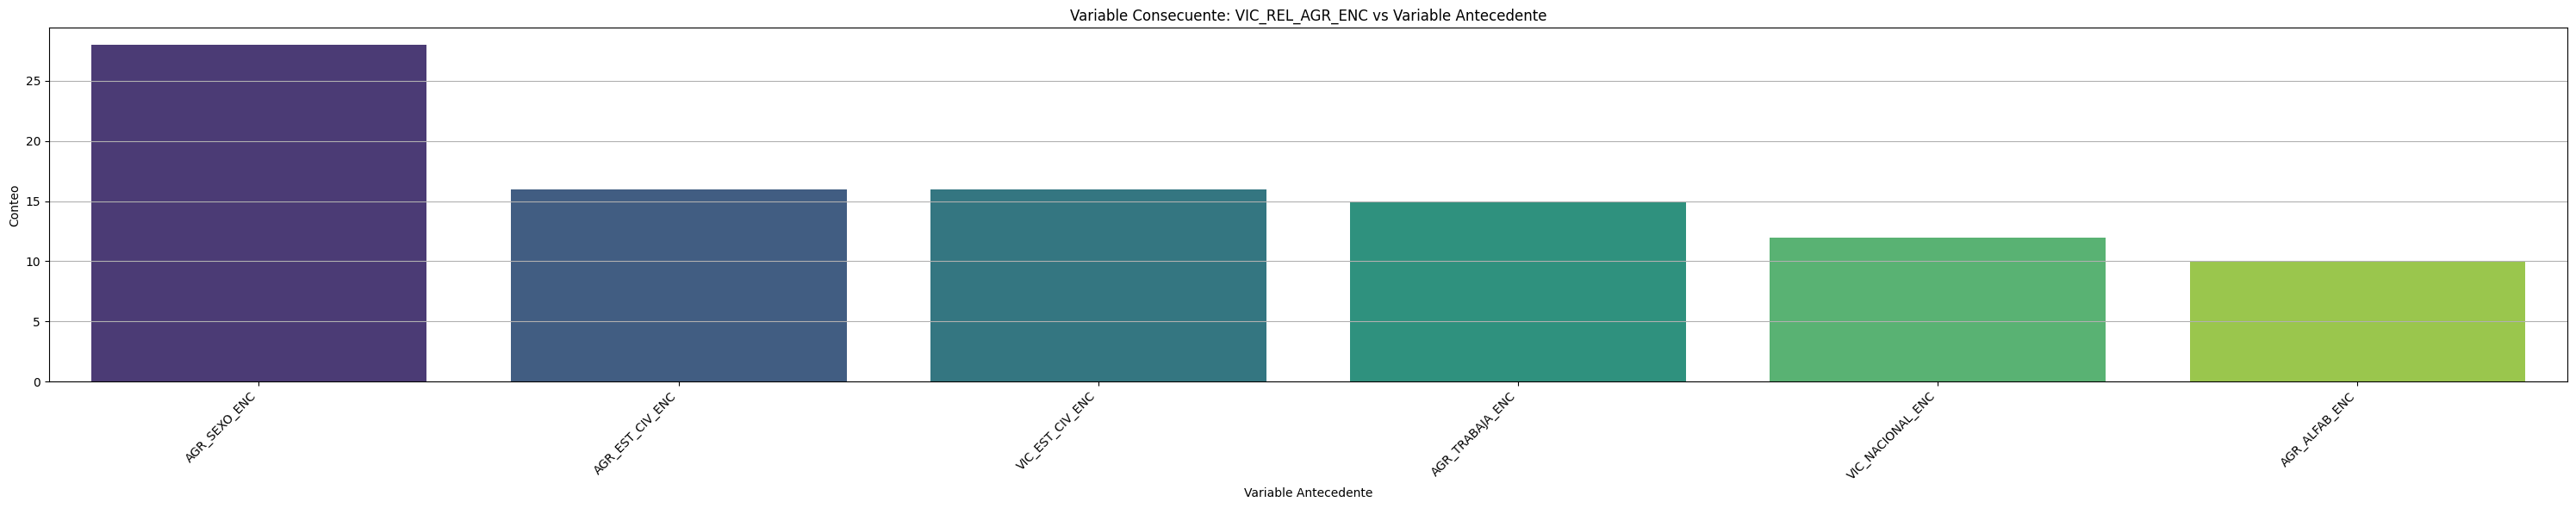

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


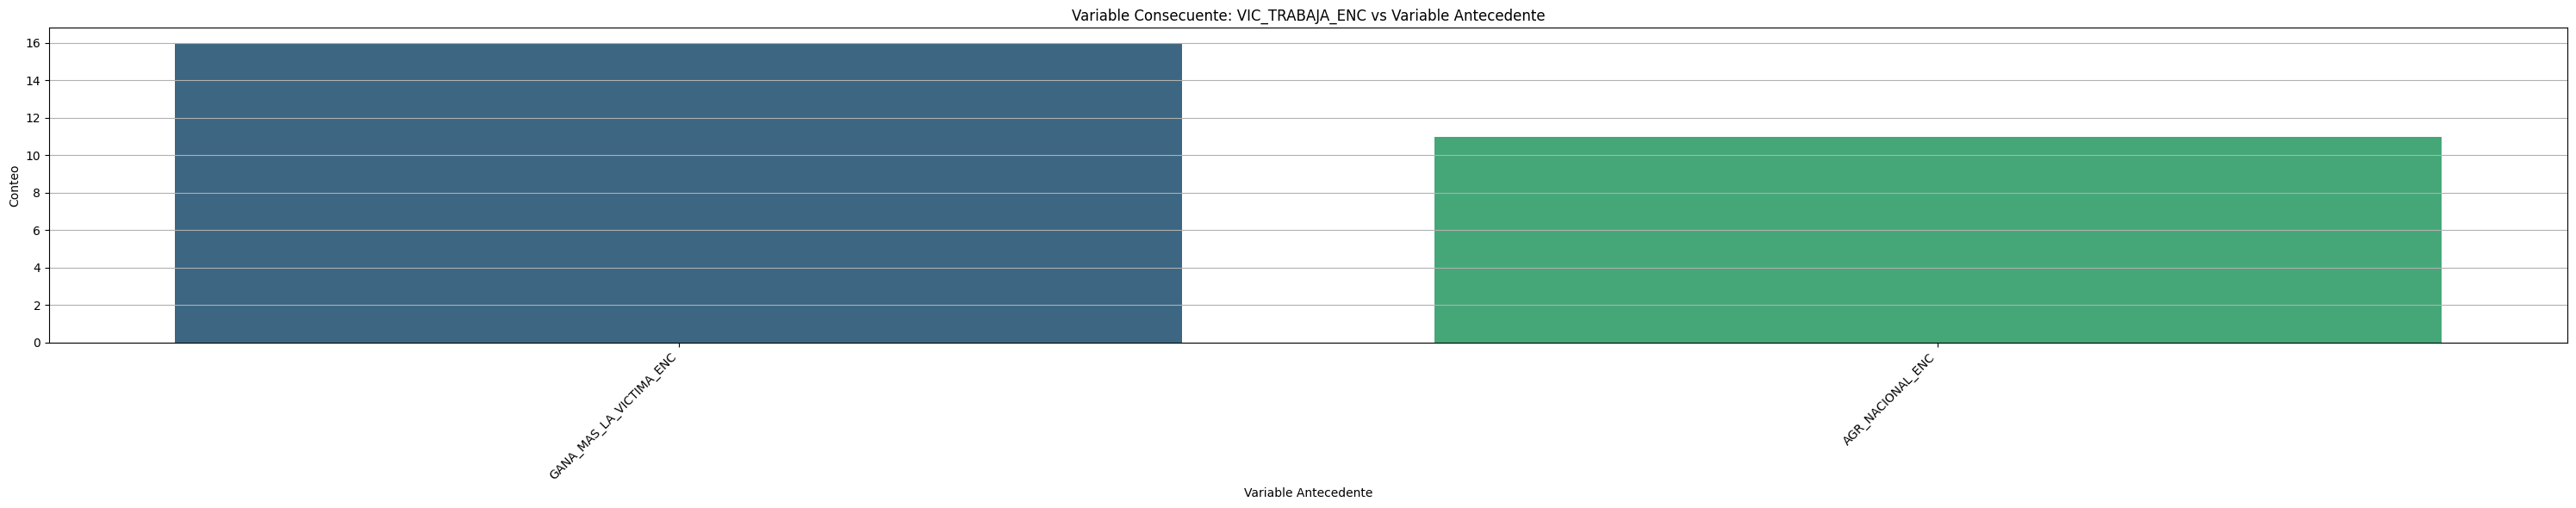

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


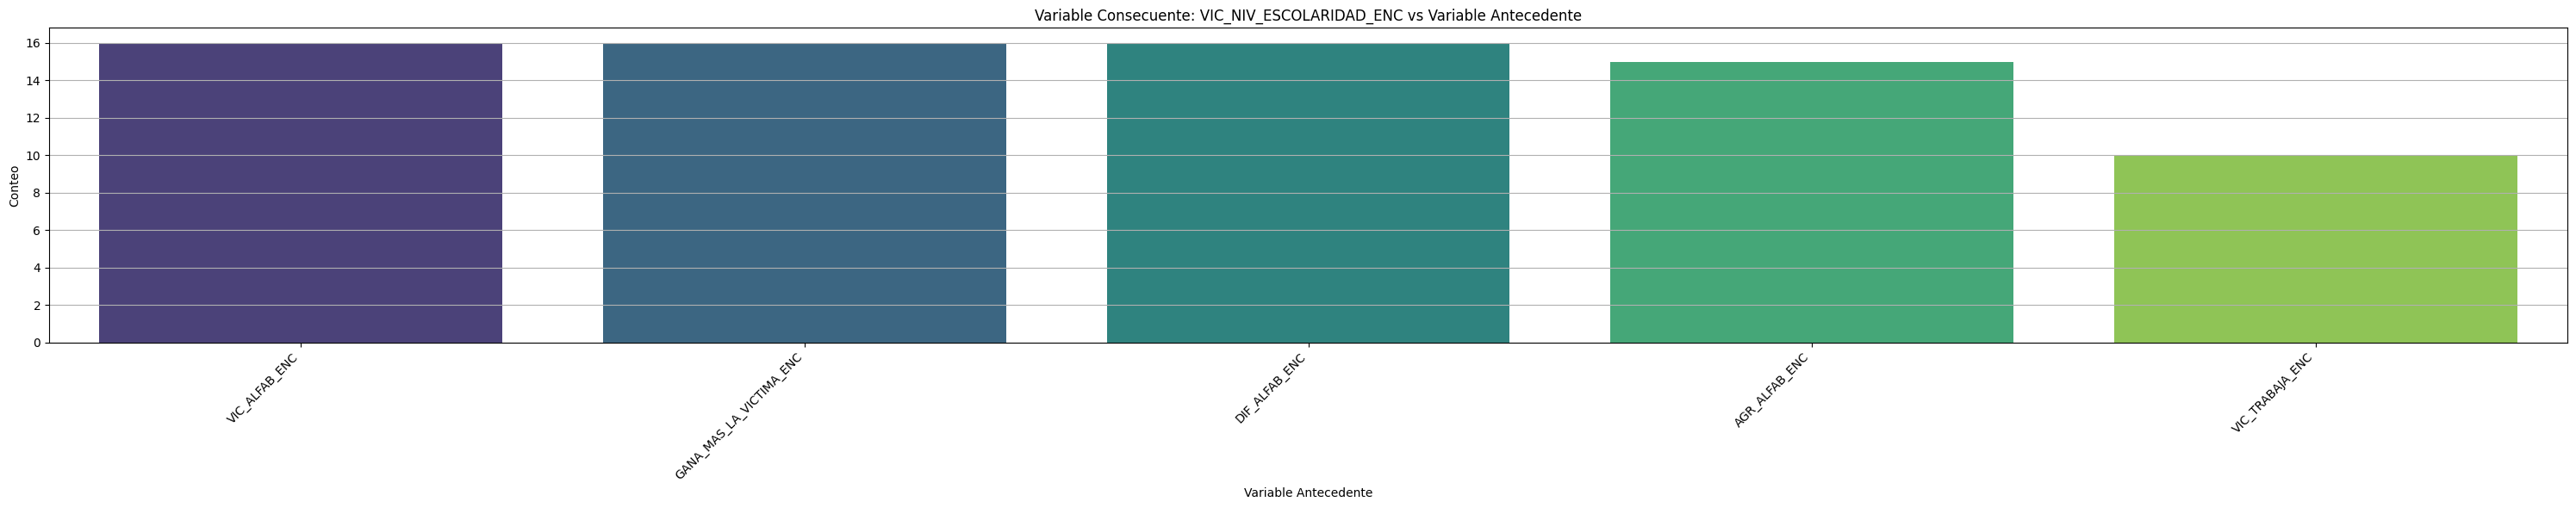

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


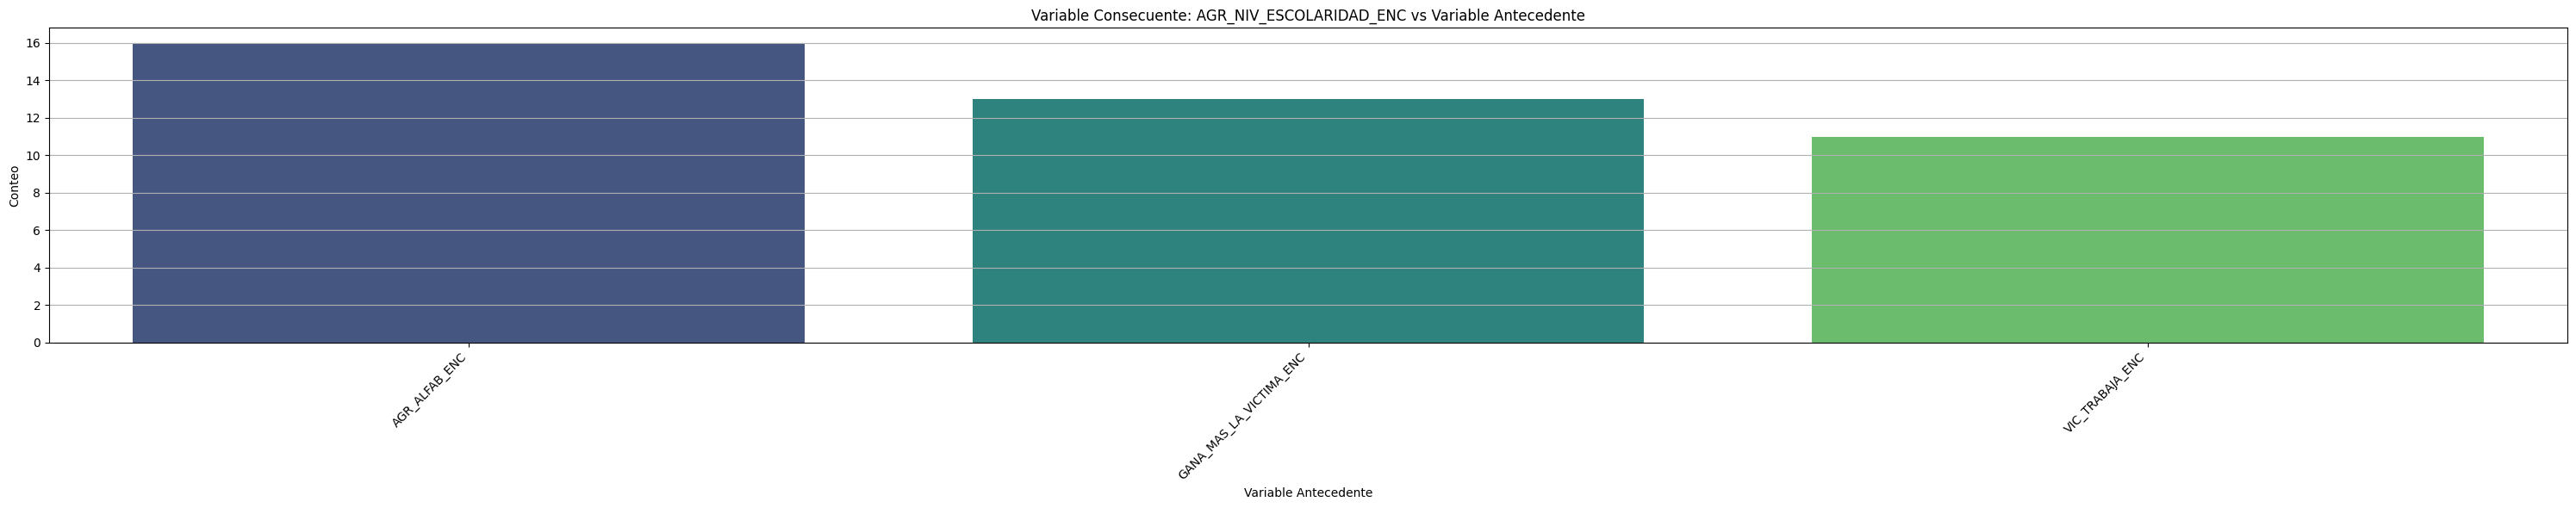

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


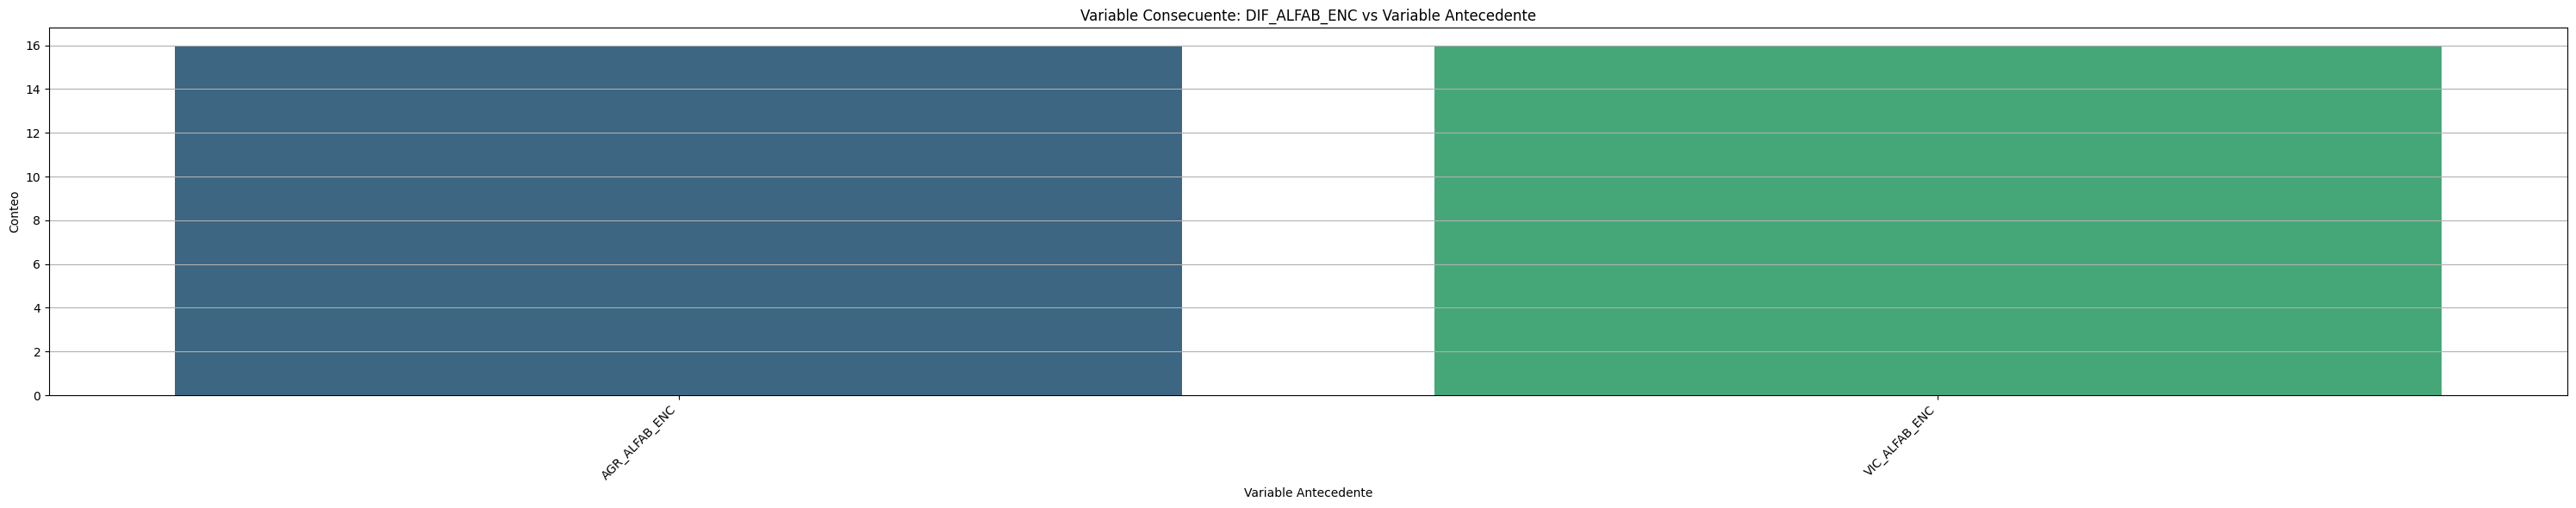

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


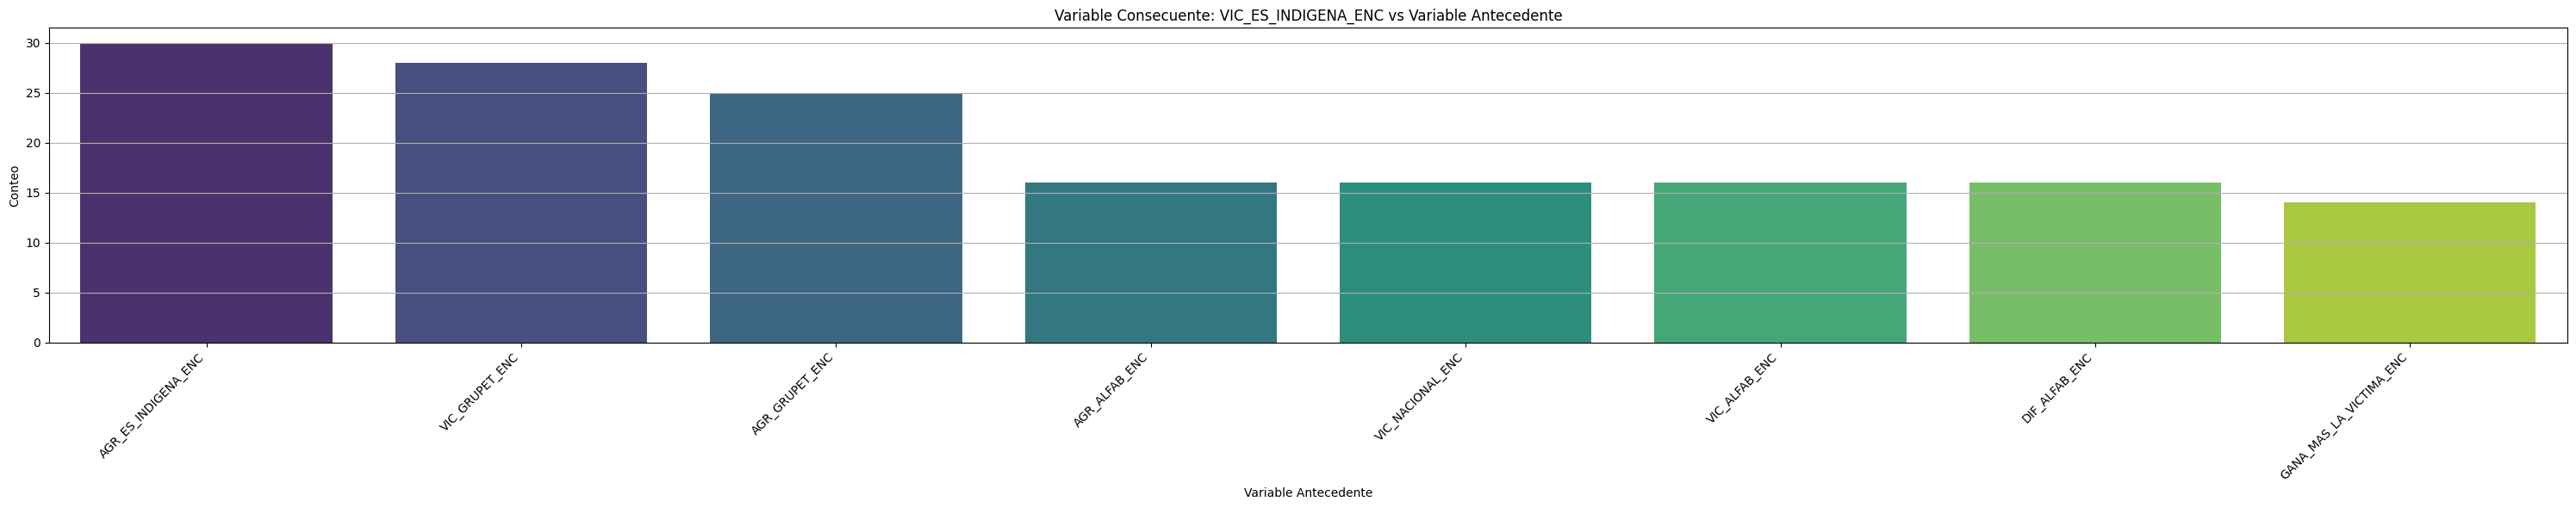

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


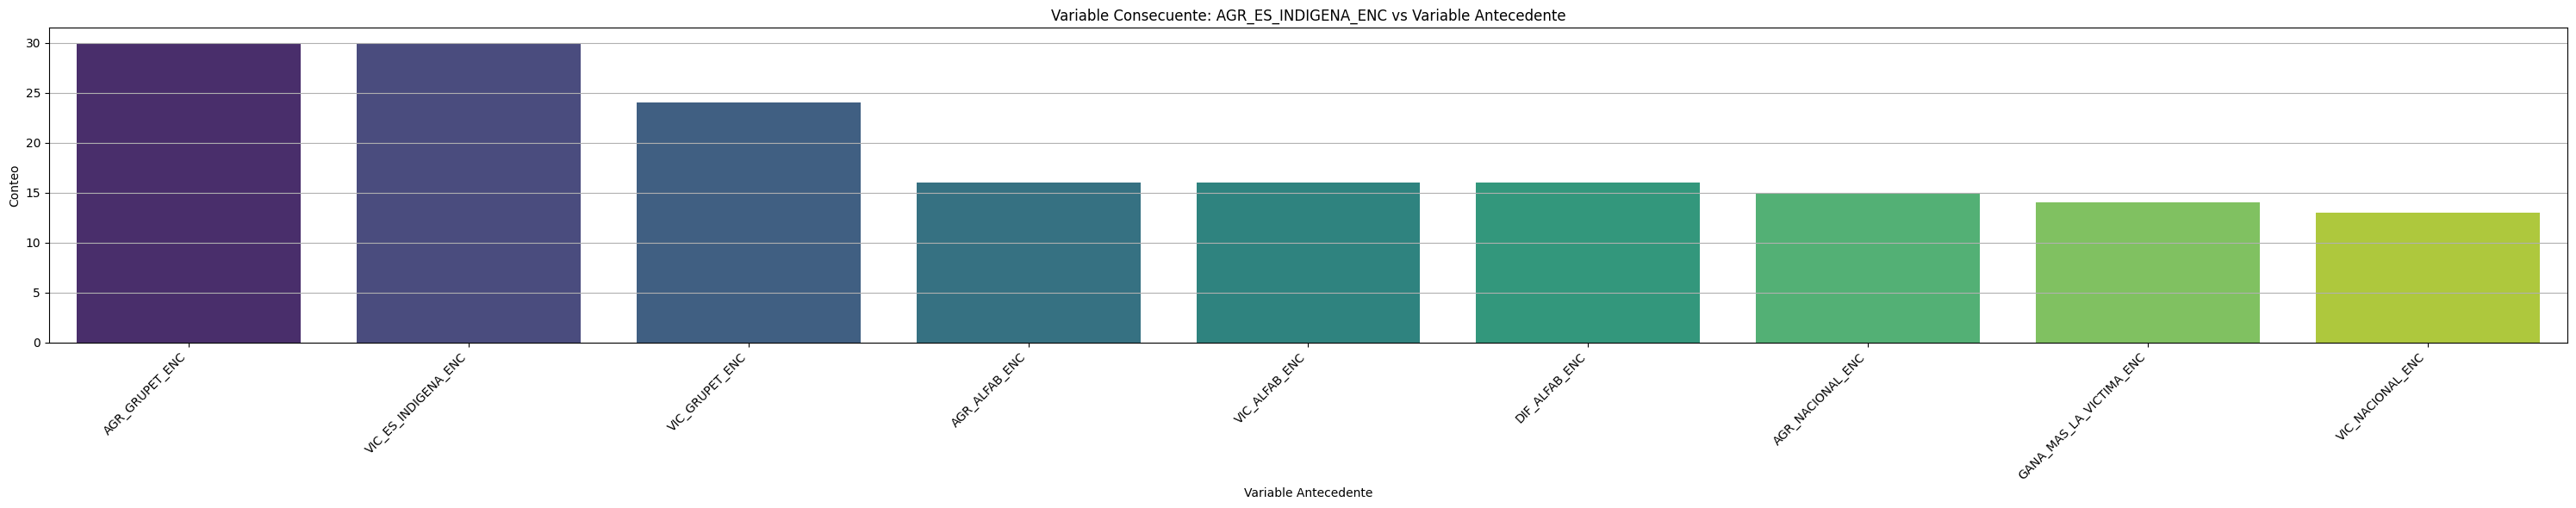

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


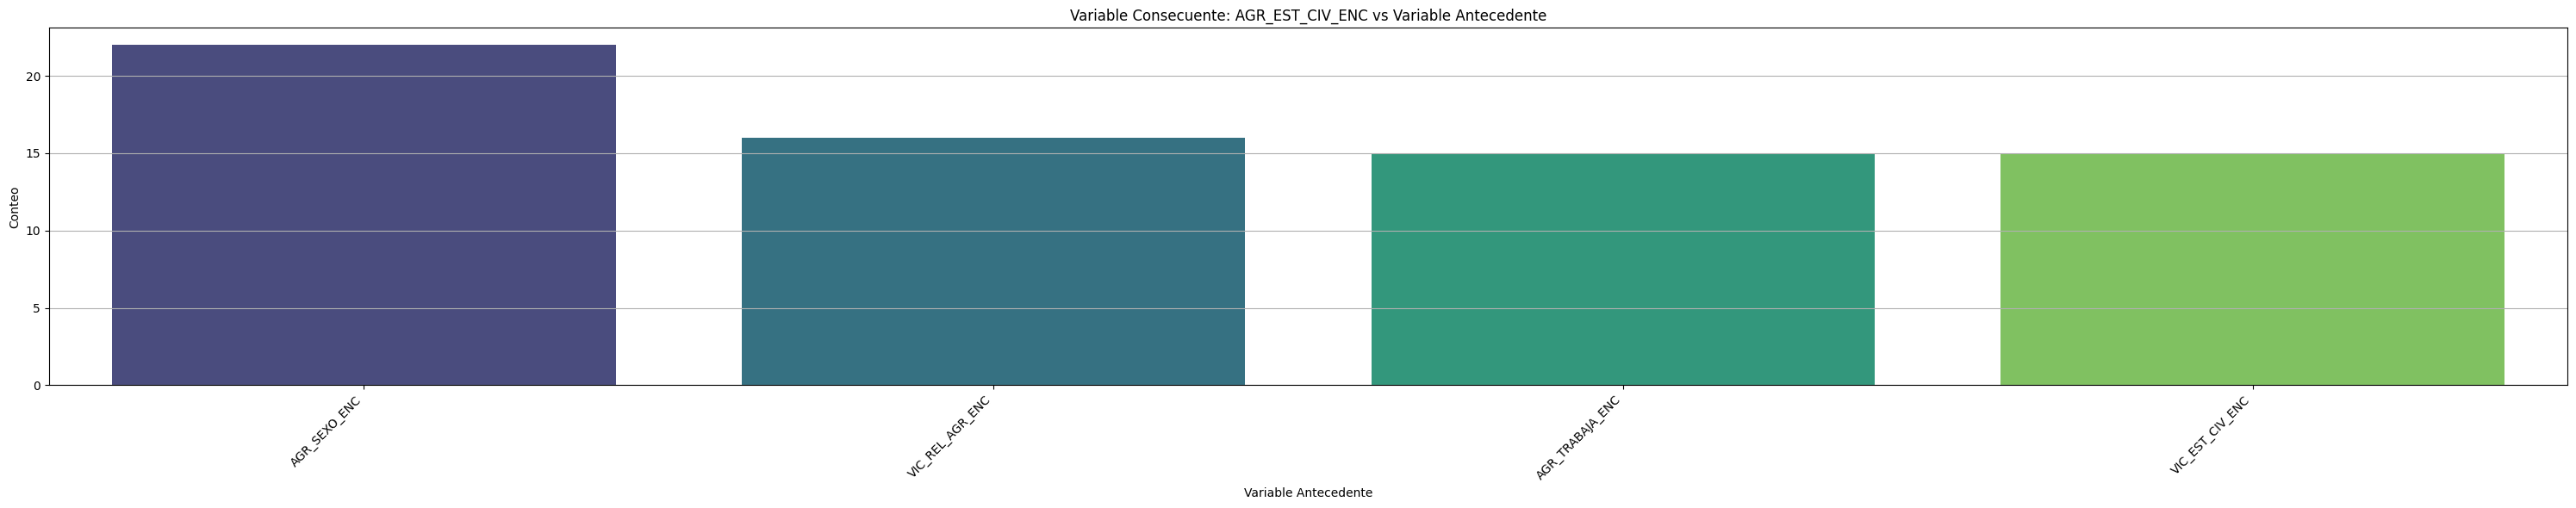

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


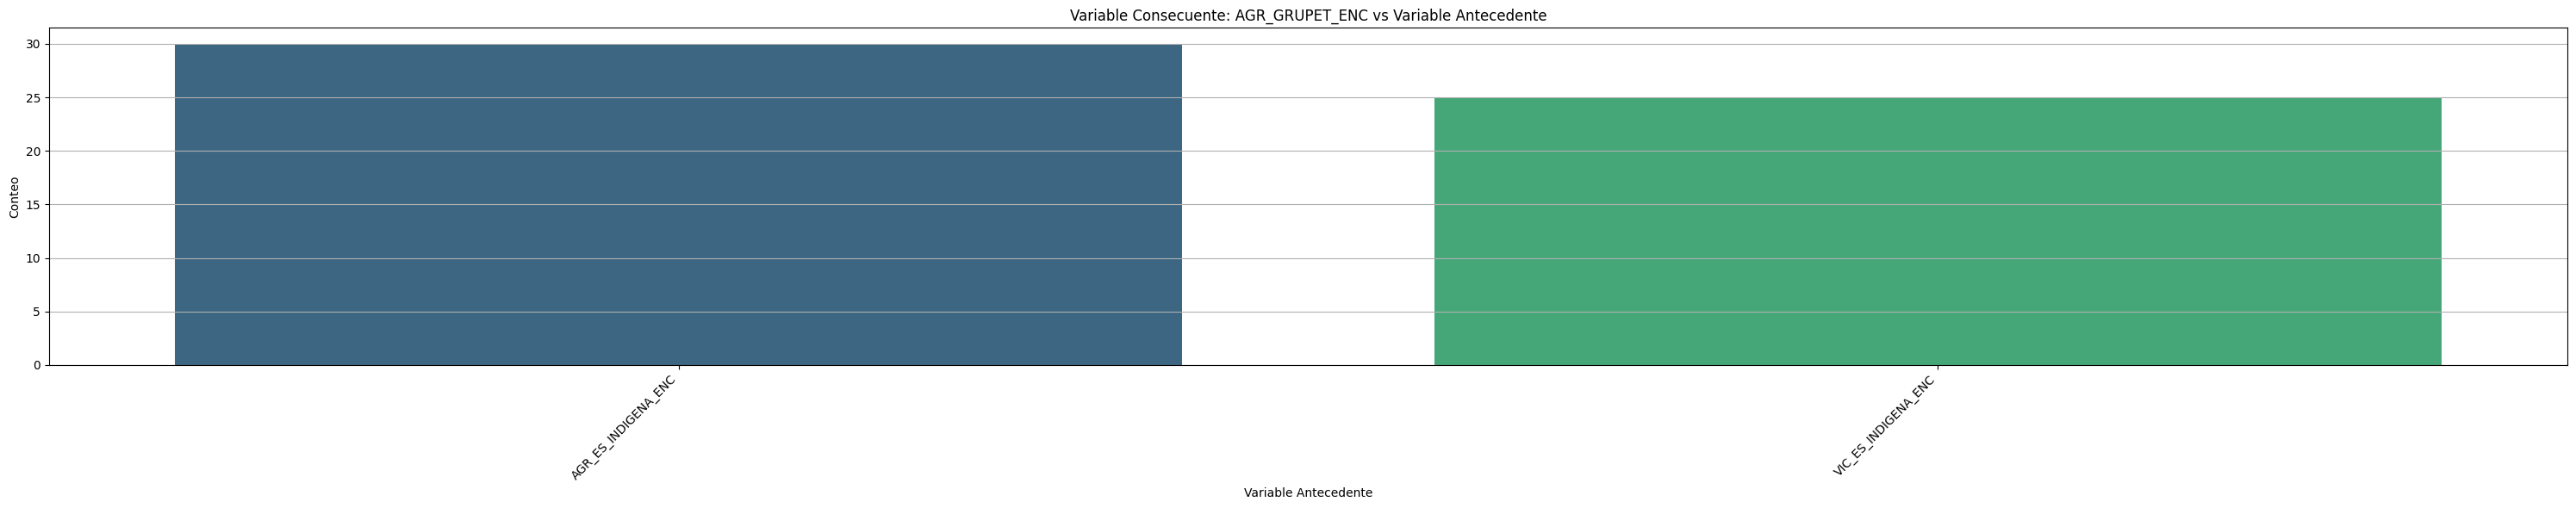

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


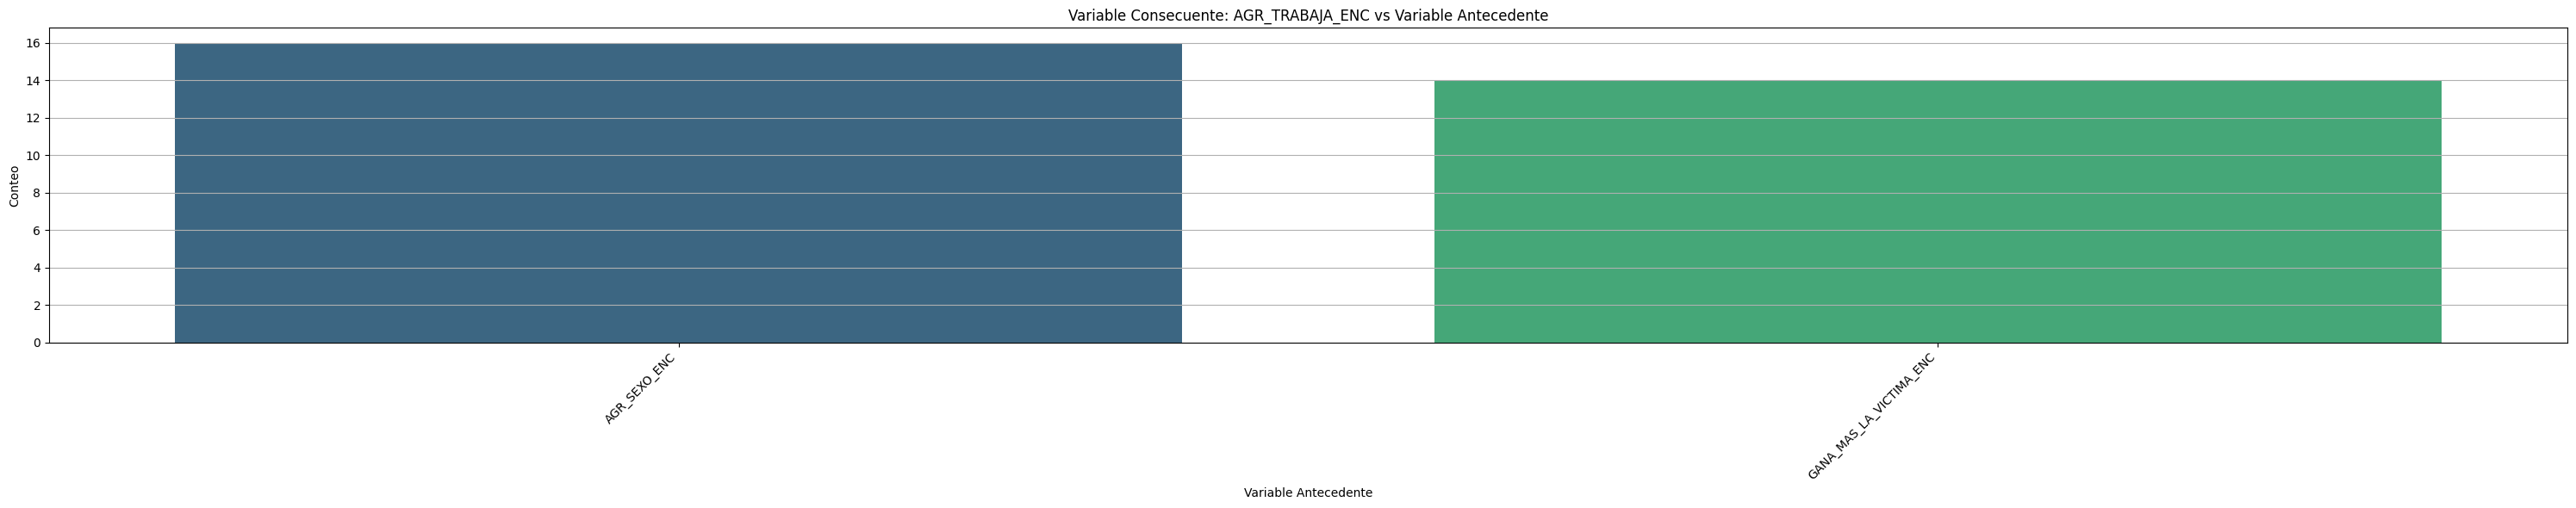

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


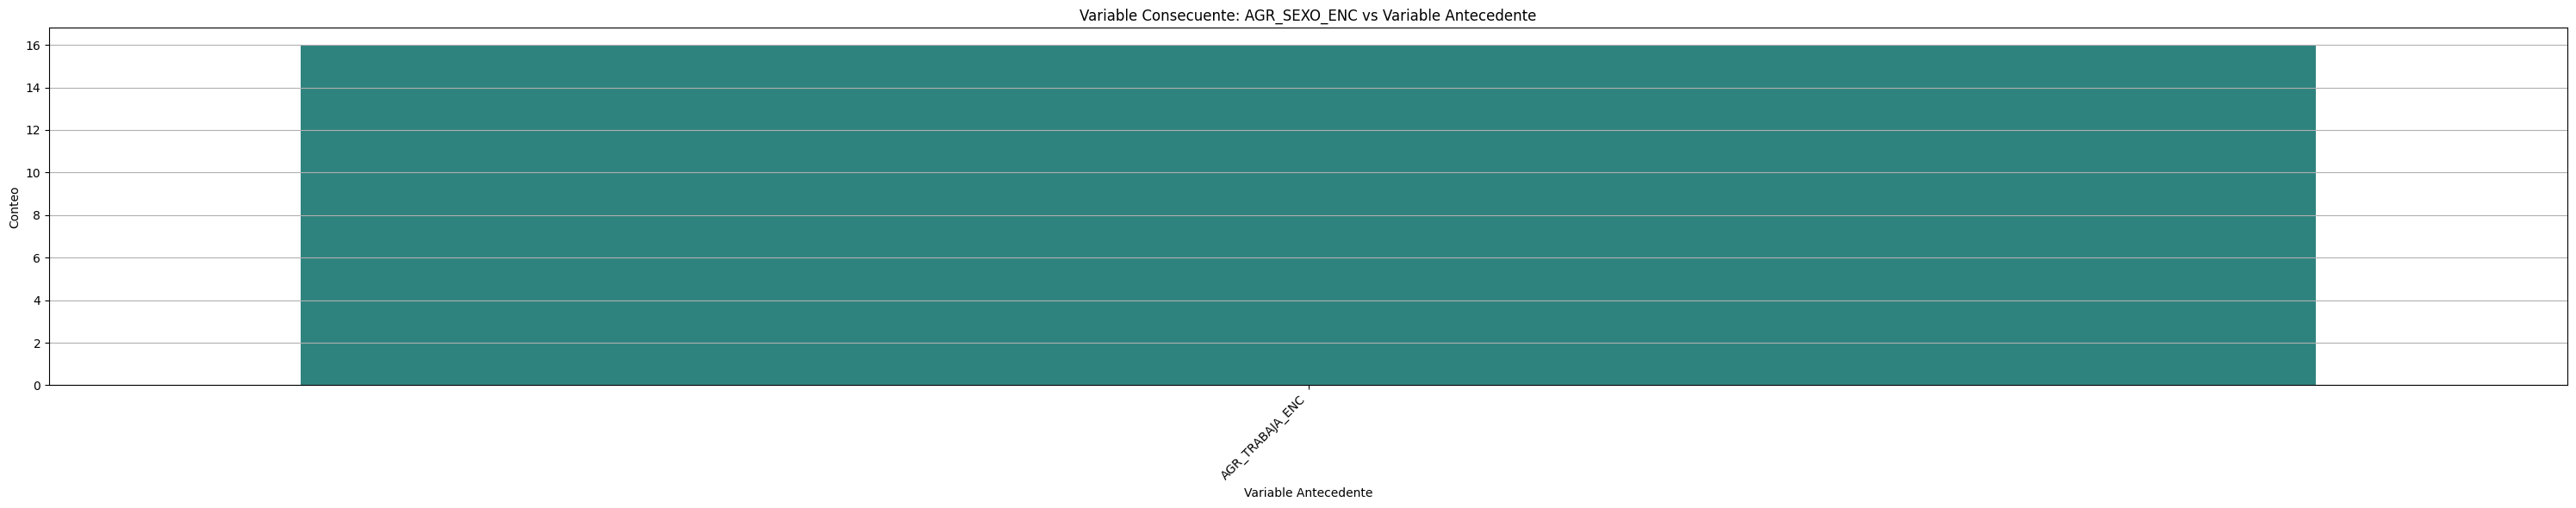

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


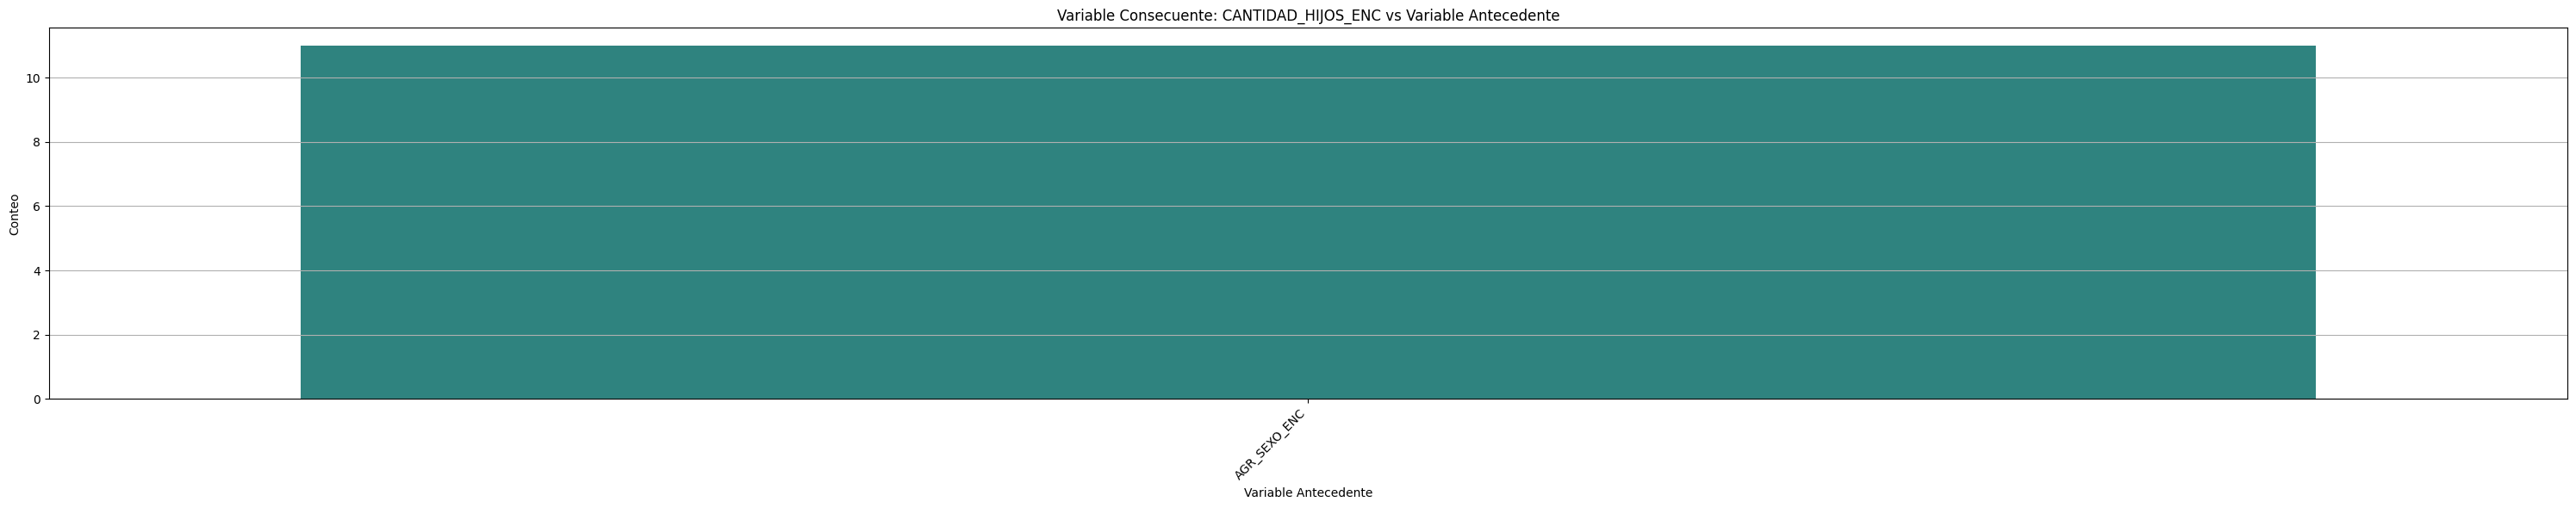

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


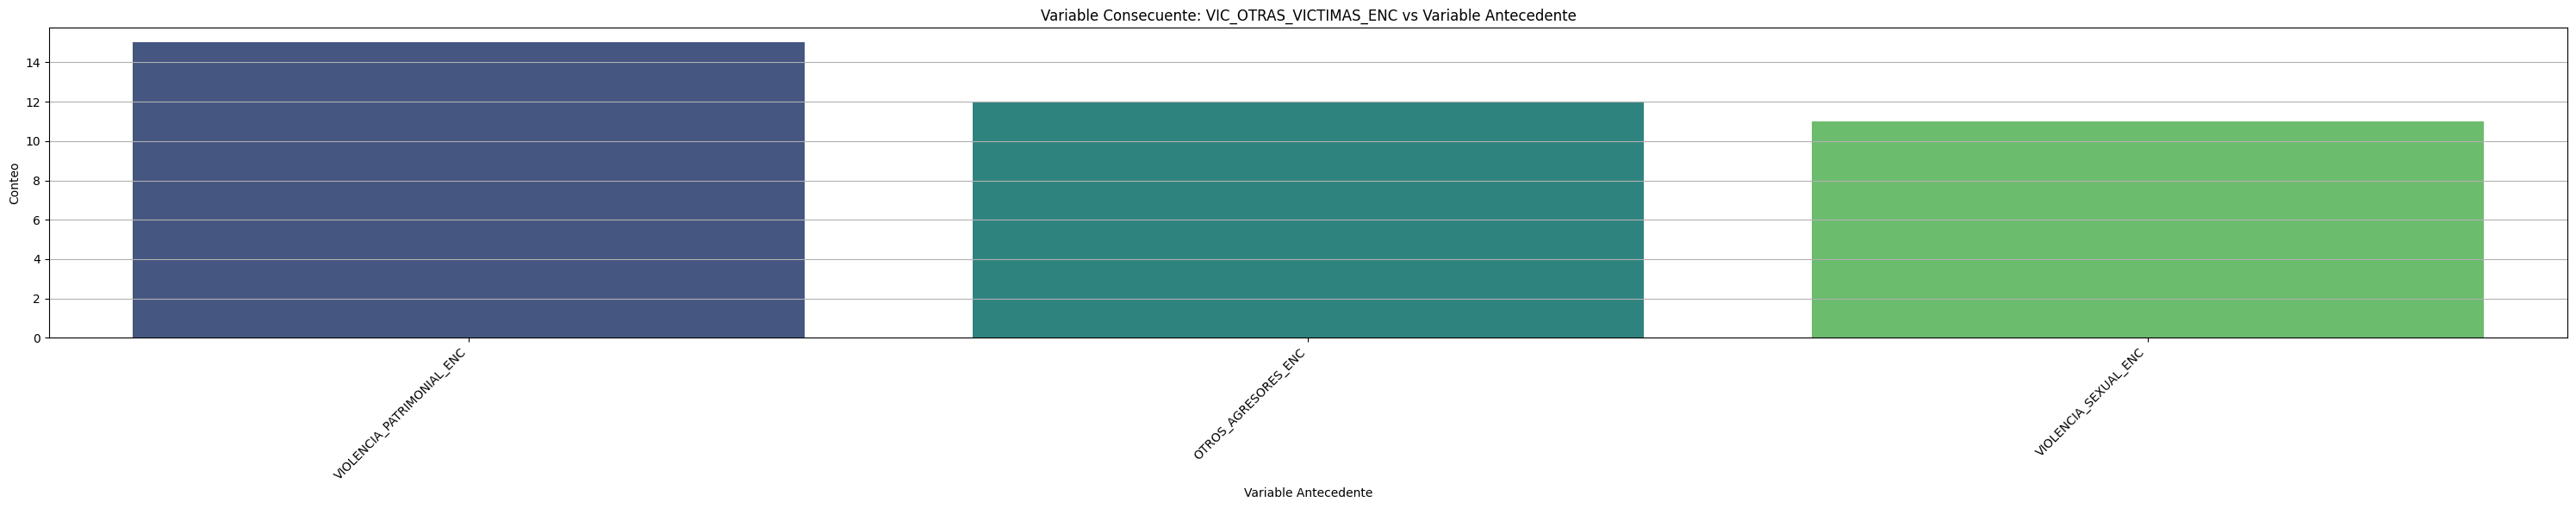

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


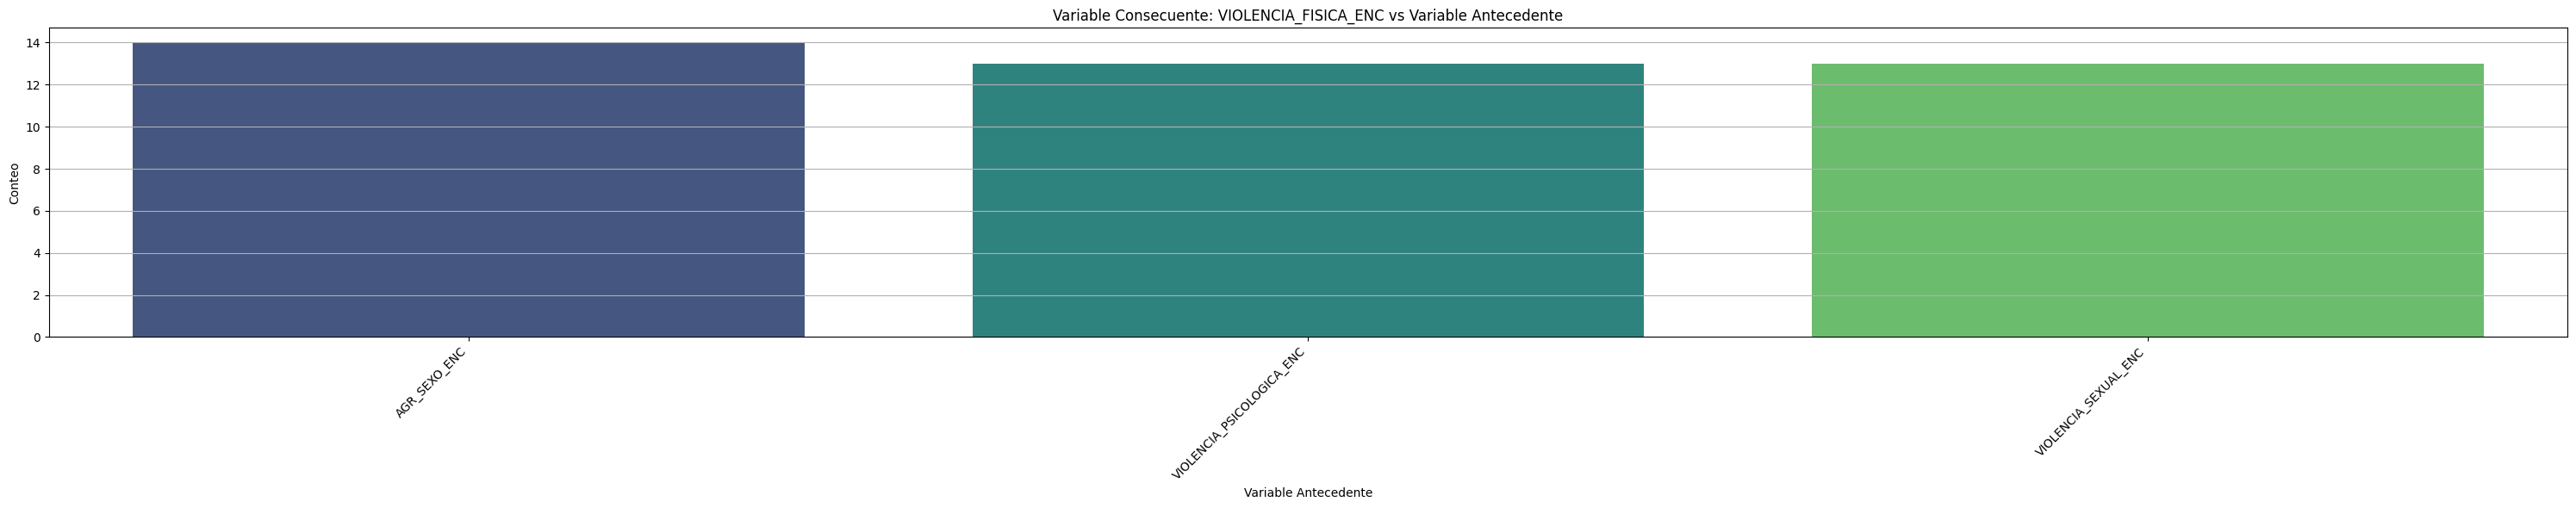

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


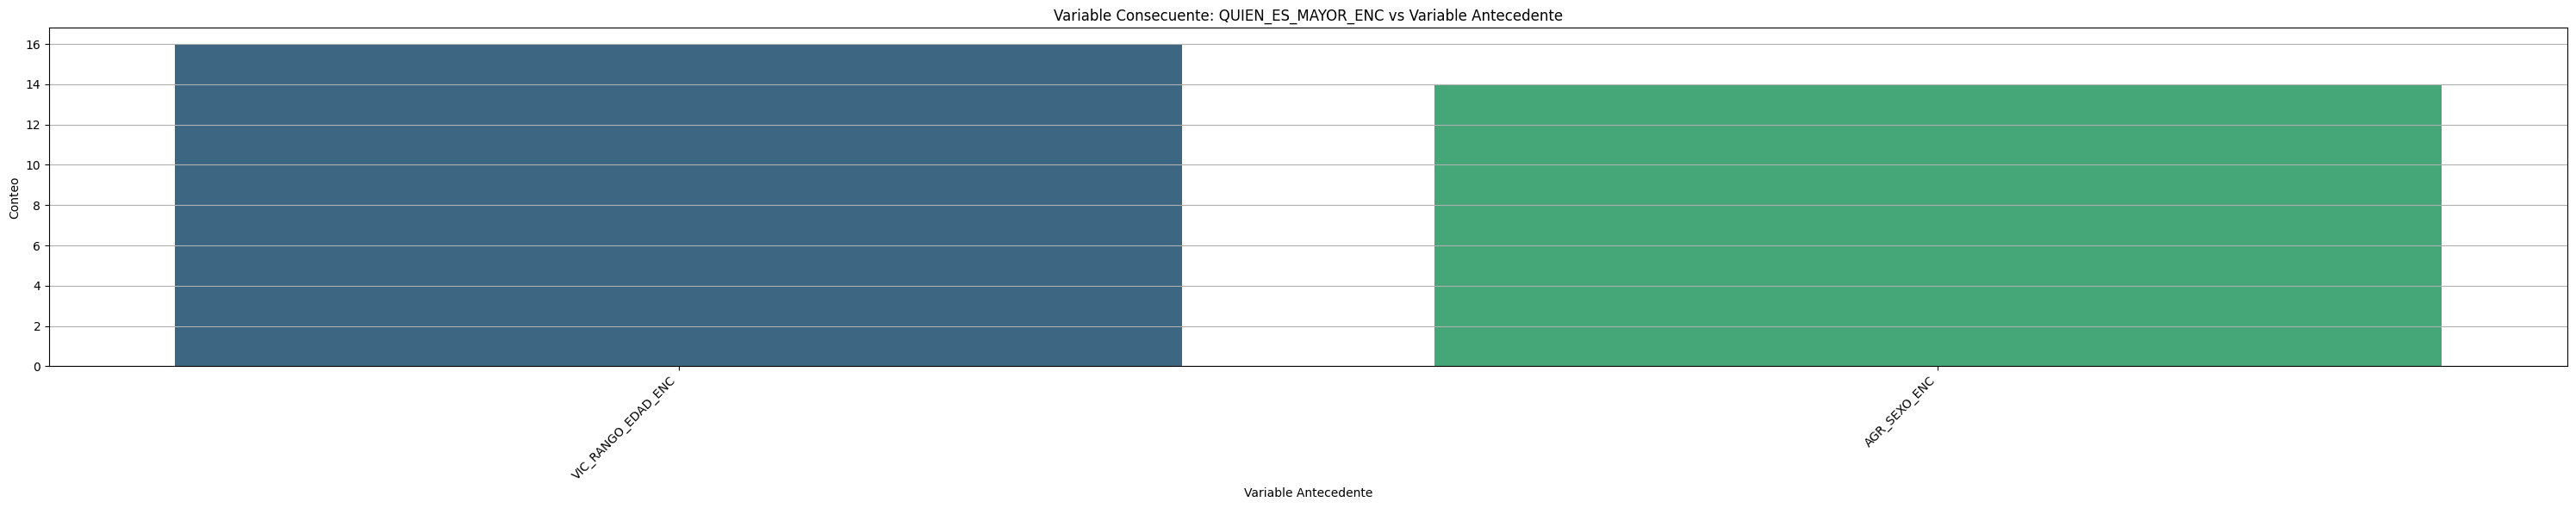

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


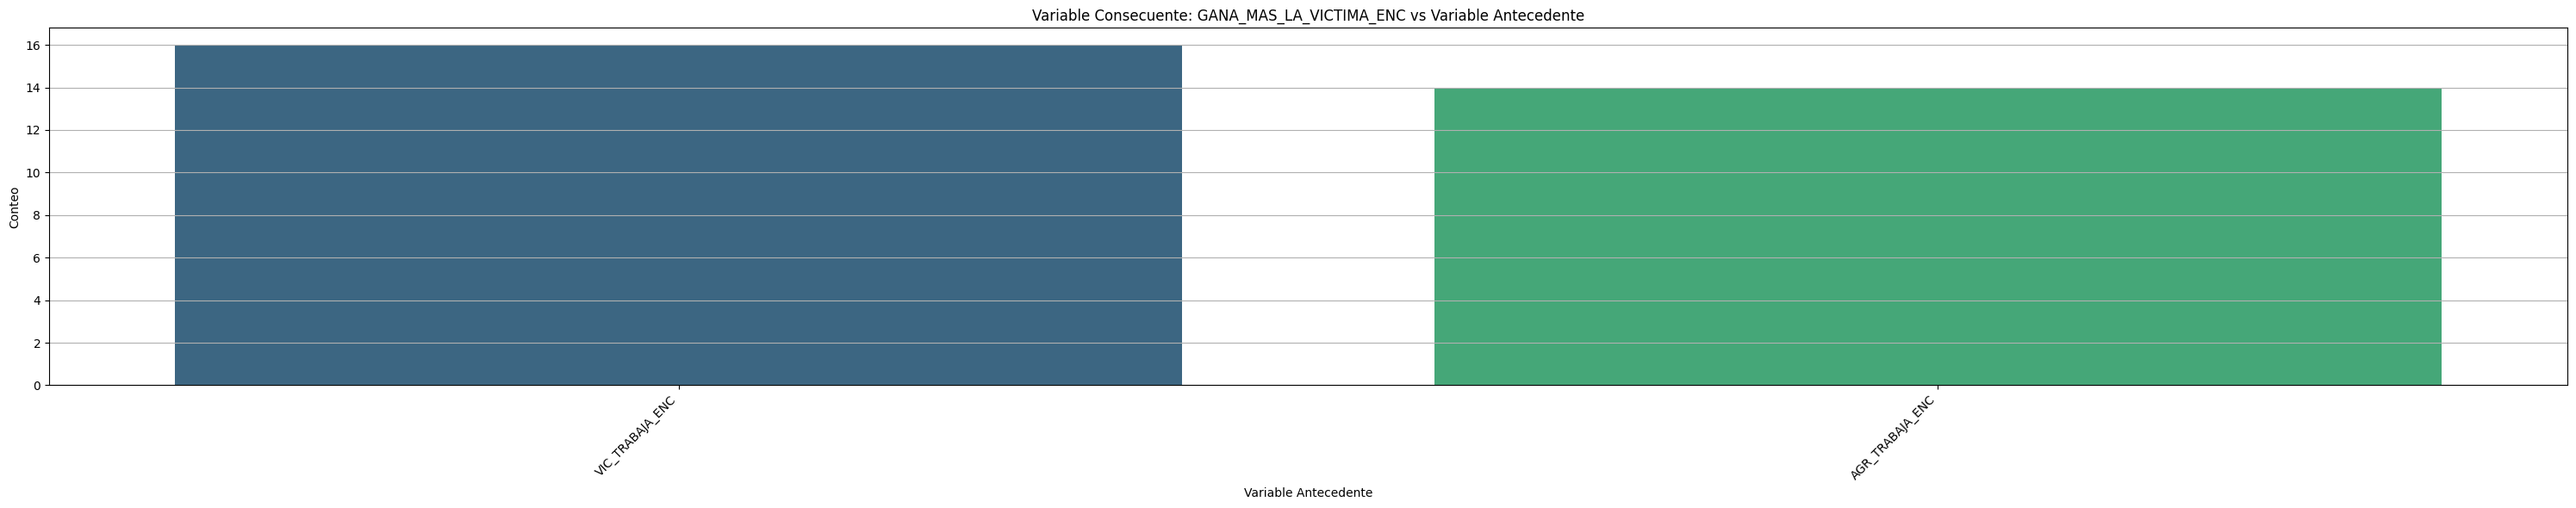

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


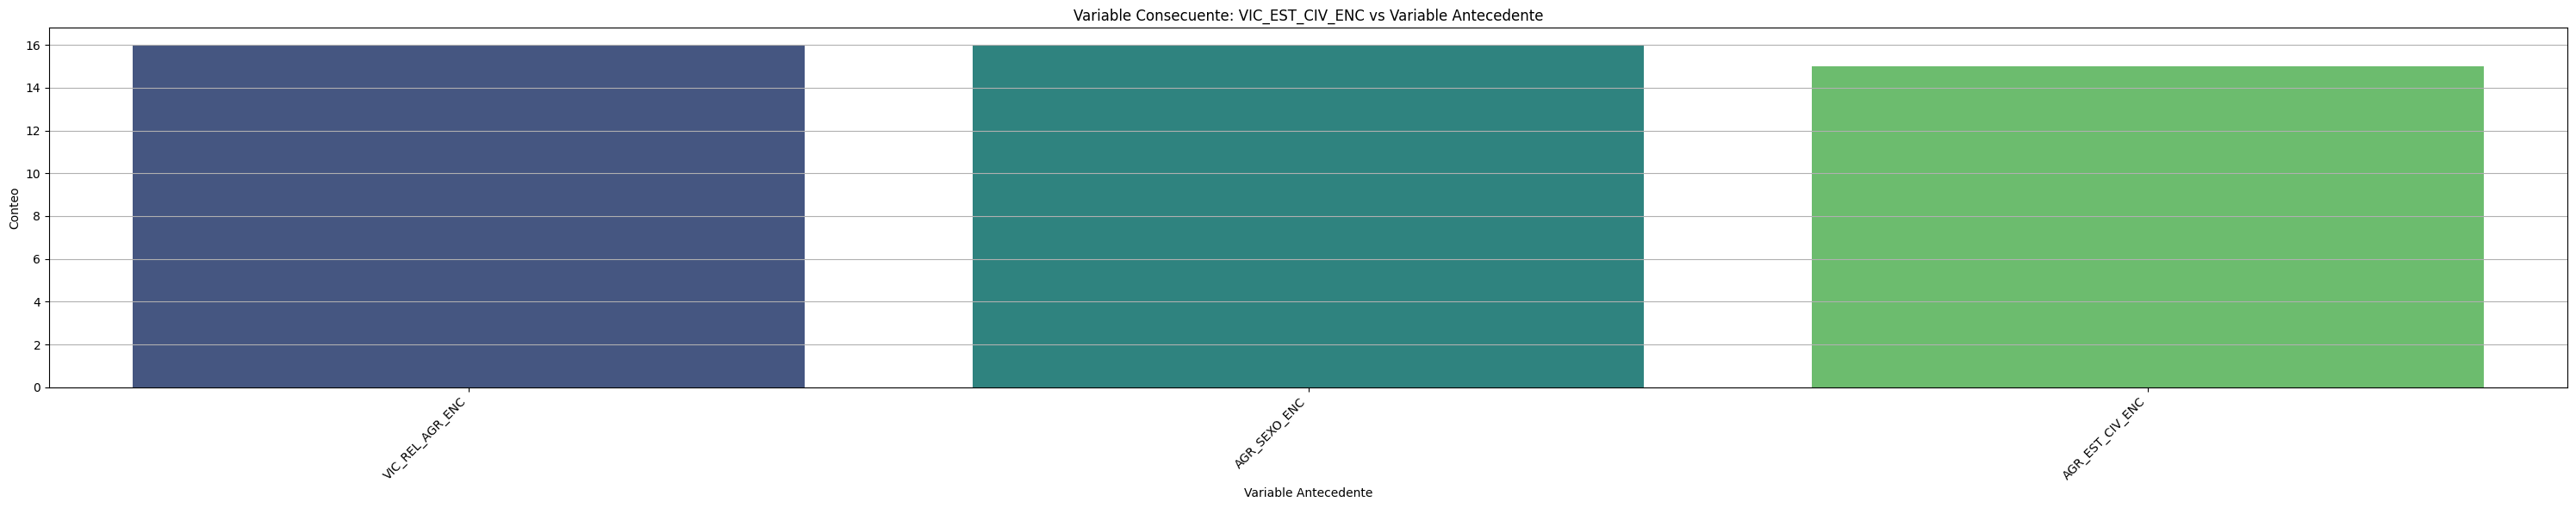

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


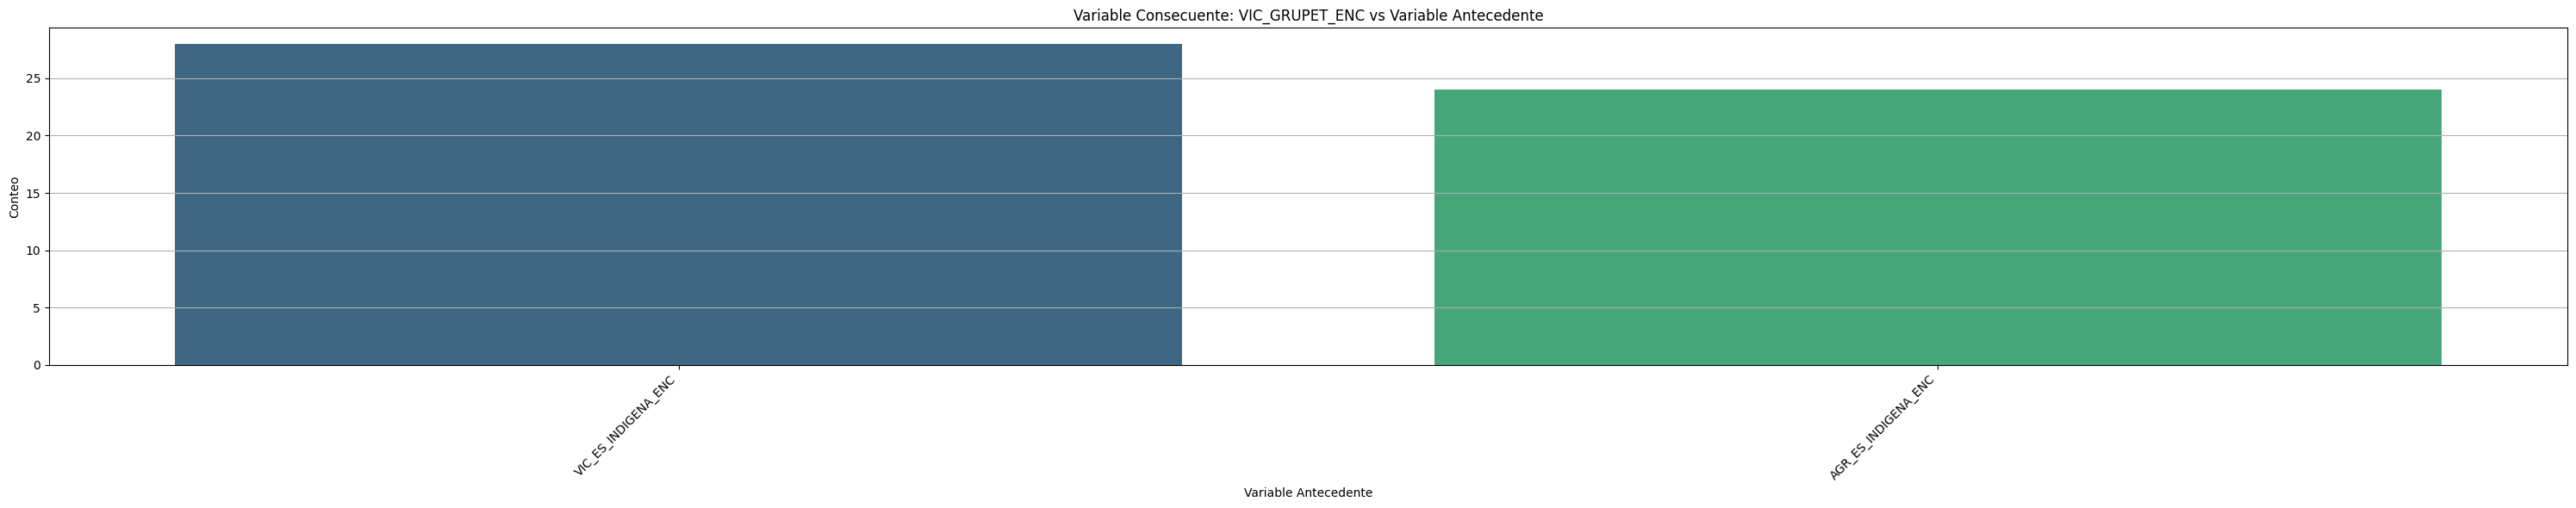

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


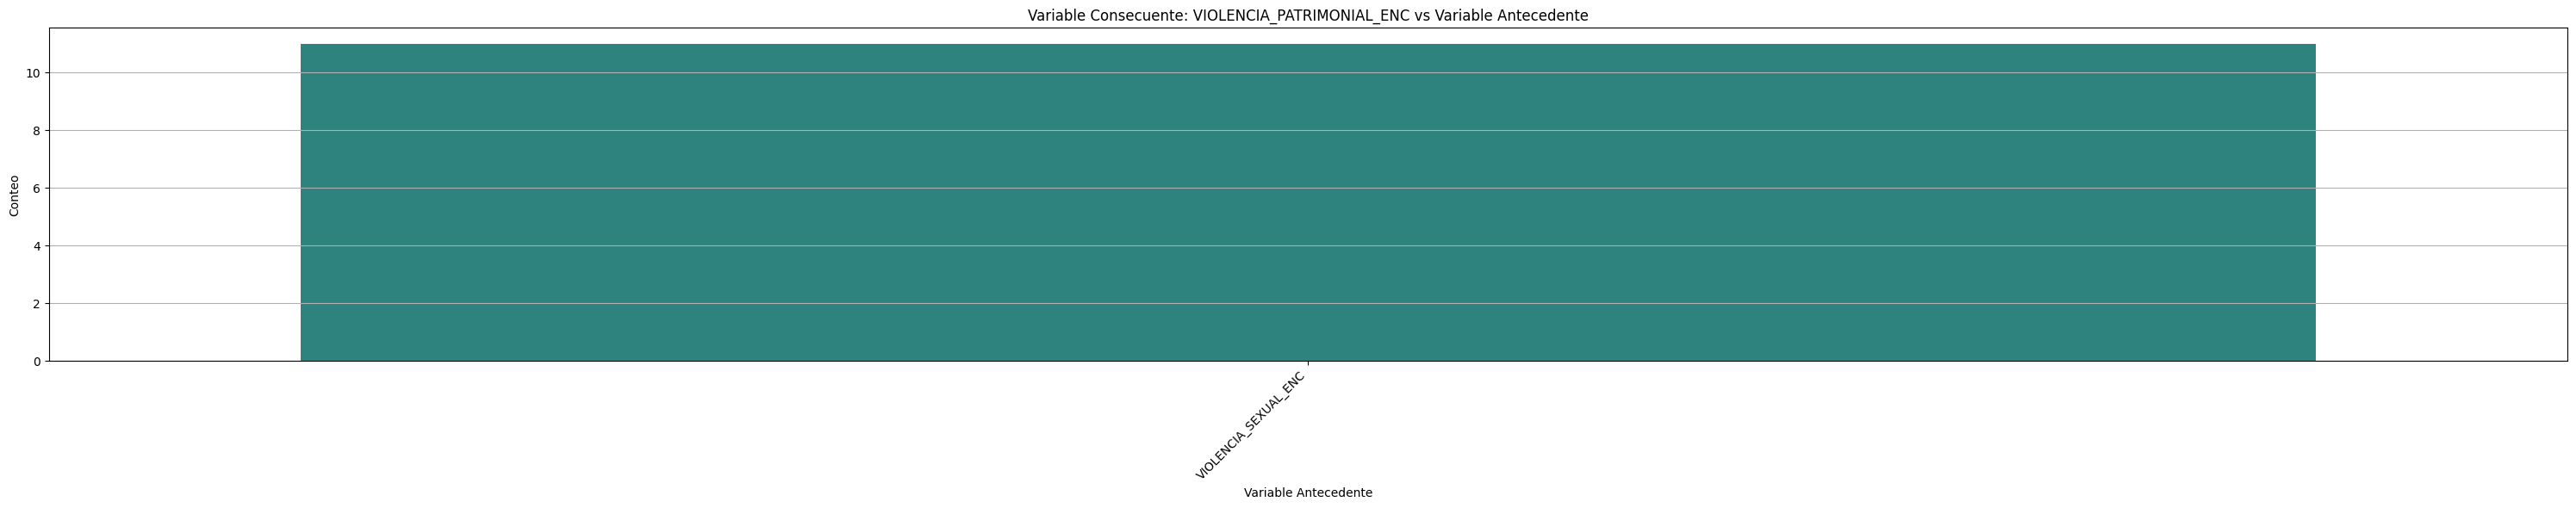

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


No results for AGR_OFICIO_ENC with count >= 10
No results for VIC_OFICIO_ENC with count >= 10


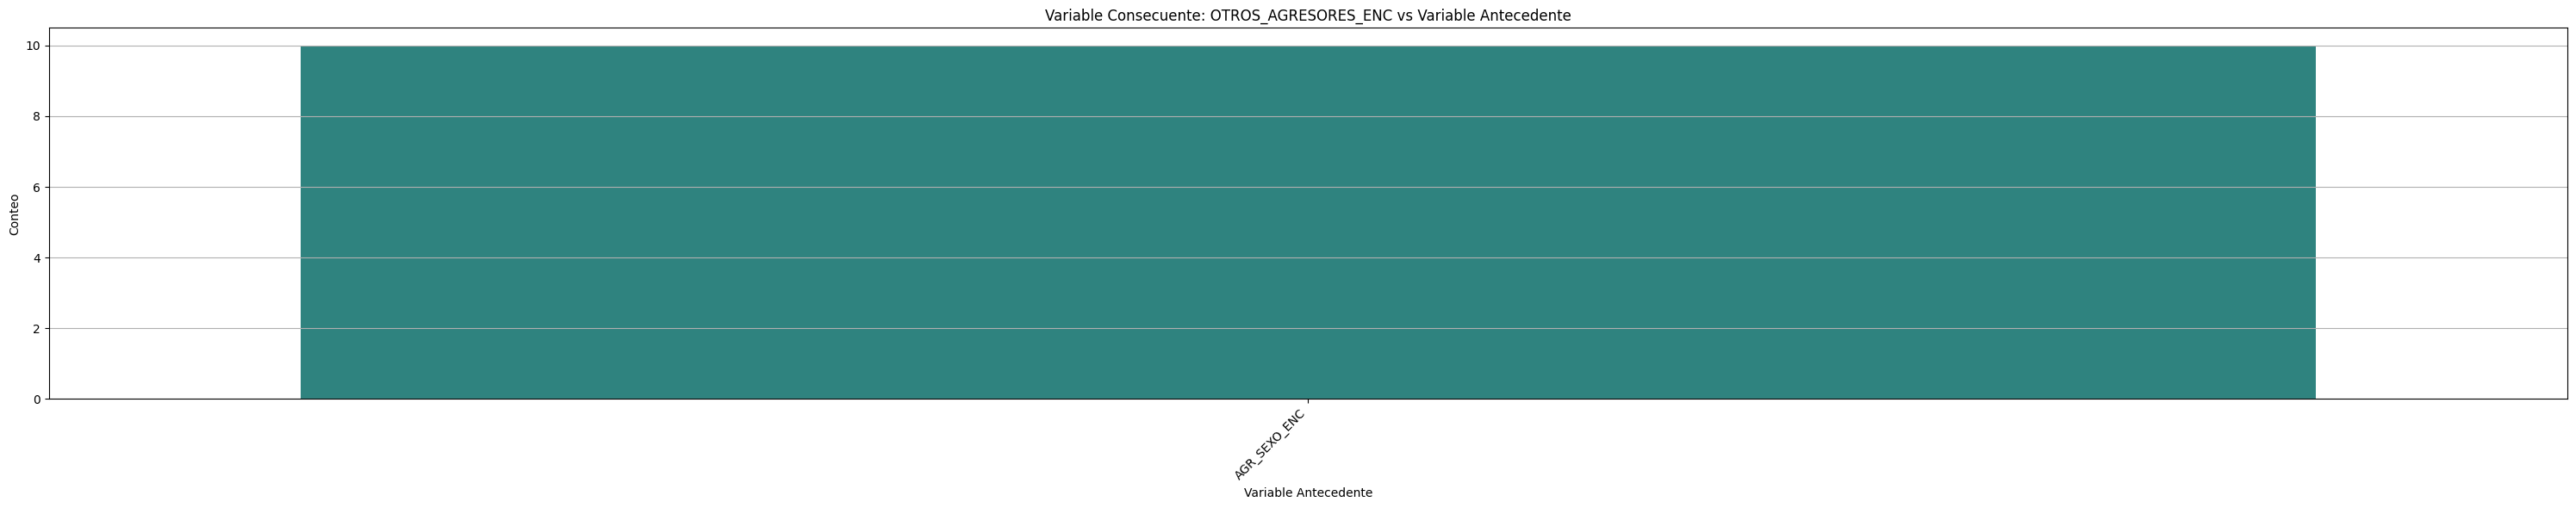

No results for VIC_RANGO_EDAD_ENC with count >= 10
No results for VIOLENCIA_PSICOLOGICA_ENC with count >= 10


In [40]:
analysis_graphs(df_mujer, x='VARIABLE_ANTECEDENTE', y = 'VARIABLE_CONSECUENTE')

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


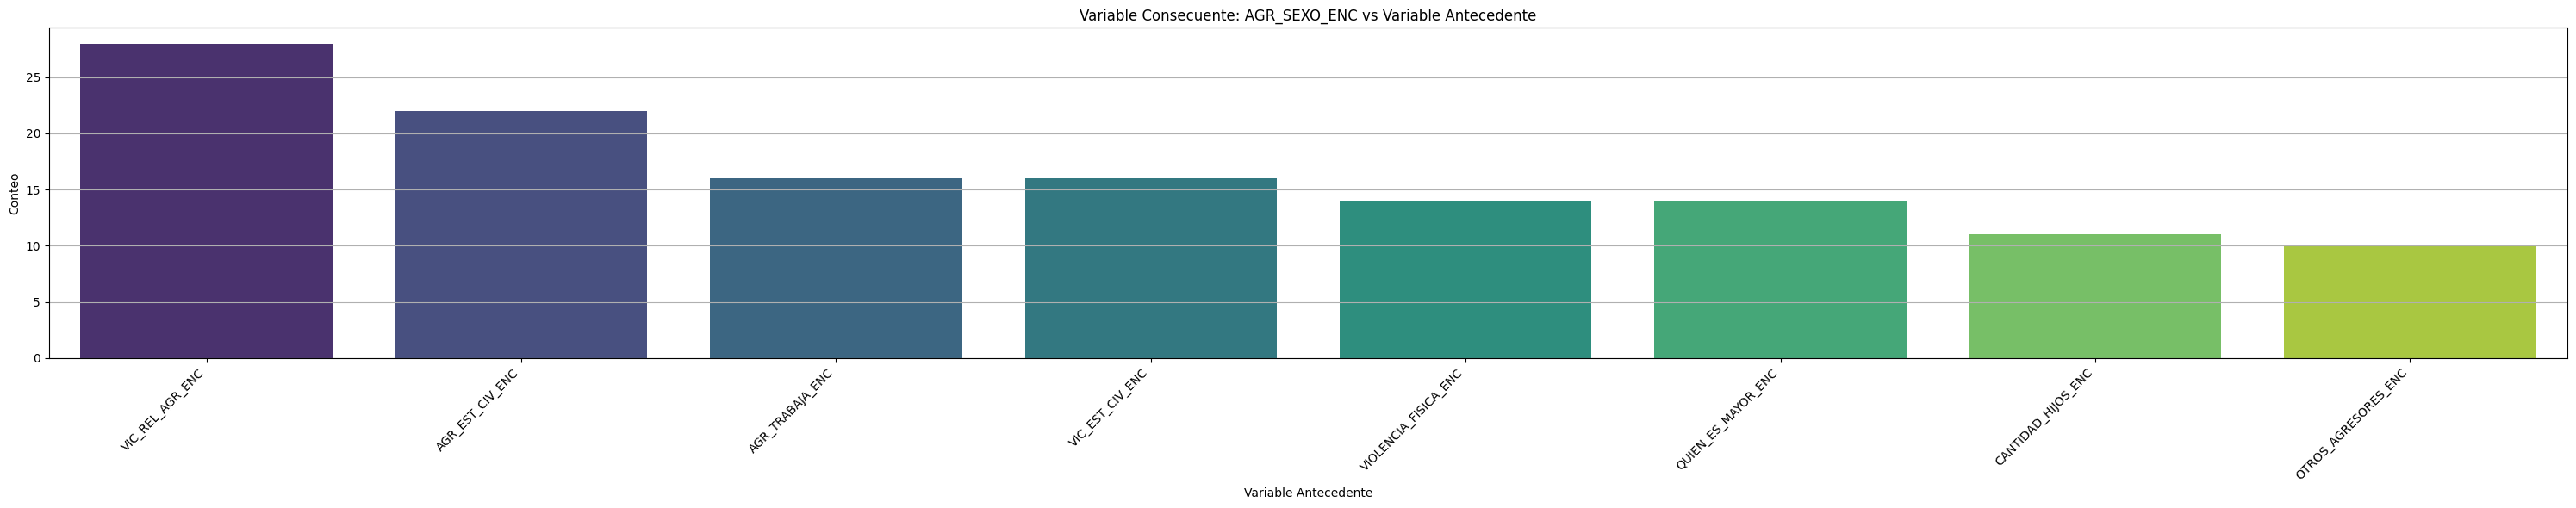

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


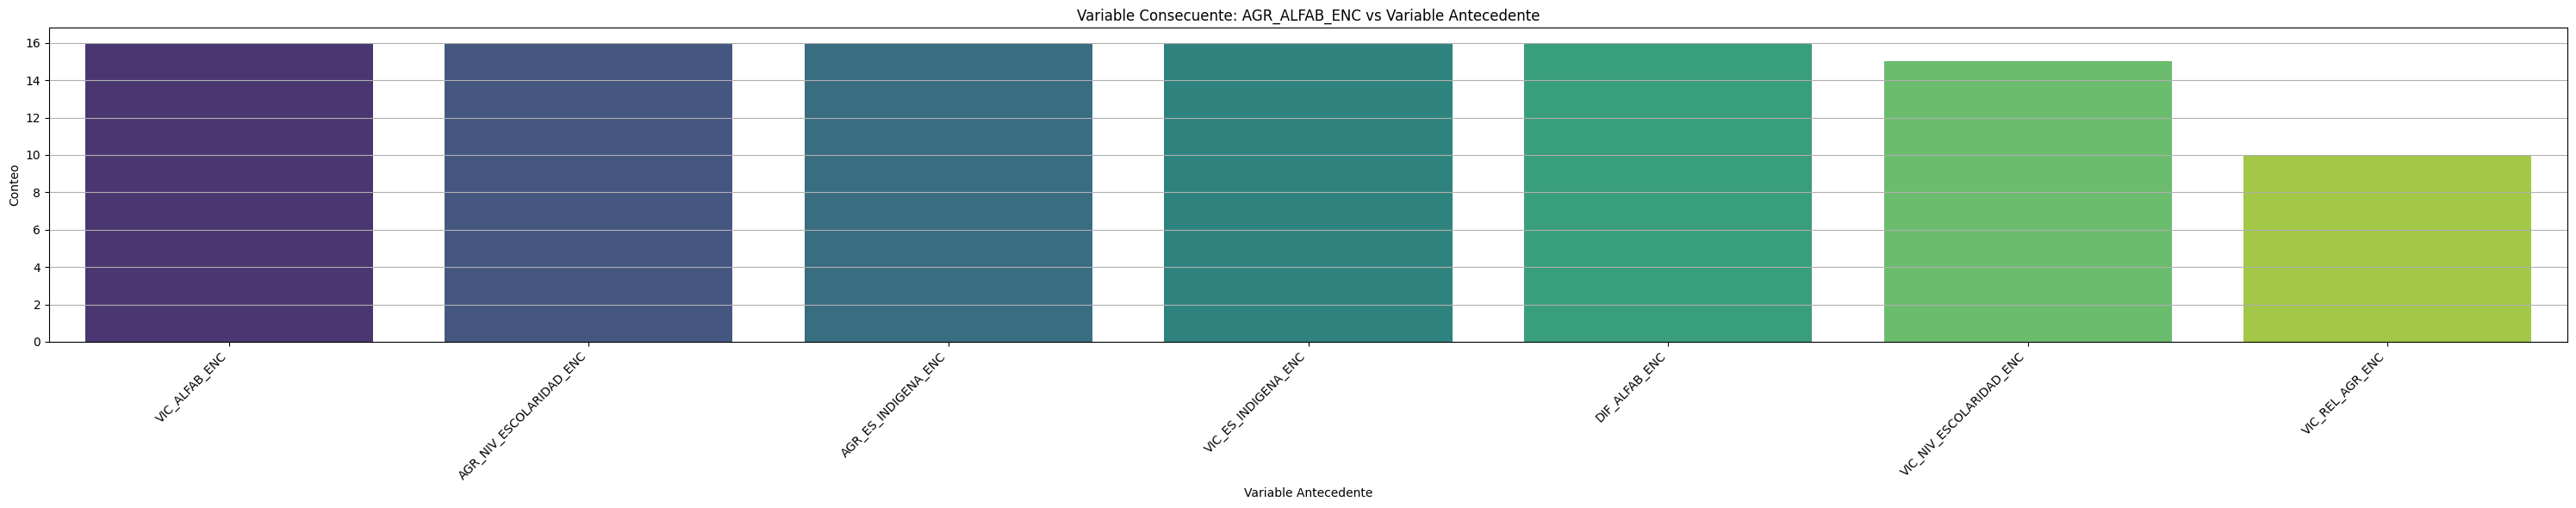

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


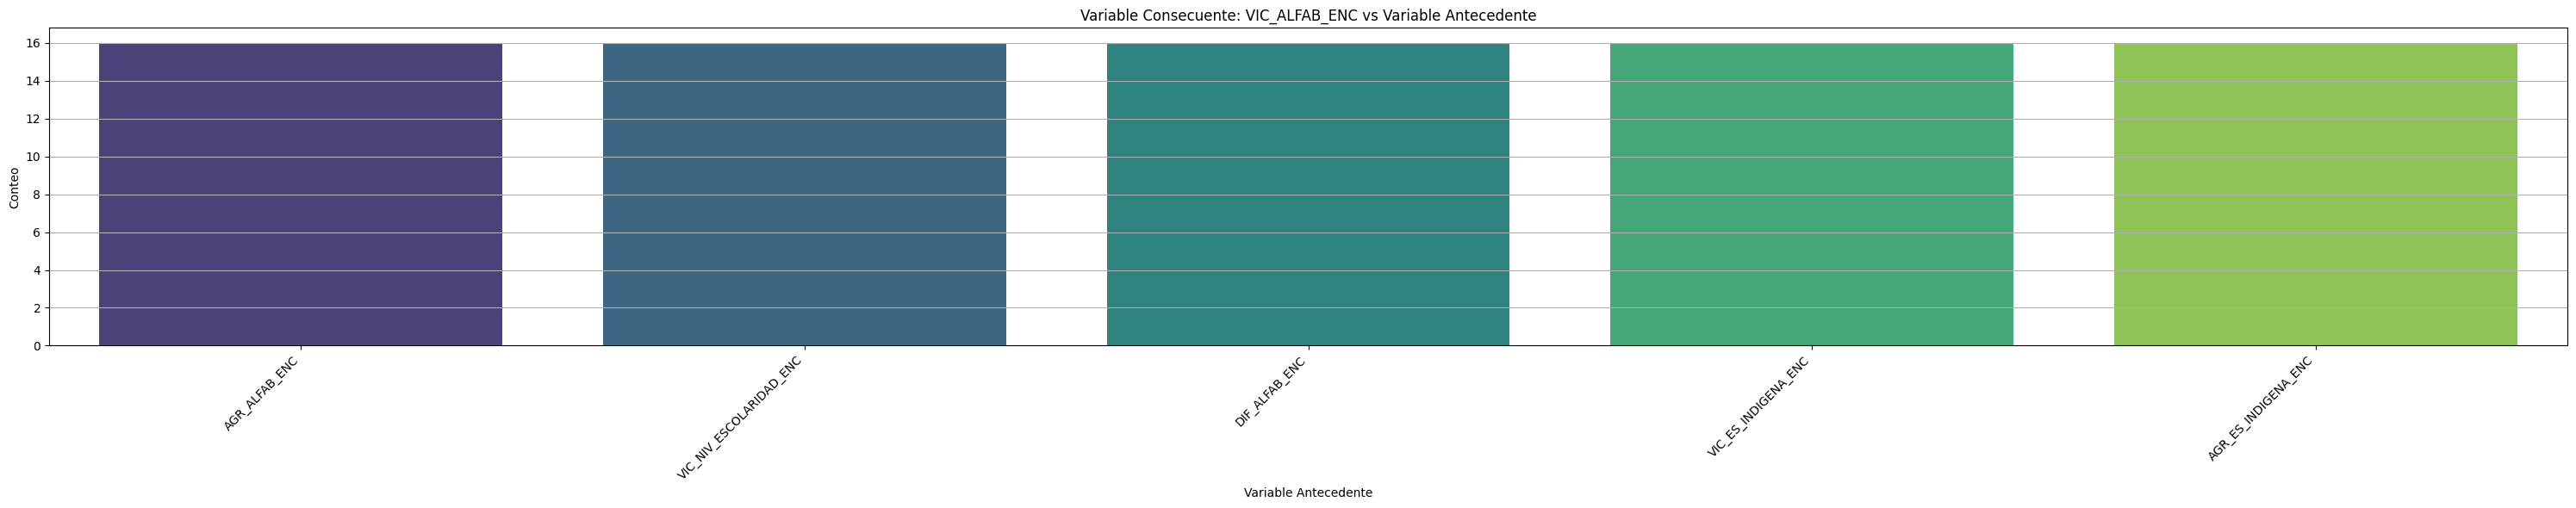

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


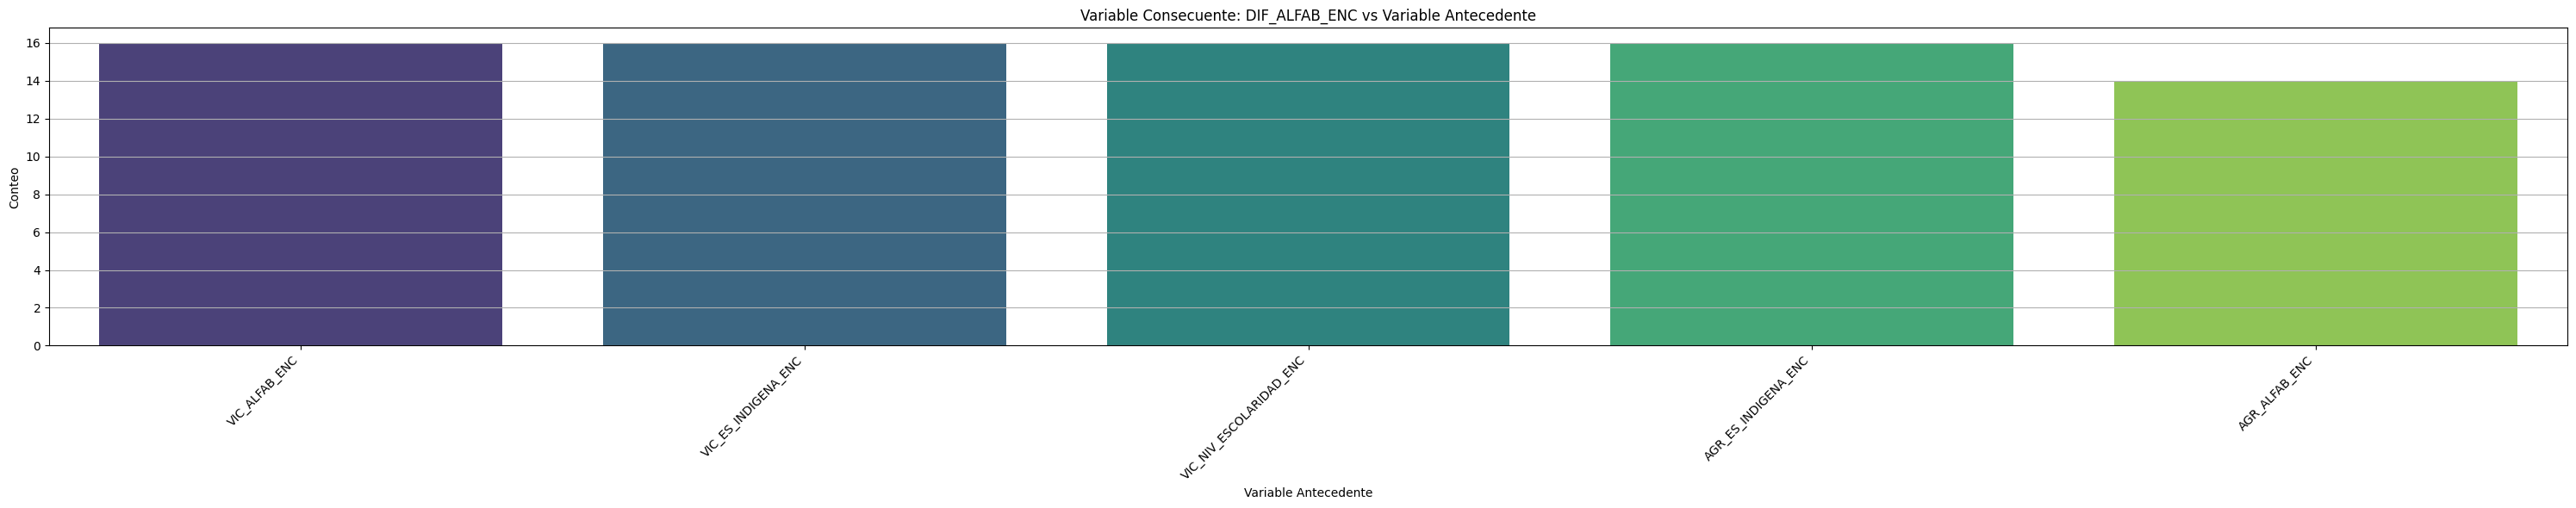

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


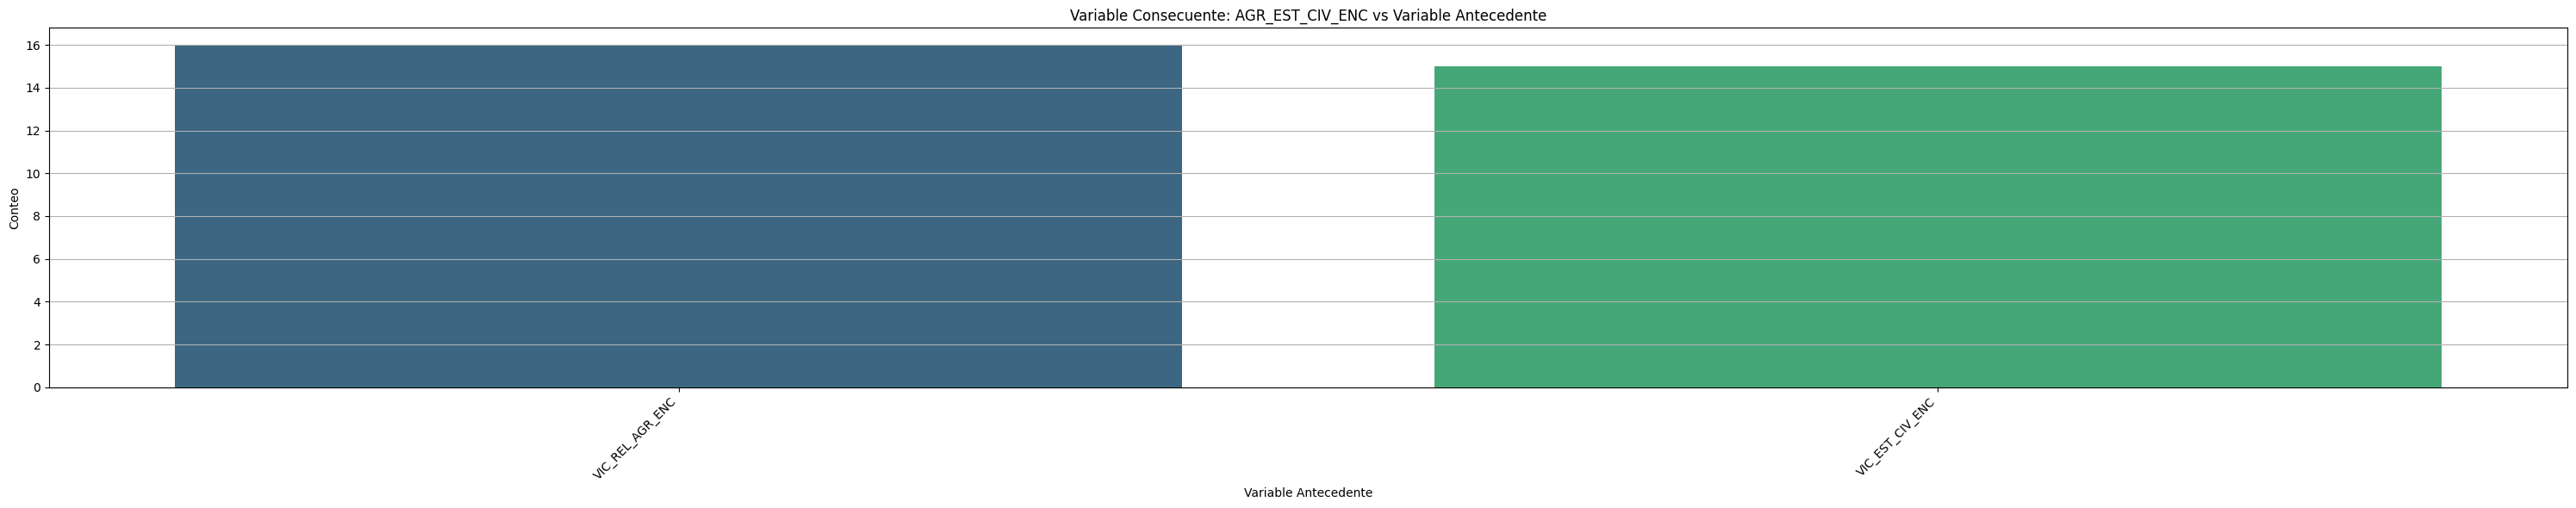

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


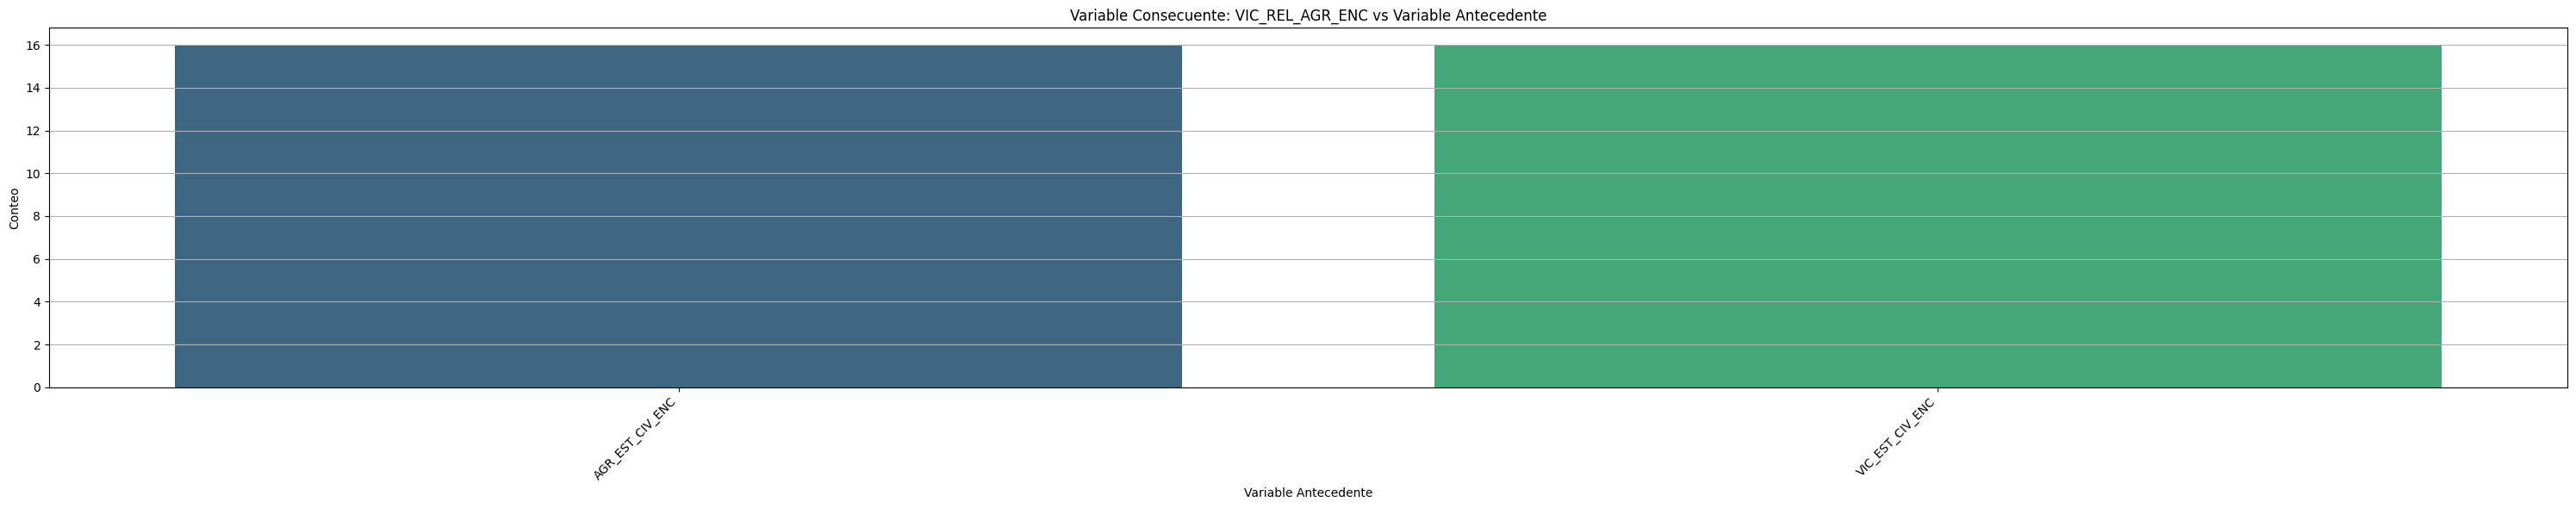

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


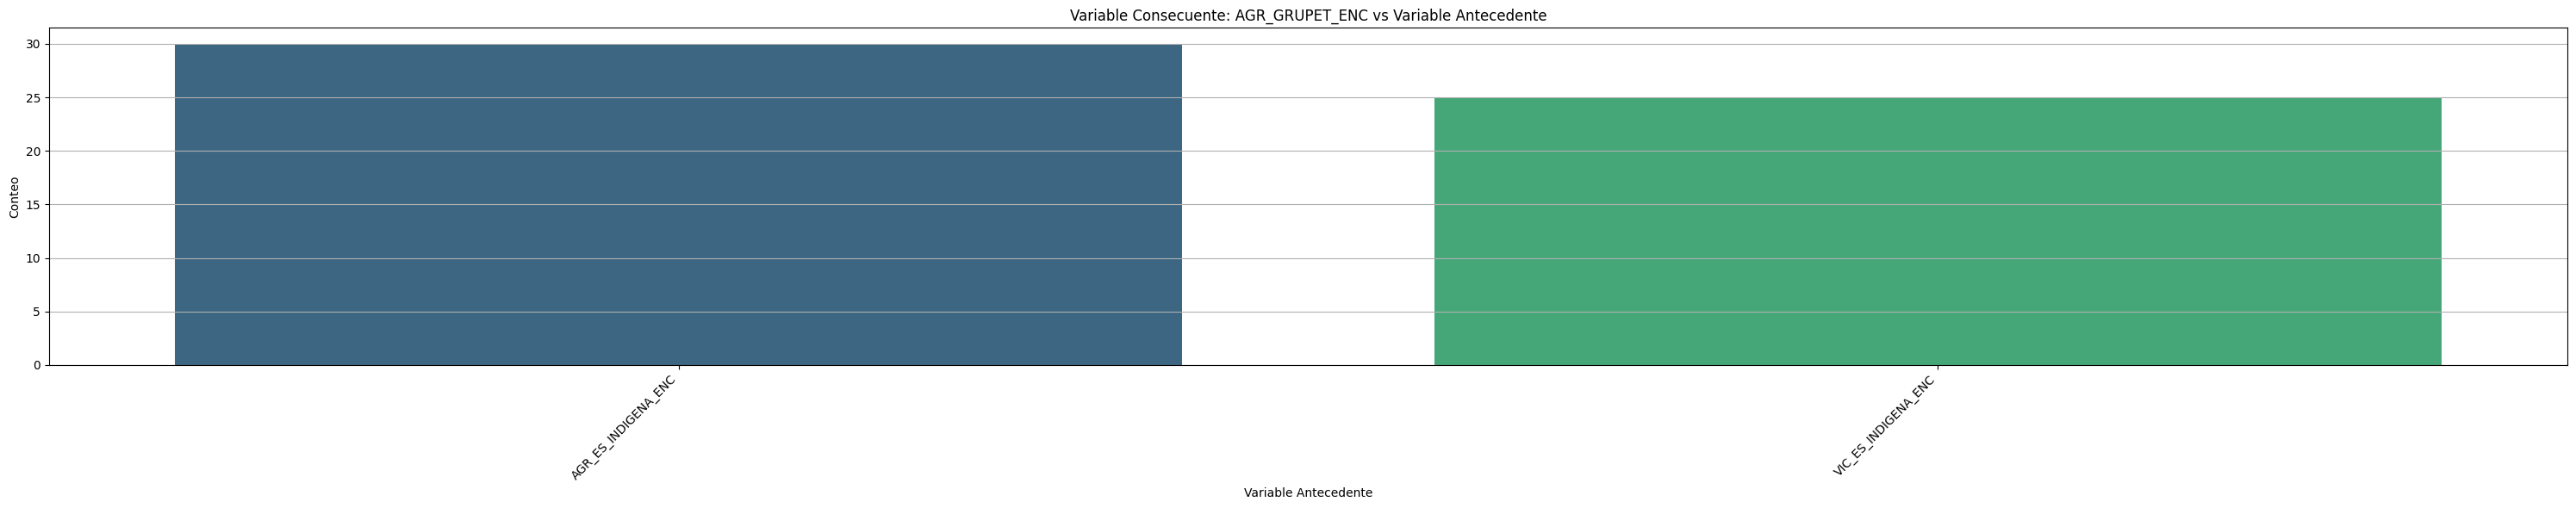

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


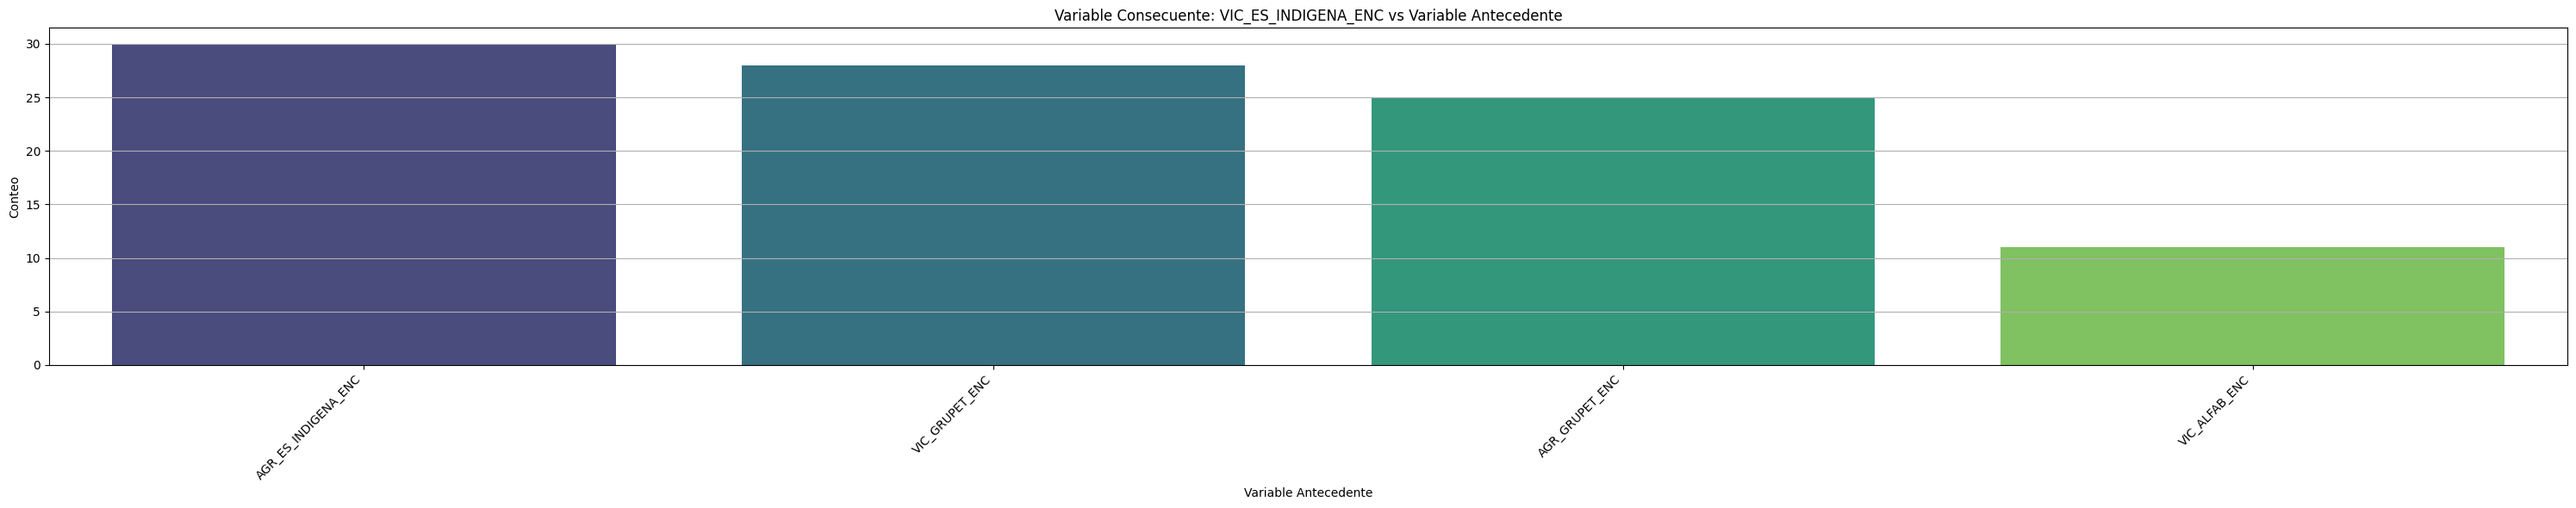

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


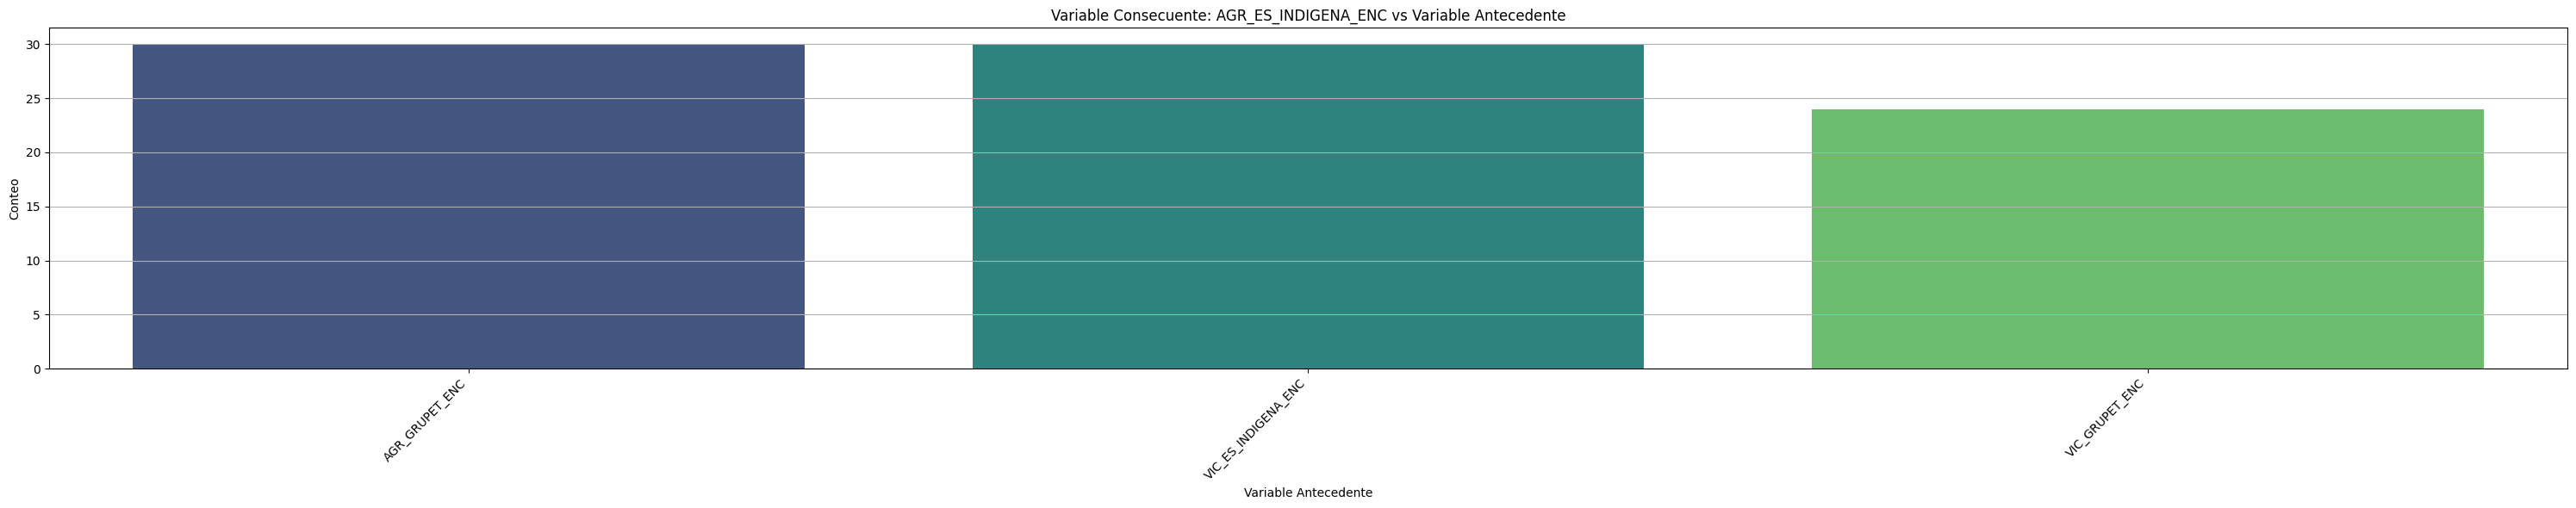

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


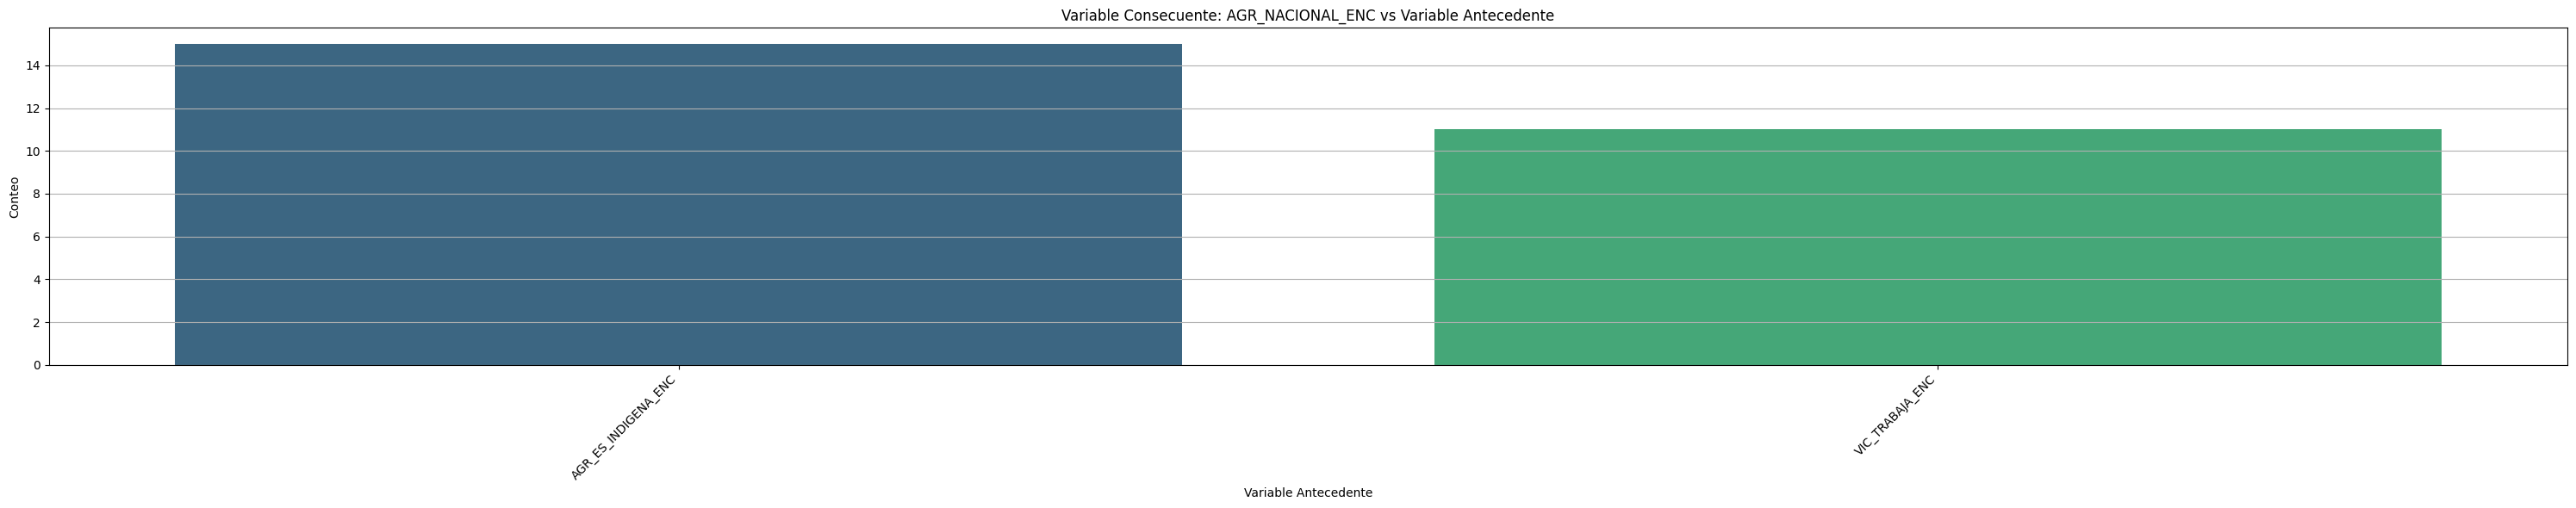

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


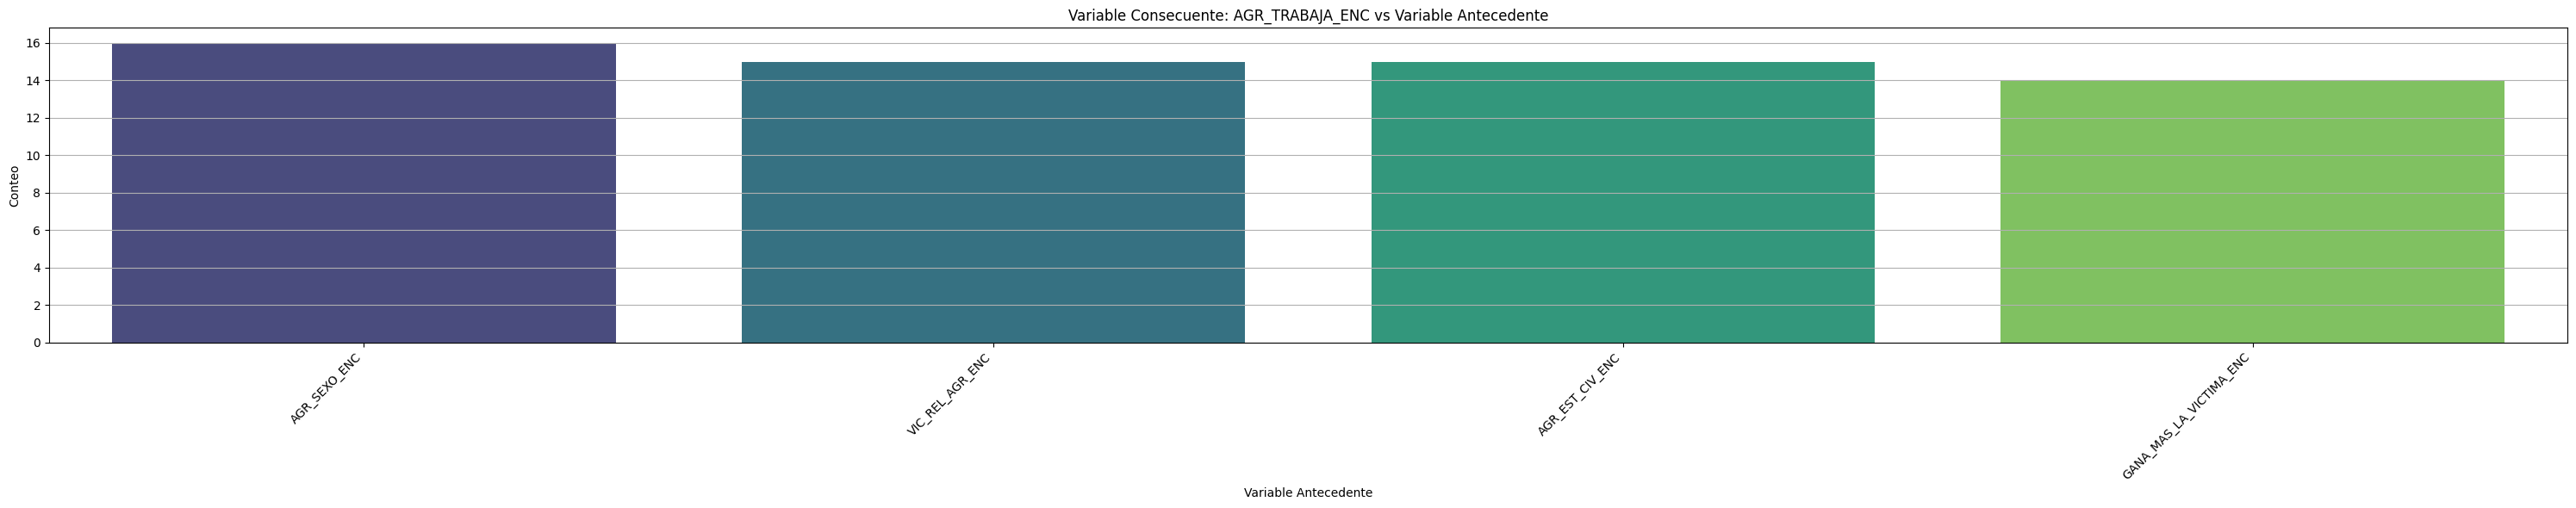

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


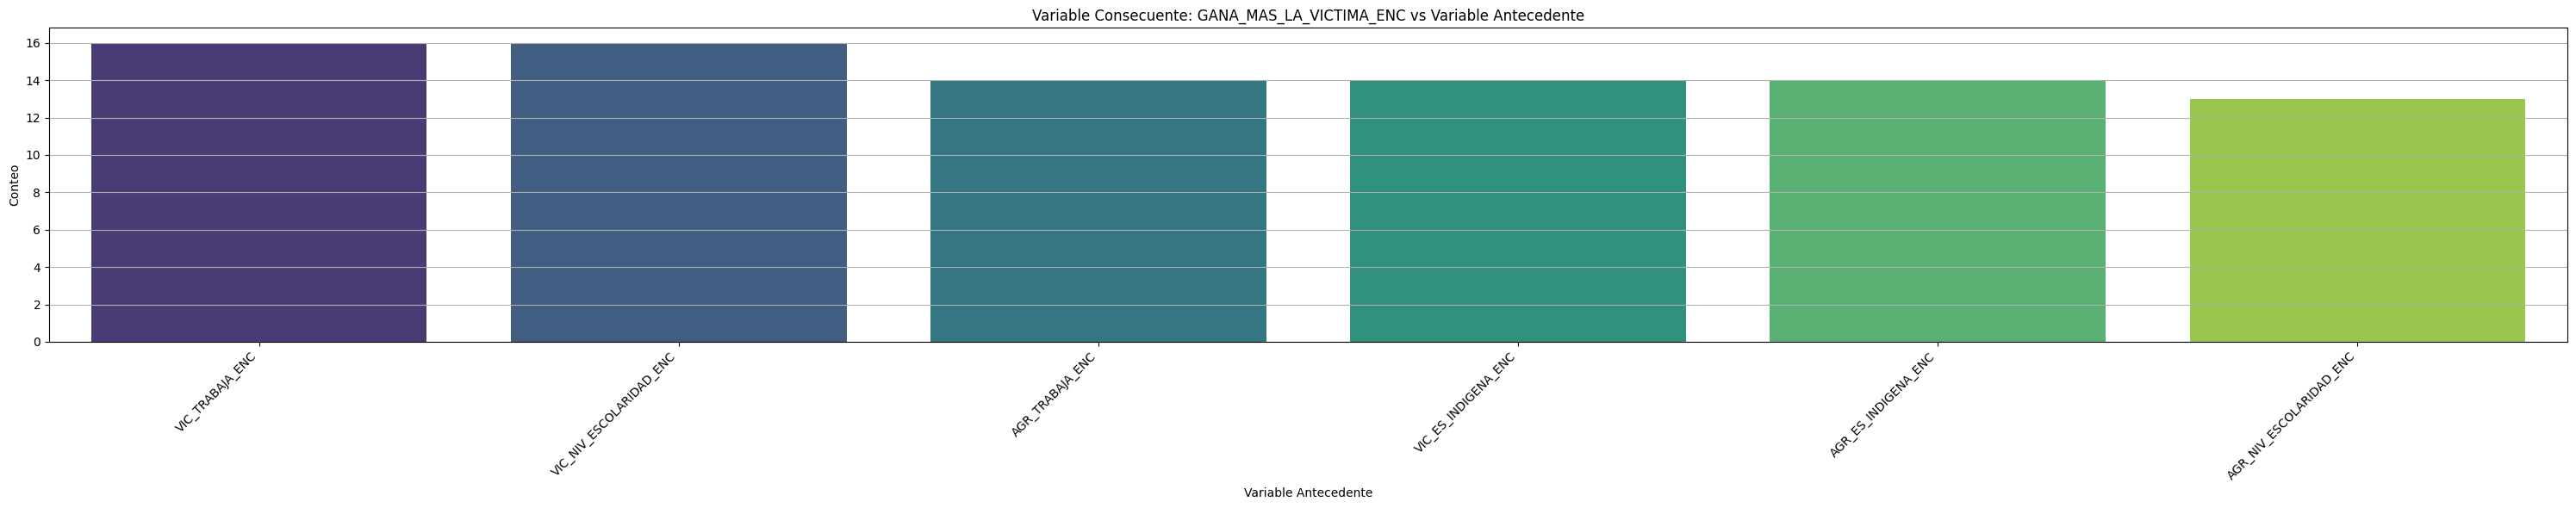

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


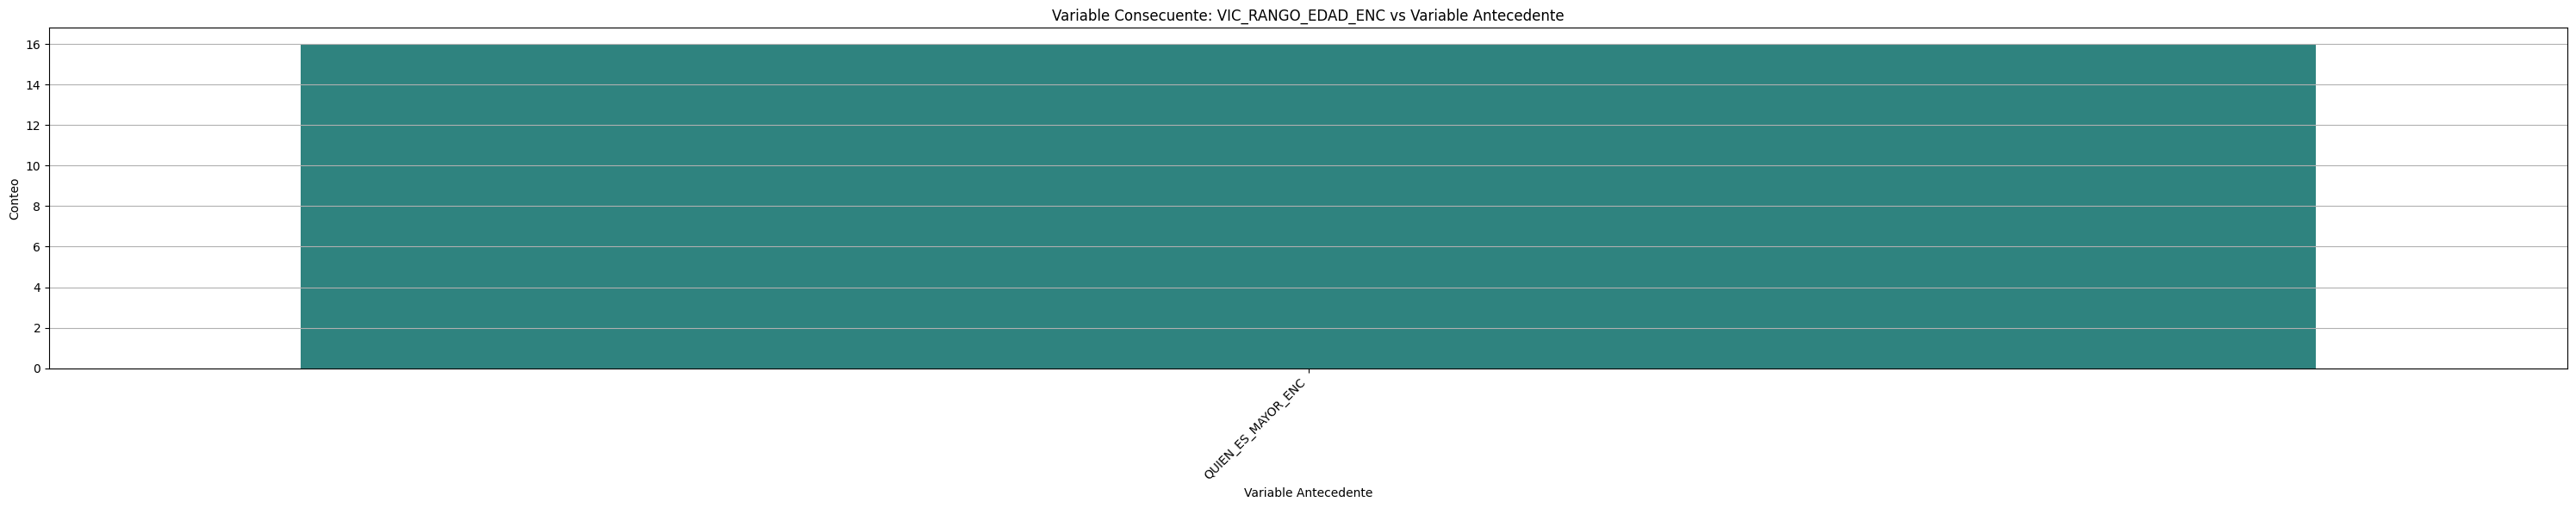

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


No results for VIC_DISC_ENC with count >= 10


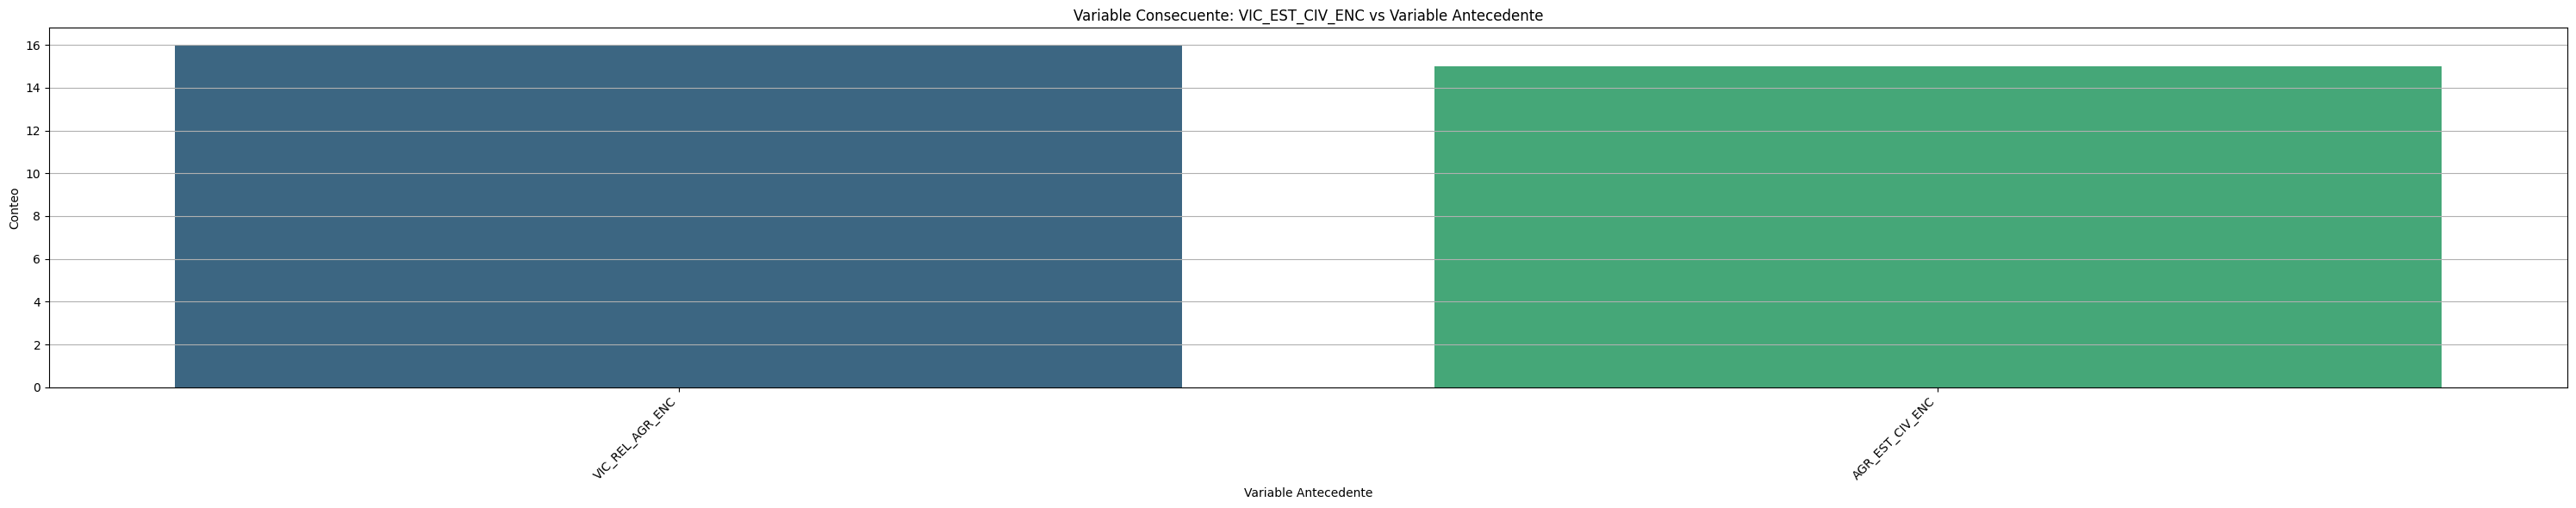

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


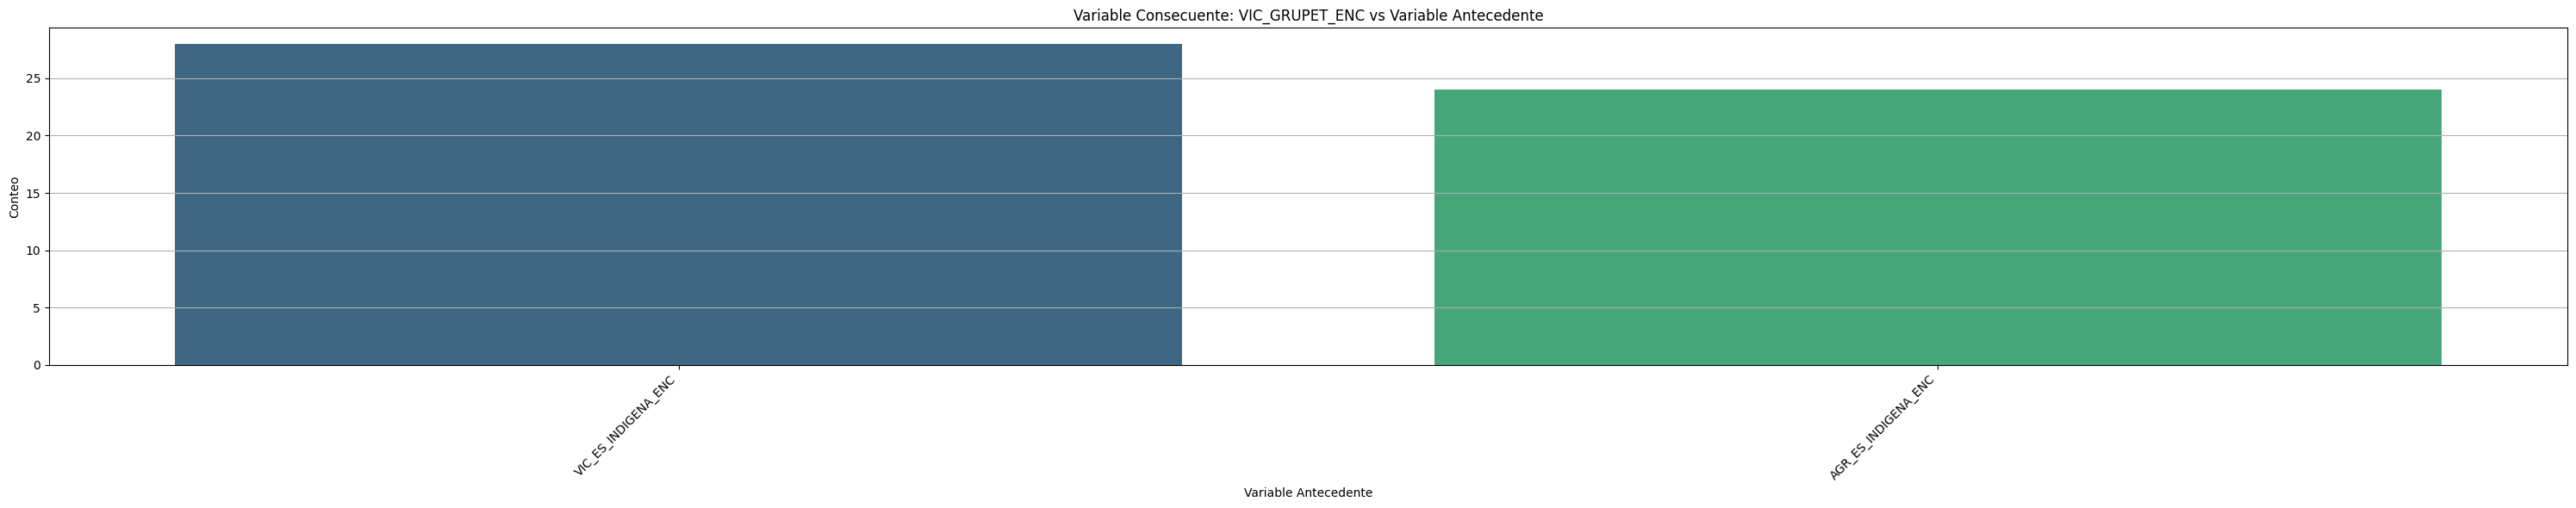

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


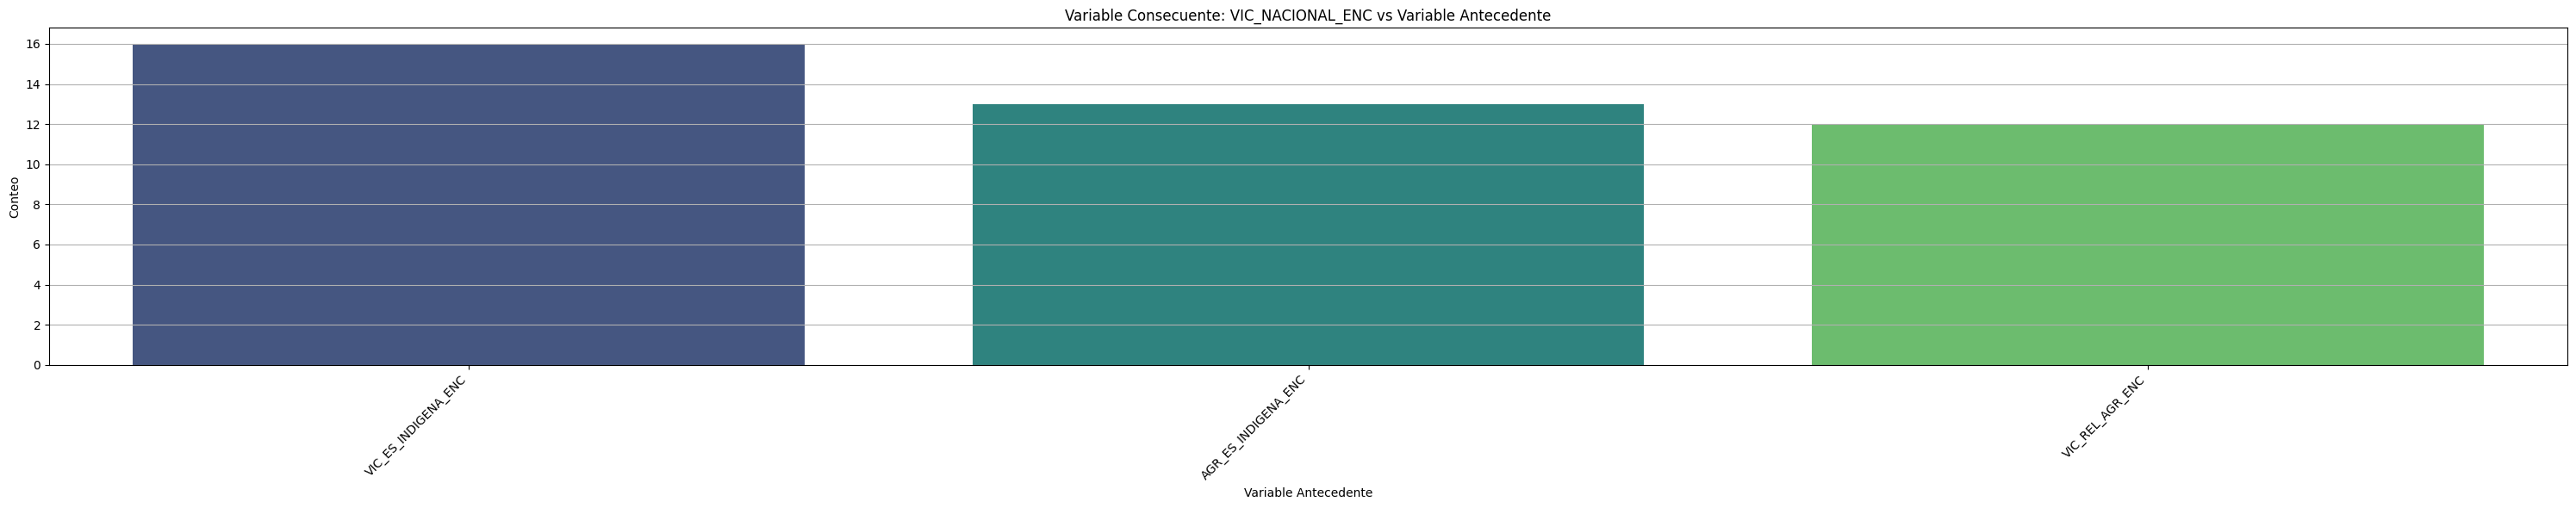

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


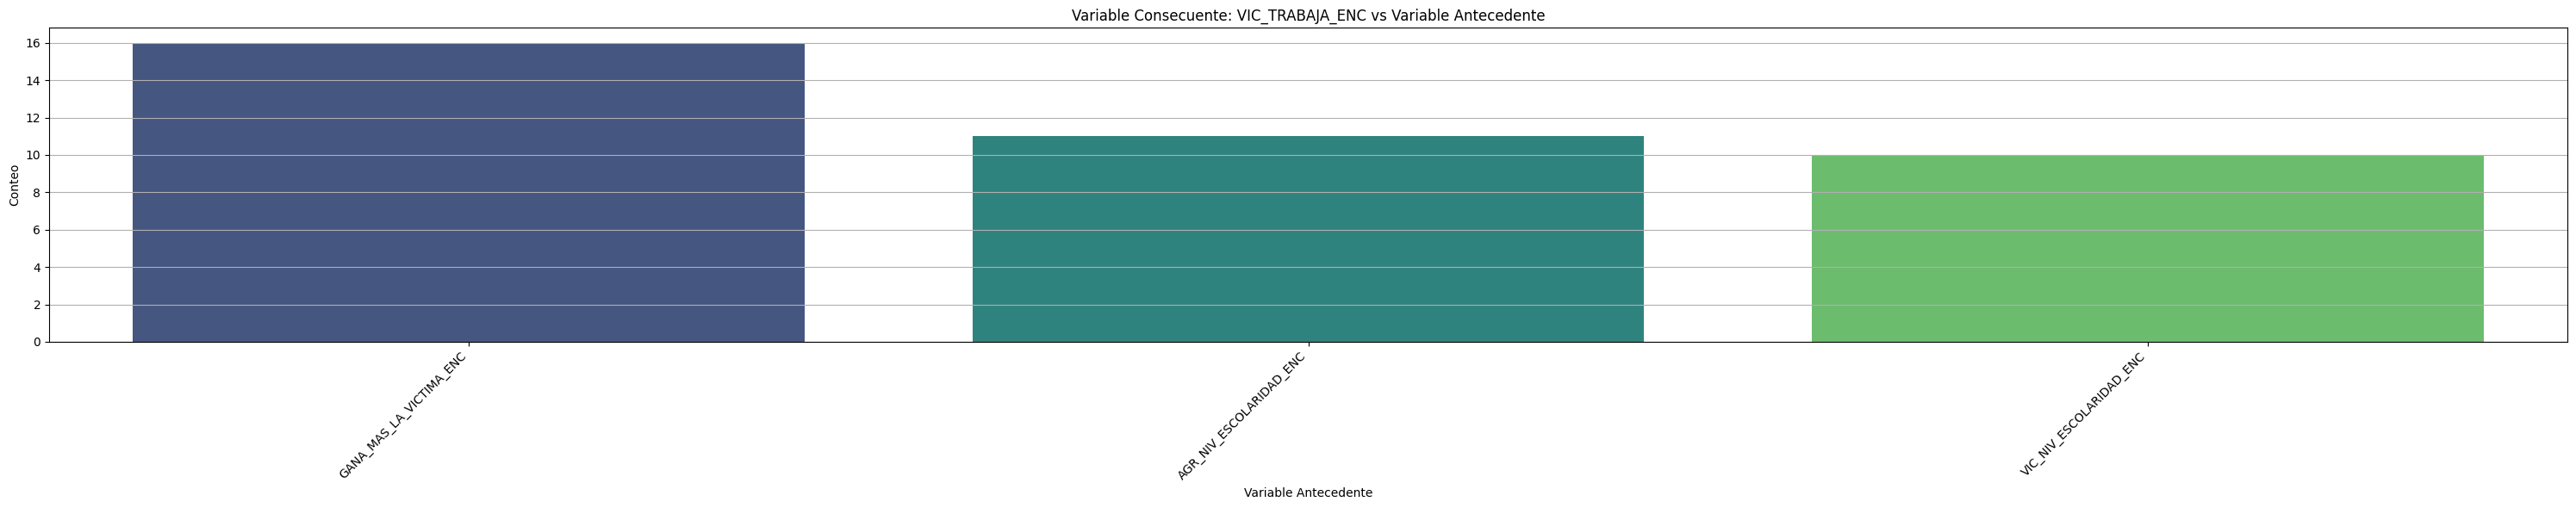

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


No results for AGR_NIV_ESCOLARIDAD_ENC with count >= 10
No results for VIC_NIV_ESCOLARIDAD_ENC with count >= 10


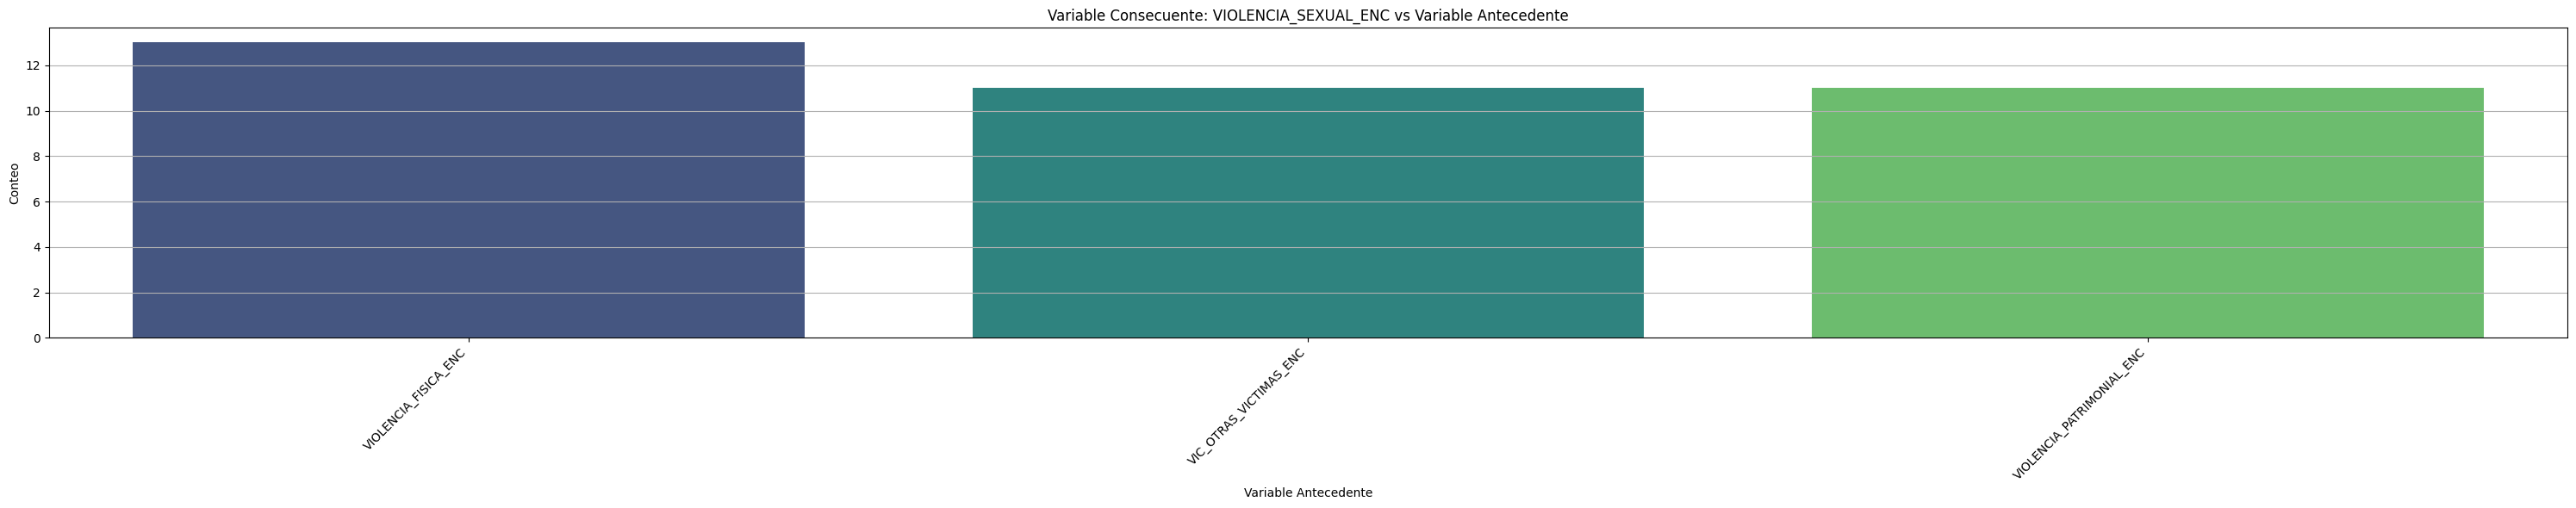

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


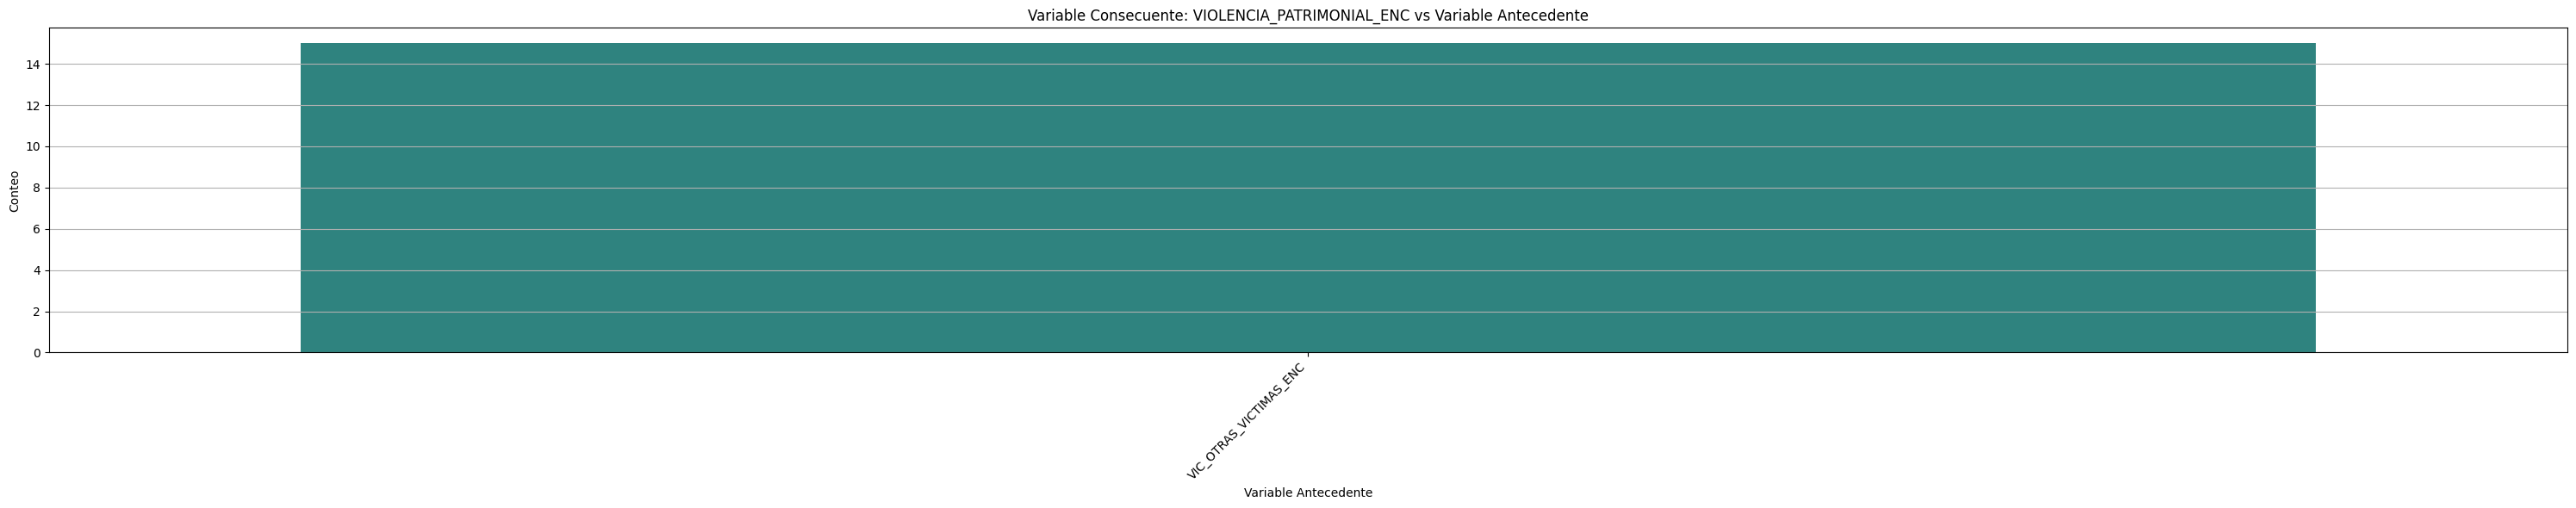

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


No results for VIC_OFICIO_ENC with count >= 10


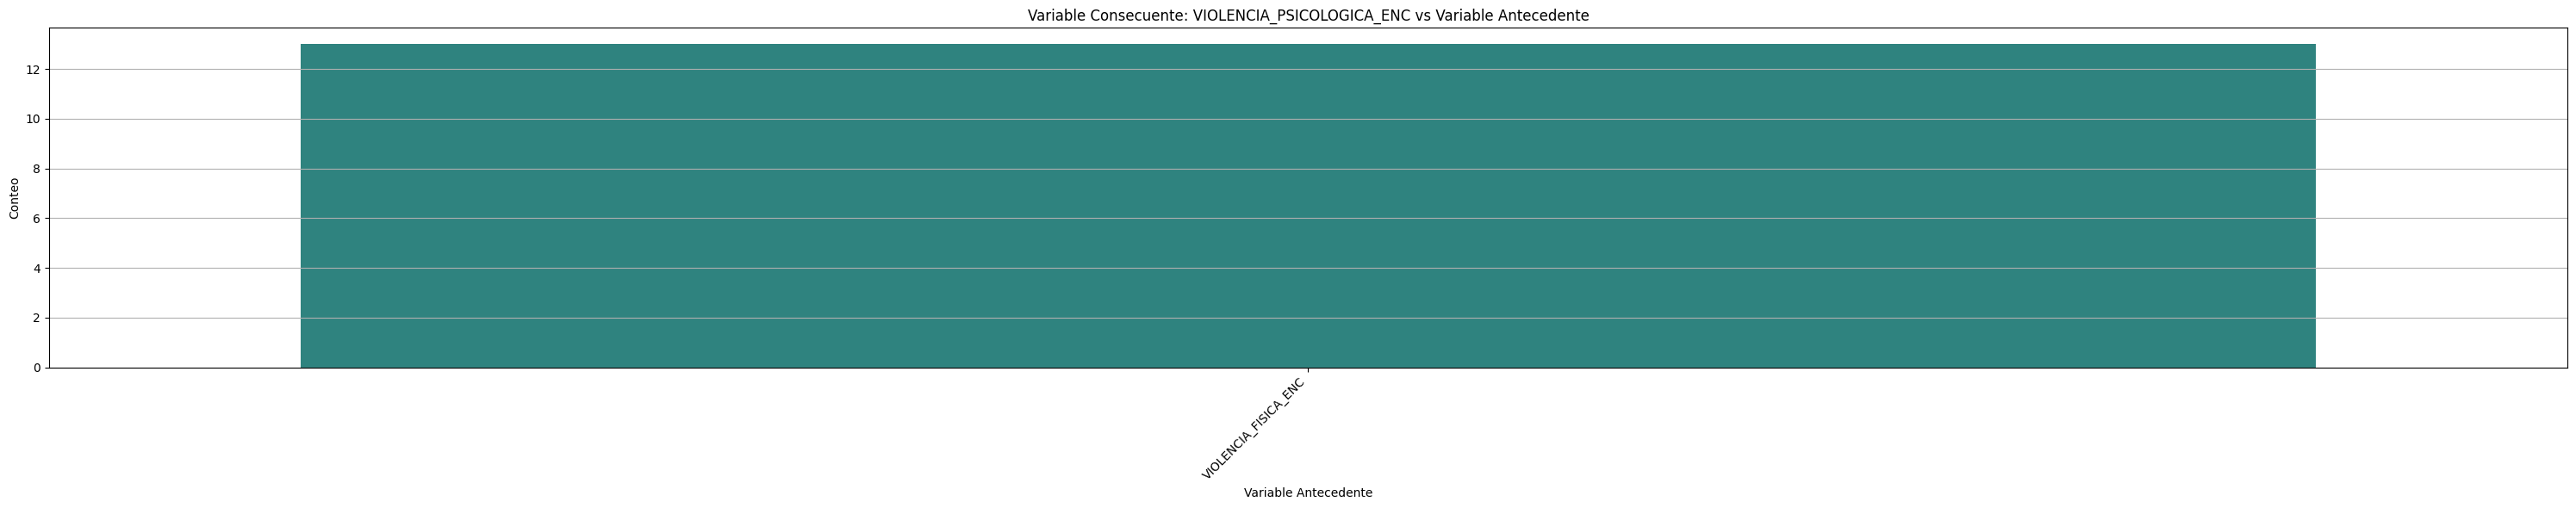

C:\Users\diego\AppData\Local\Temp\ipykernel_22652\4176858113.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_temp, x=y, y='count', palette='viridis')


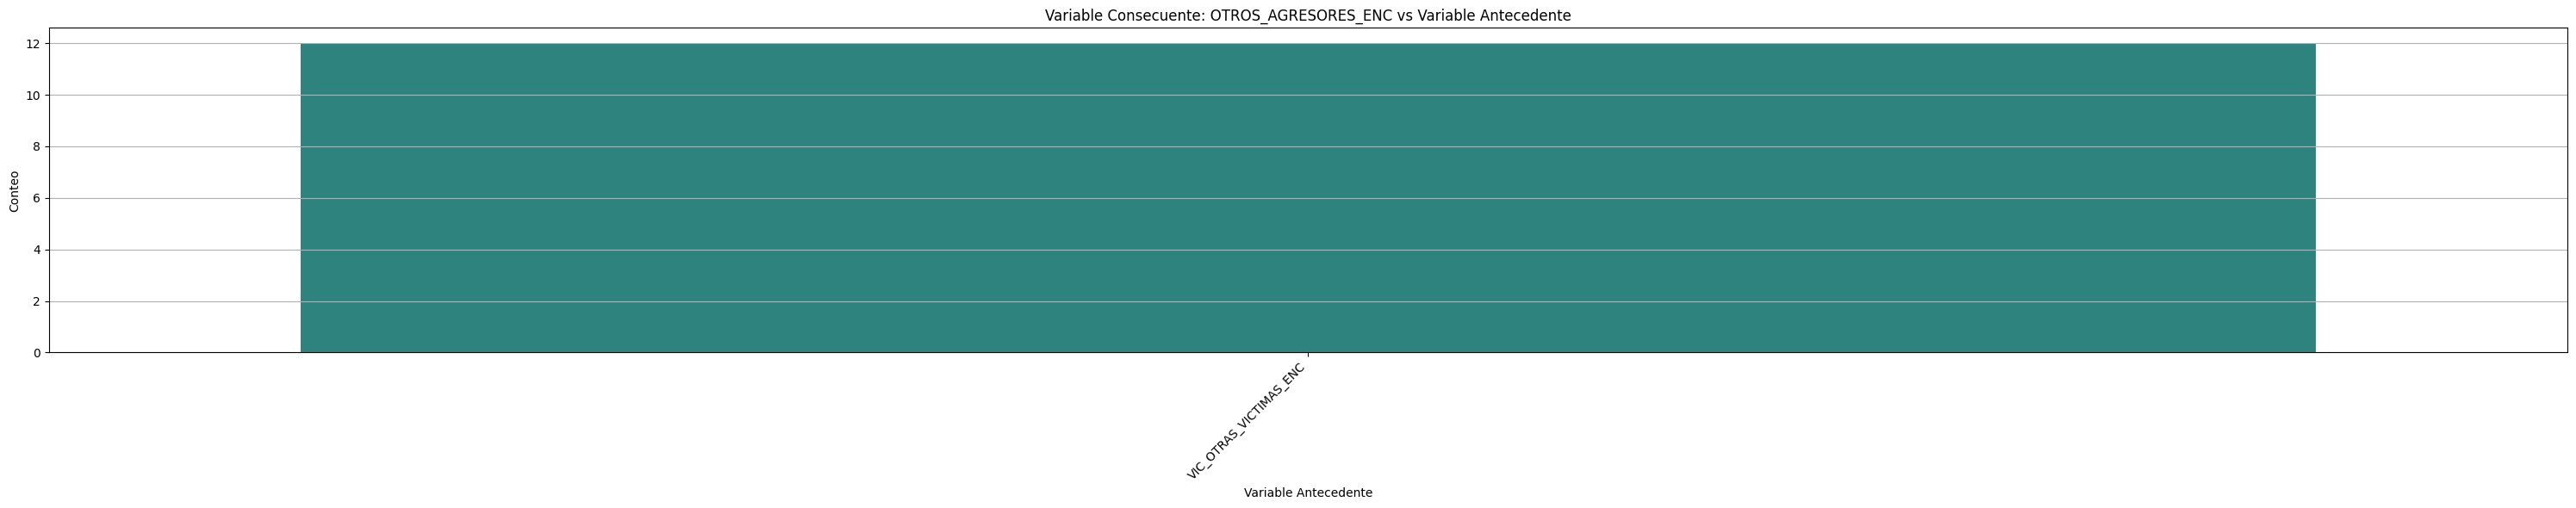

No results for VIC_OTRAS_VICTIMAS_ENC with count >= 10
No results for QUIEN_ES_MAYOR_ENC with count >= 10


In [41]:
analysis_graphs(df_mujer)

In [42]:
df_mujer.columns

Index(['DIVISION', 'YEAR', 'VARIABLE_ANTECEDENTE_ENC',
       'VARIABLE_CONSECUENTE_ENC', 'VARIABLE_ANTECEDENTE',
       'VARIABLE_CONSECUENTE', 'ANTECEDENT', 'CONSECUENT',
       'VARIABLE_ANTECEDENTE_VALOR', 'VARIABLE_CONSECUENTE_VALOR', 'N_ROWS',
       'CHI_2', 'P_VALUE', 'EXPECTED_MIN', 'SUPPORT', 'CONFIDENCE', 'LIFT',
       'CONVICTION', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR'],
      dtype='object')

In [43]:
print(df_mujer[df_mujer['VARIABLE_ANTECEDENTE']=='VIOLENCIA_FISICA'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR','CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_ANTECEDENTE']=='VIOLENCIA_PSICOLOGICA'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR','CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_ANTECEDENTE']=='VIOLENCIA_PATRIMONIAL'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR','CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_ANTECEDENTE']=='VIOLENCIA_SEXUAL'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR','CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='VIOLENCIA_FISICA'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR','CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='VIOLENCIA_PSICOLOGICA'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR','CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='VIOLENCIA_PATRIMONIAL'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR','CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='VIOLENCIA_SEXUAL'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR','CONSECUENTE_VALOR']].value_counts())

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


In [44]:
print(df_mujer[df_mujer['VARIABLE_ANTECEDENTE']=='VIC_OTRAS_VICTIMAS'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_ANTECEDENTE']=='VIC_OTRAS_VICTIMAS'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR']].value_counts())

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


In [45]:
print(df_mujer[df_mujer['VARIABLE_ANTECEDENTE']=='AGR_OCUP_GRUPO'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_ANTECEDENTE']=='VIC_OCUP_GRUPO'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='AGR_OCUP_GRUPO'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='VIC_OCUP_GRUPO'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR']].value_counts())

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


In [46]:
print(df_mujer[df_mujer['VARIABLE_ANTECEDENTE']=='AGR_NIV_ESCOLARIDAD'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_ANTECEDENTE']=='VIC_NIV_ESCOLARIDAD'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='AGR_NIV_ESCOLARIDAD'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR']].value_counts())
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='VIC_NIV_ESCOLARIDAD'][['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR']].value_counts())

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


In [47]:
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='VIOLENCIA_PATRIMONIAL']['CONSECUENTE_VALOR'].value_counts())
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='VIOLENCIA_PSICOLOGICA']['CONSECUENTE_VALOR'].value_counts())
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='VIOLENCIA_SEXUAL']['CONSECUENTE_VALOR'].value_counts())
print(df_mujer[df_mujer['VARIABLE_CONSECUENTE']=='VIOLENCIA_FISICA']['CONSECUENTE_VALOR'].value_counts())

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


In [48]:
df_mujer[df_mujer['VARIABLE_ANTECEDENTE']=='AGR_OCUP_GRUPO']

Empty DataFrame
Columns: [DIVISION, YEAR, VARIABLE_ANTECEDENTE_ENC, VARIABLE_CONSECUENTE_ENC, VARIABLE_ANTECEDENTE, VARIABLE_CONSECUENTE, ANTECEDENT, CONSECUENT, VARIABLE_ANTECEDENTE_VALOR, VARIABLE_CONSECUENTE_VALOR, N_ROWS, CHI_2, P_VALUE, EXPECTED_MIN, SUPPORT, CONFIDENCE, LIFT, CONVICTION, ANTECEDENTE_VALOR, CONSECUENTE_VALOR]
Index: []

In [49]:
df_mujer['VARIABLE_ANTECEDENTE'].unique()

array(['AGR_ALFAB_ENC', 'VIC_ALFAB_ENC', 'VIC_REL_AGR_ENC',
       'VIC_TRABAJA_ENC', 'VIC_NIV_ESCOLARIDAD_ENC',
       'AGR_NIV_ESCOLARIDAD_ENC', 'DIF_ALFAB_ENC', 'VIC_ES_INDIGENA_ENC',
       'AGR_ES_INDIGENA_ENC', 'AGR_EST_CIV_ENC', 'AGR_GRUPET_ENC',
       'AGR_TRABAJA_ENC', 'AGR_SEXO_ENC', 'CANTIDAD_HIJOS_ENC',
       'VIC_OTRAS_VICTIMAS_ENC', 'VIOLENCIA_FISICA_ENC',
       'QUIEN_ES_MAYOR_ENC', 'GANA_MAS_LA_VICTIMA_ENC', 'VIC_EST_CIV_ENC',
       'VIC_GRUPET_ENC', 'VIOLENCIA_PATRIMONIAL_ENC', 'AGR_OFICIO_ENC',
       'VIC_OFICIO_ENC', 'OTROS_AGRESORES_ENC', 'VIC_RANGO_EDAD_ENC',
       'VIOLENCIA_PSICOLOGICA_ENC'], dtype=object)

In [50]:
# c_muj = df_mujer[df_mujer['DIVISION']=='mujeres'][['ANTECEDENTE', 'CONSECUENTE']].value_counts().reset_index()

In [51]:
df_mujer.columns

Index(['DIVISION', 'YEAR', 'VARIABLE_ANTECEDENTE_ENC',
       'VARIABLE_CONSECUENTE_ENC', 'VARIABLE_ANTECEDENTE',
       'VARIABLE_CONSECUENTE', 'ANTECEDENT', 'CONSECUENT',
       'VARIABLE_ANTECEDENTE_VALOR', 'VARIABLE_CONSECUENTE_VALOR', 'N_ROWS',
       'CHI_2', 'P_VALUE', 'EXPECTED_MIN', 'SUPPORT', 'CONFIDENCE', 'LIFT',
       'CONVICTION', 'ANTECEDENTE_VALOR', 'CONSECUENTE_VALOR'],
      dtype='object')

In [52]:
df_temp = df_mujer[['VARIABLE_ANTECEDENTE','VARIABLE_ANTECEDENTE_VALOR', 'VARIABLE_CONSECUENTE', 'VARIABLE_CONSECUENTE_VALOR', 'N_ROWS', 'CHI_2', 'P_VALUE', 'EXPECTED_MIN', 'SUPPORT', 'CONFIDENCE', 'LIFT', 'CONVICTION']]
 

In [53]:
VARIABLES = [
    ['VIC_ALFAB',
    'VIC_ES_INDIGENA',
    'VIC_NIV_ESCOLARIDAD',
    'VIC_TRABAJA',
    'CANTIDAD_HIJOS',],
    ['AGR_ALFAB',
    'AGR_ES_INDIGENA',
    'AGR_NIV_ESCOLARIDAD',
    # 'AGR_TRABAJA',
    'AGR_SEXO',
    'VIOLENCIA_FISICA',
    'VIOLENCIA_PSICOLOGICA',
    'VIOLENCIA_SEXUAL',
    'VIOLENCIA_PATRIMONIAL',],
    ['VIC_EST_CIV', 'VIC_REL_AGR', 'AGR_EST_CIV','GANA_MAS_LA_VICTIMA','AGR_TRABAJA','VIC_TRABAJA', 'DIF_ESCOLARIDAD_AGR_VIC']
    
]

In [54]:
selected_vars = [var+'_ENC' for sublist in VARIABLES for var in sublist]

## 4. Filter the DataFrame
# We filter for rows where EITHER the ANTECEDENTE OR the CONSECUENTE is in our list.
filter_mask = (
    df_temp['VARIABLE_ANTECEDENTE'].isin(selected_vars) &
    df_temp['VARIABLE_CONSECUENTE'].isin(selected_vars)
)

# Apply the filter
df_filtered = df_temp[filter_mask]

# Display the resulting DataFrame
print(df_filtered)

     VARIABLE_ANTECEDENTE VARIABLE_ANTECEDENTE_VALOR     VARIABLE_CONSECUENTE  \
0           AGR_ALFAB_ENC                   alfabeta             AGR_SEXO_ENC   
1           VIC_ALFAB_ENC                   alfabeta            AGR_ALFAB_ENC   
2           AGR_ALFAB_ENC                   alfabeta            VIC_ALFAB_ENC   
3         VIC_REL_AGR_ENC                esposos(as)            AGR_ALFAB_ENC   
4         VIC_TRABAJA_ENC                         si            AGR_ALFAB_ENC   
...                   ...                        ...                      ...   
1443  AGR_ES_INDIGENA_ENC                         no      VIC_ES_INDIGENA_ENC   
1444  VIC_ES_INDIGENA_ENC                         si      AGR_ES_INDIGENA_ENC   
1445  AGR_ES_INDIGENA_ENC                         si      VIC_ES_INDIGENA_ENC   
1446  VIC_ES_INDIGENA_ENC                         si  GANA_MAS_LA_VICTIMA_ENC   
1447  AGR_ES_INDIGENA_ENC                         si  GANA_MAS_LA_VICTIMA_ENC   

     VARIABLE_CONSECUENTE_V

In [ ]:
df_final = df_filtered.groupby(by=['VARIABLE_ANTECEDENTE', 'VARIABLE_CONSECUENTE', 'VARIABLE_ANTECEDENTE_VALOR', 'VARIABLE_CONSECUENTE_VALOR'])\
    .agg(
        # Calcular el promedio para las métricas
        N_ROWS=('N_ROWS', 'mean'), 
        CHI_2=('CHI_2', 'mean'), 
        P_VALUE=('P_VALUE', 'mean'), 
        EXPECTED_MIN=('EXPECTED_MIN', 'mean'), 
        SUPPORT=('SUPPORT', 'mean'), 
        CONFIDENCE=('CONFIDENCE', 'mean'), 
        LIFT=('LIFT', 'mean'), 
        CONVICTION=('CONVICTION', 'mean'),
        
        # ** Contar la frecuencia del grupo (Repeticiones) **
        # Se usa cualquier columna (ej. N_ROWS) y la función 'count'
        REPETICIONES=('N_ROWS', 'count') 
    )\
    .reset_index()

# Guardar el DataFrame final a LaTeX
df_final[df_final['REPETICIONES'] >= MIN_AMOUNT_REPETITIONS].to_latex('../documento/plantilla/results_apriori/table_filtered_apriori.tex', index=False)